In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from xgboost import plot_importance
import optuna
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go

pd.set_option('display.max_columns', 501)
pd.set_option('display.max_rows', 501)

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# FUNCTIONS

In [2]:
# hyper-paremeter optimization
def optimize(n_optimization_trials, training_X, training_y, validation_X, validation_y):

    study = optuna.create_study()
    study.optimize(objective, n_trials=n_optimization_trials)
    print('Best params:')
    print(study.best_params)
    print('RMSE for best params:')
    print(study.best_value)

In [3]:
def train_model(xgb_params, fit_params, training_X, training_y, validation_X, validation_y, testing_X, testing_y):

    # fit model
    model = XGBRegressor(**xgb_params)
    model.fit(training_X, training_y, eval_set=[(validation_X, validation_y)], **fit_params)

    # metrics
    predictions_validation = model.predict(validation_X)
    rmse_validation = mean_squared_error(validation_y, predictions_validation, squared=False)
    mae_validation = mean_absolute_error(validation_y, predictions_validation)
    r2_validation = r2_score(validation_y, predictions_validation)
    print(f'Validation RMSE: {rmse_validation}')
    print(f'Validation MAE: {mae_validation}')
    print(f'Validation R2: {r2_validation}')
    predictions_test = model.predict(testing_X)
    rmse_test = mean_squared_error(testing_y, predictions_test, squared=False)
    mae_test = mean_absolute_error(testing_y, predictions_test)
    r2_test = r2_score(testing_y, predictions_test)
    print(f'Test RMSE: {rmse_test}')
    print(f'Test MAE: {mae_test}')
    print(f'Test R2: {r2_test}')
    
    return model

In [4]:
def draw_player_predictions(name_string, testing_full, model):
    
    aux = testing_full[testing_full['name'].str.contains(name_string)]
    y_true = aux['total_points']
    xPoints = aux['xPoints']
    y_pred = model.predict(aux[input_variables])

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=aux['GW'],
            y=y_true,
           mode="markers+lines",
            name='true points'
        )
    )

    fig.add_trace(
        go.Scatter(
            x=aux['GW'],
            y=xPoints,
           mode="markers+lines",
            name='xPoints'
        )
    )

    fig.add_trace(
        go.Scatter(
            x=aux['GW'],
            y=y_pred,
           mode="markers+lines",
            name='predicted points'
        )
    )

    #fig.update_xaxes(range=[predictions.min()-1, predictions.max()+1])

    fig.update_layout(
        title=aux['name'].unique()[0],
        xaxis_title="gameweek",
        yaxis_title="points",
        showlegend=True
        )

    fig.show()

    print(f'Total true points: {np.sum(y_true)}')
    print(f'Total expected points: {np.sum(xPoints)}')
    print(f'Total predicted points: {np.sum(y_pred)}')

In [5]:
def calculate_all_player_predictions(testing_full, model):
    
    player_names = testing_full['name'].unique()
    stats = []
    for player_name in player_names:
        aux = testing_full[testing_full['name']==player_name]
        total_points = aux['total_points'].sum()
        xPoints = aux['xPoints'].sum()
        predicted_points = model.predict(aux[input_variables]).sum()
        stats.append((player_name, total_points, xPoints, predicted_points))

    stats_df = pd.DataFrame(data=stats, columns=['name', 'total_points', 'xPoints', 'predicted_points'])
    
    return stats_df

In [6]:
def draw_all_predictions(stats_df):
    
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=stats_df['predicted_points'],
            y=stats_df['total_points'],
            hovertext=stats_df['name'],
           mode="markers",
            #opacity=0.6,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=np.linspace(0,250,100),
            y=np.linspace(0,250,100),
           mode="lines",
        )
    )

    #fig.update_xaxes(range=[predictions_test.min()-1, predictions_test.max()+1])

    fig.update_layout(
        title="Test set",
        xaxis_title="predicted points",
        yaxis_title="true points",
        showlegend=False
        )

    fig.show()

In [7]:
def objective(trial):
    
    # parameters
    xgb_params = {}
    xgb_params['learning_rate'] = trial.suggest_float('learning_rate', 0.001, 1)
    xgb_params['max_depth'] = trial.suggest_int('max_depth',3,10)
    xgb_params['min_child_weight'] = trial.suggest_float('min_child_weight', 0.01, 2)
    xgb_params['gamma'] = trial.suggest_float('gamma', 0, 0.5)
    xgb_params['subsample'] = trial.suggest_float('subsample', 0.5, 1)
    xgb_params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.5, 1)
    xgb_params['n_estimators'] = 200
    #xgb_params['monotone_constraints'] = monotone_constraints

    fit_params = {}
    fit_params['early_stopping_rounds'] = 25
    sample_weight = training_X['total_points_ewa_40'].fillna(1)
    sample_weight[sample_weight<1] = 1
    fit_params['sample_weight'] = sample_weight
    sample_weight_eval_set = validation_X['total_points_ewa_40'].fillna(1)
    sample_weight_eval_set[sample_weight_eval_set<1] = 1
    fit_params['sample_weight_eval_set'] = [sample_weight_eval_set]
    
    # train model
    model = XGBRegressor(**xgb_params)
    model.fit(training_X, training_y, eval_set=[(validation_X, validation_y)], **fit_params)
    # get rmse of the model on the test set (this is without weighting samples, so rmse will differ slightly from model training rmse)
    predictions = model.predict(validation_X)
    rmse = mean_squared_error(validation_y, predictions, squared=False)
    
    return rmse

# DATA

In [8]:
data = pd.read_csv('../../data/data_for_modelling.csv', index_col=0)
data

season                  name position  assists  bonus  bps  \
0      2017-18       Aaron Cresswell      DEF        0      0    3   
1752   2017-18       Aaron Cresswell      DEF        0      0   16   
3513   2017-18       Aaron Cresswell      DEF        0      0   11   
5141   2017-18       Aaron Cresswell      DEF        0      0   23   
5295   2017-18       Aaron Cresswell      DEF        0      3   30   
...        ...                   ...      ...      ...    ...  ...   
40554  2021-22        Tony Springett      MID        0      0    2   
40555  2021-22        Tony Springett      MID        0      0    9   
40921  2021-22        Tony Springett      MID        0      0    0   
40851  2021-22  Nathan Young-Coombes      FWD        0      0    2   
40970  2021-22           Isaac Price      MID        0      0   -2   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1752              0        52.9      443       15               3   
3513              0         1.6      443       26               3   
5141              1        47.1      443       40               0   
5295              1        34.3      443       48               0   
...             ...         ...      ...      ...             ...   
40554             0         0.7      716      360               1   
40555             0        21.0      716      207               2   
40921             0         0.0      716      380               3   
40851             0         0.0      640      352               0   
40970             0         0.0      718      371               1   

       goals_scored  ict_index  influence               kickoff_time  minutes  \
0                 0        1.9        0.4  2017-08-13 15:00:00+00:00        9   
1752              0        7.4       21.2  2017-08-19 14:00:00+00:00       90   
3513              0        2.4       11.2  2017-08-26 14:00:00+00:00       90   
5141              0        6.2       14.2  2017-09-11 19:00:00+00:00       90   
5295              0        4.6       11.2  2017-09-16 14:00:00+00:00       90   
...             ...        ...        ...                        ...      ...   
40554             0        1.0        1.4  2022-05-08 13:00:00+00:00       45   
40555             0        5.3       13.0  2022-05-11 18:45:00+00:00       66   
40921             0        0.0        0.0  2022-05-22 15:00:00+00:00       29   
40851             0        0.0        0.0  2022-05-07 14:00:00+00:00        3   
40970             0        0.0        0.0  2022-05-22 15:00:00+00:00       13   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1752              14     Southampton          0                 0   
3513              13   Newcastle Utd          0                 0   
5141               8    Huddersfield          0                 0   
5295              19       West Brom          0                 0   
...              ...             ...        ...               ...   
40554             19        West Ham          0                 0   
40555              9  Leicester City          0                 0   
40921             17       Tottenham          0                 0   
40851             16     Southampton          0                 0   
40970              1         Arsenal          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0       NaN           0.0   
1752                 0          0      2      0   25136.0           2.0   
3513                 0          0      3      0   27824.0           0.0   
5141                 0          0      4      0   28464.0           0.0   
5295                 0          0      5      0   28977.0           0.0   
...                ...        ...    ...    ...       ...           ...   
40554      

In [9]:
training_full = data[(data['season']=='2017-18') | (data['season']=='2018-19') | (data['season']=='2019-20')].copy()
validation_full = data[(data['season']=='2020-21')].copy()
testing_full = data[(data['season']=='2021-22')].copy()
display(training_full)
display(validation_full)
display(testing_full)

season             name position  assists  bonus  bps  clean_sheets  \
0      2017-18  Aaron Cresswell      DEF        0      0    3             0   
1752   2017-18  Aaron Cresswell      DEF        0      0   16             0   
3513   2017-18  Aaron Cresswell      DEF        0      0   11             0   
5141   2017-18  Aaron Cresswell      DEF        0      0   23             1   
5295   2017-18  Aaron Cresswell      DEF        0      3   30             1   
...        ...              ...      ...      ...    ...  ...           ...   
21549  2019-20      Jake Vokins      DEF        0      0   10             0   
21597  2019-20      Luke Thomas      DEF        1      3   37             1   
21845  2019-20      Luke Thomas      DEF        0      0   16             0   
22088  2019-20      Luke Thomas      DEF        0      0   17             0   
22072  2019-20    Kelland Watts      DEF        0      0    3             0   

       creativity  element  fixture  goals_conceded  goals_scored  ict_index  \
0             0.6      443        9               2             0        1.9   
1752         52.9      443       15               3             0        7.4   
3513          1.6      443       26               3             0        2.4   
5141         47.1      443       40               0             0        6.2   
5295         34.3      443       48               0             0        4.6   
...           ...      ...      ...             ...           ...        ...   
21549        16.7      645      359               1             0        2.8   
21597        39.1      660      356               0             0        7.8   
21845        52.9      660      368               3             0        7.9   
22088        57.8      660      376               1             0        8.2   
22072         0.0      599      378               1             0        0.2   

       influence               kickoff_time  minutes  opponent_team  \
0            0.4  2017-08-13 15:00:00+00:00        9             12   
1752        21.2  2017-08-19 14:00:00+00:00       90             14   
3513        11.2  2017-08-26 14:00:00+00:00       90             13   
5141        14.2  2017-09-11 19:00:00+00:00       90              8   
5295        11.2  2017-09-16 14:00:00+00:00       90             19   
...          ...                        ...      ...            ...   
21549        8.4  2020-07-16 19:15:00+00:00       90              4   
21597       36.4  2020-07-16 17:00:00+00:00       90             15   
21845       20.0  2020-07-19 15:00:00+00:00       90             17   
22088       22.0  2020-07-26 15:00:00+00:00       87             12   
22072        2.0  2020-07-26 15:00:00+00:00       16             10   

        opp_team_name  own_goals  penalties_missed  penalties_saved  \
0      Manchester Utd          0                 0                0   
1752      Southampton          0                 0                0   
3513    Newcastle Utd          0                 0                0   
5141     Huddersfield          0                 0                0   
5295        West Brom          0                 0                0   
...               ...        ...               ...              ...   
21549        Brighton          0                 0                0   
21597   Sheffield Utd          0                 0                0   
21845       Tottenham          0                 0                0   
22088  Manchester Utd          0                 0                0   
22072       Liverpool          0                 0                0   

       red_cards  round  saves  selected  team_a_score  team_h_score  threat  \
0              0      1      0       NaN           0.0           4.0    18.0   
1752           0      2      0   25136.0           2.0           3.0     0.0   
3513           0      3      0   27824.0           0.0           3.0    11.0   
5141           0      4      0   28464.0           0.0           2.0    

season                name position  assists  bonus  bps  \
22189  2020-21     Aaron Cresswell      DEF        0      0   11   
22390  2020-21     Aaron Cresswell      DEF        0      0   17   
22642  2020-21     Aaron Cresswell      DEF        0      1   32   
22889  2020-21     Aaron Cresswell      DEF        2      3   57   
23137  2020-21     Aaron Cresswell      DEF        1      1   27   
...        ...                 ...      ...      ...    ...  ...   
31594  2020-21     Gaetano Berardi      DEF        0      1   25   
31456  2020-21  Carney Chukwuemeka      MID        0      0    3   
31714  2020-21  Carney Chukwuemeka      MID        0      0    4   
31510  2020-21     Hannibal Mejbri      MID        0      0    2   
31530  2020-21     Tyrese Francois      MID        0      0    2   

       clean_sheets  creativity  element  fixture  goals_conceded  \
22189             0        11.2      435        6               2   
22390             0        35.0      435        9               2   
22642             1        52.5      435       28               0   
22889             1        52.5      435       34               0   
23137             0        34.0      435       47               3   
...             ...         ...      ...      ...             ...   
31594             1         0.8      685      372               0   
31456             0         0.8      672      367               0   
31714             0         0.3      672      370               0   
31510             0         0.0      712      378               0   
31530             0         1.3      708      371               1   

       goals_scored  ict_index  influence               kickoff_time  minutes  \
22189             0        2.2       10.4  2020-09-12 19:00:00+00:00       90   
22390             0        6.2       27.0  2020-09-19 19:00:00+00:00       90   
22642             0        8.8       35.8  2020-09-27 18:00:00+00:00       90   
22889             0       10.5       52.8  2020-10-04 11:00:00+00:00       90   
23137             0        6.8       32.6  2020-10-18 15:30:00+00:00       90   
...             ...        ...        ...                        ...      ...   
31594             0        3.2       13.4  2021-05-23 15:00:00+00:00       68   
31456             0        0.3        0.0  2021-05-19 17:00:00+00:00        1   
31714             0        0.3        1.0  2021-05-23 15:00:00+00:00       17   
31510             0        0.1        1.2  2021-05-23 15:00:00+00:00        8   
31530             0        0.3        1.2  2021-05-23 15:00:00+00:00       14   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
22189             14   Newcastle Utd          0                 0   
22390              1         Arsenal          0                 0   
22642             20          Wolves          0                 0   
22889              9  Leicester City          0                 0   
23137             17       Tottenham          0                 0   
...              ...             ...        ...               ...   
31594             18       West Brom          0                 0   
31456             17       Tottenham          0                 0   
31714              5         Chelsea          0                 0   
31510             20          Wolves          0                 0   
31530             14   Newcastle Utd          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
22189                0          0      1      0  121786.0           2.0   
22390                0          0      2      0   70232.0           1.0   
22642                0          0      3      0   62831.0           0.0   
22889                0          0      4      0   58281.0           3.0   
23137                0          0      5      0   61303.0           3.0   
...                ...        ...    ...    ...       ...           ...   
31594                0          0  

season                  name position  assists  bonus  bps  \
31978  2021-22       Aaron Cresswell      DEF        0      0   30   
32236  2021-22       Aaron Cresswell      DEF        0      0   12   
32489  2021-22       Aaron Cresswell      DEF        1      1   26   
32747  2021-22       Aaron Cresswell      DEF        0      2   27   
33003  2021-22       Aaron Cresswell      DEF        0      0   15   
...        ...                   ...      ...      ...    ...  ...   
40554  2021-22        Tony Springett      MID        0      0    2   
40555  2021-22        Tony Springett      MID        0      0    9   
40921  2021-22        Tony Springett      MID        0      0    0   
40851  2021-22  Nathan Young-Coombes      FWD        0      0    2   
40970  2021-22           Isaac Price      MID        0      0   -2   

       clean_sheets  creativity  element  fixture  goals_conceded  \
31978             0        17.5      411        9               2   
32236             0         4.2      411       20               1   
32489             0        17.2      411       28               2   
32747             1        24.6      411       39               0   
33003             0        27.3      411       49               2   
...             ...         ...      ...      ...             ...   
40554             0         0.7      716      360               1   
40555             0        21.0      716      207               2   
40921             0         0.0      716      380               3   
40851             0         0.0      640      352               0   
40970             0         0.0      718      371               1   

       goals_scored  ict_index  influence               kickoff_time  minutes  \
31978             1        9.1       55.8  2021-08-15 13:00:00+00:00       90   
32236             0        1.9        8.6  2021-08-23 19:00:00+00:00       90   
32489             0        3.9       20.2  2021-08-28 14:00:00+00:00       90   
32747             0        4.4       10.0  2021-09-11 14:00:00+00:00       90   
33003             0        4.3       15.4  2021-09-19 13:00:00+00:00       90   
...             ...        ...        ...                        ...      ...   
40554             0        1.0        1.4  2022-05-08 13:00:00+00:00       45   
40555             0        5.3       13.0  2022-05-11 18:45:00+00:00       66   
40921             0        0.0        0.0  2022-05-22 15:00:00+00:00       29   
40851             0        0.0        0.0  2022-05-07 14:00:00+00:00        3   
40970             0        0.0        0.0  2022-05-22 15:00:00+00:00       13   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
31978             14   Newcastle Utd          0                 0   
32236              9  Leicester City          0                 0   
32489              7  Crystal Palace          0                 0   
32747             16     Southampton          0                 0   
33003             13  Manchester Utd          0                 0   
...              ...             ...        ...               ...   
40554             19        West Ham          0                 0   
40555              9  Leicester City          0                 0   
40921             17       Tottenham          0                 0   
40851             16     Southampton          0                 0   
40970              1         Arsenal          0                 0   

       penalties_saved  red_cards  round  saves   selected  team_a_score  \
31978                0          0      1      0  1504350.0           4.0   
32236                0          0      2      0  1213434.0           1.0   
32489                0          0      3      0  1345295.0           2.0   
32747                0          0      4      0  1402594.0           0.0   
33003                0          0      5      0  1324980.0           2.0   
...                ...        ...    ...    ...        ...           ...   
4055

In [10]:
# declare all variables that will go into the model
target = 'total_points'
input_variables = ['fpl_position_GK', 'fpl_position_DEF', 'fpl_position_MID', 'fpl_position_FWD',
        'team_xG_ewa_5_shifted', 'team_xG_ewa_10_shifted',
       'team_xG_ewa_20_shifted', 'team_xG_ewa_40_shifted',
       'team_xGA_ewa_5_shifted', 'team_xGA_ewa_10_shifted',
       'team_xGA_ewa_20_shifted', 'team_xGA_ewa_40_shifted', 'opp_team_xG_ewa_5_shifted',
       'opp_team_xG_ewa_10_shifted', 'opp_team_xG_ewa_20_shifted',
       'opp_team_xG_ewa_40_shifted', 'opp_team_xGA_ewa_5_shifted',
       'opp_team_xGA_ewa_10_shifted', 'opp_team_xGA_ewa_20_shifted',
       'opp_team_xGA_ewa_40_shifted', 'games_in_past_5_days',
       'games_in_past_10_days', 'games_in_past_20_days', 'games_in_past_40_days',
        'transfers_balance_%', 'transfers_balance_%_ewa5', 'transfers_balance_%_ewa10',
        'value_change_1', 'value_change_2', 'value_change_5', 'goal_to_xg_ratio_ewa_40',
       'total_points_ewa_5', 'xPoints_ewa_5', 'assists_ewa_5',
       'bonus_ewa_5', 'bps_ewa_5', 'clean_sheets_ewa_5',
       'creativity_ewa_5', 'goals_conceded_ewa_5', 'goals_scored_ewa_5',
       'ict_index_ewa_5', 'influence_ewa_5', 'minutes_ewa_5',
       'own_goals_ewa_5', 'penalties_missed_ewa_5',
       'penalties_saved_ewa_5', 'saves_ewa_5', 'threat_ewa_5',
       'yellow_cards_ewa_5', 'Performance_Sh_ewa_5',
       'Performance_SoT_ewa_5', 'Performance_Touches_ewa_5',
       'Performance_Press_ewa_5', 'Performance_Tkl_ewa_5',
       'Performance_Int_ewa_5', 'Performance_Blocks_ewa_5',
       'Expected_xG_ewa_5', 'Expected_npxG_ewa_5', 'Expected_xA_ewa_5',
       'SCA_SCA_ewa_5', 'Passes_Cmp_ewa_5', 'Passes_Cmp%_ewa_5',
       'Passes_Prog_ewa_5', 'Carries_Carries_ewa_5', 'Carries_Prog_ewa_5',
       'Dribbles_Succ_ewa_5', 'Dribbles_Att_ewa_5', 'General_KP_ewa_5',
       'Touches_Att 3rd_ewa_5', 'Touches_Att Pen_ewa_5',
       'Performance_Recov_ewa_5', 'Aerial Duels_Won_ewa_5',
       'Aerial Duels_Won%_ewa_5', 'total_points_ewa_10', 'xPoints_ewa_10',
       'assists_ewa_10', 'bonus_ewa_10', 'bps_ewa_10',
       'clean_sheets_ewa_10', 'creativity_ewa_10',
       'goals_conceded_ewa_10', 'goals_scored_ewa_10', 'ict_index_ewa_10',
       'influence_ewa_10', 'minutes_ewa_10', 'own_goals_ewa_10',
       'penalties_missed_ewa_10', 'penalties_saved_ewa_10',
       'saves_ewa_10', 'threat_ewa_10', 'yellow_cards_ewa_10',
       'Performance_Sh_ewa_10', 'Performance_SoT_ewa_10',
       'Performance_Touches_ewa_10', 'Performance_Press_ewa_10',
       'Performance_Tkl_ewa_10', 'Performance_Int_ewa_10',
       'Performance_Blocks_ewa_10', 'Expected_xG_ewa_10',
       'Expected_npxG_ewa_10', 'Expected_xA_ewa_10', 'SCA_SCA_ewa_10',
       'Passes_Cmp_ewa_10', 'Passes_Cmp%_ewa_10', 'Passes_Prog_ewa_10',
       'Carries_Carries_ewa_10', 'Carries_Prog_ewa_10',
       'Dribbles_Succ_ewa_10', 'Dribbles_Att_ewa_10', 'General_KP_ewa_10',
       'Touches_Att 3rd_ewa_10', 'Touches_Att Pen_ewa_10',
       'Performance_Recov_ewa_10', 'Aerial Duels_Won_ewa_10',
       'Aerial Duels_Won%_ewa_10', 'total_points_ewa_20',
       'xPoints_ewa_20', 'assists_ewa_20', 'bonus_ewa_20', 'bps_ewa_20',
       'clean_sheets_ewa_20', 'creativity_ewa_20',
       'goals_conceded_ewa_20', 'goals_scored_ewa_20', 'ict_index_ewa_20',
       'influence_ewa_20', 'minutes_ewa_20', 'own_goals_ewa_20',
       'penalties_missed_ewa_20', 'penalties_saved_ewa_20',
       'saves_ewa_20', 'threat_ewa_20', 'yellow_cards_ewa_20',
       'Performance_Sh_ewa_20', 'Performance_SoT_ewa_20',
       'Performance_Touches_ewa_20', 'Performance_Press_ewa_20',
       'Performance_Tkl_ewa_20', 'Performance_Int_ewa_20',
       'Performance_Blocks_ewa_20', 'Expected_xG_ewa_20',
       'Expected_npxG_ewa_20', 'Expected_xA_ewa_20', 'SCA_SCA_ewa_20',
       'Passes_Cmp_ewa_20', 'Passes_Cmp%_ewa_20', 'Passes_Prog_ewa_20',
       'Carries_Carries_ewa_20', 'Carries_Prog_ewa_20',
       'Dribbles_Succ_ewa_20', 'Dribbles_Att_ewa_20', 'General_KP_ewa_20',
       'Touches_Att 3rd_ewa_20', 'Touches_Att Pen_ewa_20',
       'Performance_Recov_ewa_20', 'Aerial Duels_Won_ewa_20',
       'Aerial Duels_Won%_ewa_20', 'total_points_ewa_40',
       'xPoints_ewa_40', 'assists_ewa_40', 'bonus_ewa_40', 'bps_ewa_40',
       'clean_sheets_ewa_40', 'creativity_ewa_40',
       'goals_conceded_ewa_40', 'goals_scored_ewa_40', 'ict_index_ewa_40',
       'influence_ewa_40', 'minutes_ewa_40', 'own_goals_ewa_40',
       'penalties_missed_ewa_40', 'penalties_saved_ewa_40',
       'saves_ewa_40', 'threat_ewa_40', 'yellow_cards_ewa_40',
       'Performance_Sh_ewa_40', 'Performance_SoT_ewa_40',
       'Performance_Touches_ewa_40', 'Performance_Press_ewa_40',
       'Performance_Tkl_ewa_40', 'Performance_Int_ewa_40',
       'Performance_Blocks_ewa_40', 'Expected_xG_ewa_40',
       'Expected_npxG_ewa_40', 'Expected_xA_ewa_40', 'SCA_SCA_ewa_40',
       'Passes_Cmp_ewa_40', 'Passes_Cmp%_ewa_40', 'Passes_Prog_ewa_40',
       'Carries_Carries_ewa_40', 'Carries_Prog_ewa_40',
       'Dribbles_Succ_ewa_40', 'Dribbles_Att_ewa_40', 'General_KP_ewa_40',
       'Touches_Att 3rd_ewa_40', 'Touches_Att Pen_ewa_40',
       'Performance_Recov_ewa_40', 'Aerial Duels_Won_ewa_40',
       'Aerial Duels_Won%_ewa_40', 'fbref_position_GK_ewa5',
       'fbref_position_LB_ewa5', 'fbref_position_CB_ewa5',
       'fbref_position_RB_ewa5', 'fbref_position_WB_ewa5',
       'fbref_position_DM_ewa5', 'fbref_position_LM_ewa5',
       'fbref_position_CM_ewa5', 'fbref_position_RM_ewa5',
       'fbref_position_AM_ewa5', 'fbref_position_LW_ewa5',
       'fbref_position_RW_ewa5', 'fbref_position_FW_ewa5',
       'fbref_position_GK_ewa10', 'fbref_position_LB_ewa10',
       'fbref_position_CB_ewa10', 'fbref_position_RB_ewa10',
       'fbref_position_WB_ewa10', 'fbref_position_DM_ewa10',
       'fbref_position_LM_ewa10', 'fbref_position_CM_ewa10',
       'fbref_position_RM_ewa10', 'fbref_position_AM_ewa10',
       'fbref_position_LW_ewa10', 'fbref_position_RW_ewa10',
       'fbref_position_FW_ewa10', 'fbref_position_GK_ewa20',
       'fbref_position_LB_ewa20', 'fbref_position_CB_ewa20',
       'fbref_position_RB_ewa20', 'fbref_position_WB_ewa20',
       'fbref_position_DM_ewa20', 'fbref_position_LM_ewa20',
       'fbref_position_CM_ewa20', 'fbref_position_RM_ewa20',
       'fbref_position_AM_ewa20', 'fbref_position_LW_ewa20',
       'fbref_position_RW_ewa20', 'fbref_position_FW_ewa20',
       'fbref_position_GK_ewa40', 'fbref_position_LB_ewa40',
       'fbref_position_CB_ewa40', 'fbref_position_RB_ewa40',
       'fbref_position_WB_ewa40', 'fbref_position_DM_ewa40',
       'fbref_position_LM_ewa40', 'fbref_position_CM_ewa40',
       'fbref_position_RM_ewa40', 'fbref_position_AM_ewa40',
       'fbref_position_LW_ewa40', 'fbref_position_RW_ewa40',
       'fbref_position_FW_ewa40',
       ]
keep = [target] + input_variables

training = training_full[keep].copy()
validation = validation_full[keep].copy()
testing = testing_full[keep].copy()
display(training)
display(validation)
display(testing)

total_points  fpl_position_GK  fpl_position_DEF  fpl_position_MID  \
0                 0              0.0               1.0               0.0   
1752              1              0.0               1.0               0.0   
3513              1              0.0               1.0               0.0   
5141              6              0.0               1.0               0.0   
5295              9              0.0               1.0               0.0   
...             ...              ...               ...               ...   
21549             2              0.0               1.0               0.0   
21597            12              0.0               1.0               0.0   
21845             1              0.0               1.0               0.0   
22088             2              0.0               1.0               0.0   
22072             1              0.0               1.0               0.0   

       fpl_position_FWD  team_xG_ewa_5_shifted  team_xG_ewa_10_shifted  \
0                   0.0                    NaN                     NaN   
1752                0.0               0.600000                0.600000   
3513                0.0               1.211111                1.178947   
5141                0.0               0.919672                0.928413   
5295                0.0               1.184011                1.152777   
...                 ...                    ...                     ...   
21549               0.0               1.409447                1.363742   
21597               0.0               1.513695                1.562517   
21845               0.0               1.650956                1.626266   
22088               0.0               1.660765                1.633639   
22072               0.0               0.994704                0.993521   

       team_xG_ewa_20_shifted  team_xG_ewa_40_shifted  team_xGA_ewa_5_shifted  \
0                         NaN                     NaN                     NaN   
1752                 0.600000                0.600000                2.100000   
3513                 1.164103                1.156962                2.100000   
5141                 0.931288                0.932408                2.591803   
5295                 1.138495                1.131654                1.815447   
...                       ...                     ...                     ...   
21549                1.338333                1.299288                1.516974   
21597                1.565162                1.504105                1.260801   
21845                1.597006                1.522587                1.048641   
22088                1.602171                1.527292                0.938913   
22072                0.976251                0.988179                1.557297   

       team_xGA_ewa_10_shifted  team_xGA_ewa_20_shifted  \
0                          NaN                      NaN   
1752                  2.100000                 2.100000   
3513                  2.100000                 2.100000   
5141                  2.542804                 2.520684   
5295                  1.890637                 1.922096   
...                        ...                      ...   
21549                 1.477194                 1.442491   
21597                 1.233585                 1.216463   
21845                 1.130226                 1.165477   
22088                 1.067203                 1.132101   
22072                 1.546693                 1.521477   

       team_xGA_ewa_40_shifted  opp_team_xG_ewa_5_shifted  \
0                          NaN                        NaN   
1752                  2.100000                   2.100000   
3513                  2.100000                   1.044444   
5141                  2.510169                   1.118033   
5295                  1.936469                   0.858537   
...                        ...                        ...   
21549                 1.424214                   0.924342   
21597                 1.211617     

total_points  fpl_position_GK  fpl_position_DEF  fpl_position_MID  \
22189             1              0.0               1.0               0.0   
22390             1              0.0               1.0               0.0   
22642             7              0.0               1.0               0.0   
22889            15              0.0               1.0               0.0   
23137             5              0.0               1.0               0.0   
...             ...              ...               ...               ...   
31594             7              0.0               1.0               0.0   
31456             1              0.0               0.0               1.0   
31714             1              0.0               0.0               1.0   
31510             1              0.0               0.0               1.0   
31530             1              0.0               0.0               1.0   

       fpl_position_FWD  team_xG_ewa_5_shifted  team_xG_ewa_10_shifted  \
22189               0.0               1.402983                1.345382   
22390               0.0               1.342386                1.320844   
22642               0.0               1.453909                1.378760   
22889               0.0               1.483127                1.400884   
23137               0.0               1.506502                1.420795   
...                 ...                    ...                     ...   
31594               0.0               1.468411                1.439915   
31456               0.0               1.017365                1.131124   
31714               0.0               1.017365                1.131124   
31510               0.0               1.400836                1.486847   
31530               0.0               1.144374                1.120178   

       team_xG_ewa_20_shifted  team_xG_ewa_40_shifted  team_xGA_ewa_5_shifted  \
22189                1.273932                1.229589                1.169212   
22390                1.265212                1.226163                1.235369   
22642                1.297034                1.243952                1.268296   
22889                1.312220                1.253338                1.114636   
23137                1.326643                1.262465                0.971709   
...                       ...                     ...                     ...   
31594                1.476510                1.505352                1.305565   
31456                1.219882                1.234198                1.478370   
31714                1.219882                1.234198                1.478370   
31510                1.542593                1.556031                0.987210   
31530                1.101089                1.083299                1.336569   

       team_xGA_ewa_10_shifted  team_xGA_ewa_20_shifted  \
22189                 1.349309                 1.489779   
22390                 1.364378                 1.490291   
22642                 1.367940                 1.485765   
22889                 1.281146                 1.436355   
23137                 1.193031                 1.384415   
...                        ...                      ...   
31594                 1.425257                 1.522903   
31456                 1.405104                 1.404995   
31714                 1.405104                 1.404995   
31510                 1.033062                 1.077318   
31530                 1.282822                 1.359050   

       team_xGA_ewa_40_shifted  opp_team_xG_ewa_5_shifted  \
22189                 1.554665                   0.875763   
22390                 1.553220                   1.396558   
22642                 1.549175                   1.054028   
22889                 1.521515                   1.849209   
23137                 1.491989                   1.912647   
...                        ...                        ...   
31594                 1.576719                   1.060988   
31456                 1.457213     

total_points  fpl_position_GK  fpl_position_DEF  fpl_position_MID  \
31978             7              0.0               1.0               0.0   
32236             2              0.0               1.0               0.0   
32489             5              0.0               1.0               0.0   
32747             8              0.0               1.0               0.0   
33003             1              0.0               1.0               0.0   
...             ...              ...               ...               ...   
40554             1              0.0               0.0               1.0   
40555             2              0.0               0.0               1.0   
40921             0              0.0               0.0               1.0   
40851             1              0.0               0.0               0.0   
40970             1              0.0               0.0               1.0   

       fpl_position_FWD  team_xG_ewa_5_shifted  team_xG_ewa_10_shifted  \
31978               0.0               1.389762                1.393405   
32236               0.0               1.571810                1.484064   
32489               0.0               1.757448                1.585658   
32747               0.0               1.645958                1.547092   
33003               0.0               1.436767                1.452383   
...                 ...                    ...                     ...   
40554               0.0               0.949582                0.905247   
40555               0.0               0.899665                0.884713   
40921               0.0               1.027786                0.954644   
40851               1.0               1.176781                1.200875   
40970               0.0               1.162648                1.097528   

       team_xG_ewa_20_shifted  team_xG_ewa_40_shifted  team_xGA_ewa_5_shifted  \
31978                1.362704                1.313126                1.363853   
32236                1.409595                1.338425                1.391082   
32489                1.464144                1.368185                1.272866   
32747                1.450930                1.363878                1.158293   
33003                1.408364                1.344332                1.086634   
...                       ...                     ...                     ...   
40554                0.882870                0.893519                2.260745   
40555                0.873505                0.887776                2.428596   
40921                0.911142                0.908848                2.134301   
40851                1.193371                1.191702                1.223163   
40970                1.099718                1.146843                1.277767   

       team_xGA_ewa_10_shifted  team_xGA_ewa_20_shifted  \
31978                 1.258489                 1.272290   
32236                 1.282640                 1.283682   
32489                 1.234376                 1.259485   
32747                 1.180939                 1.231497   
33003                 1.142845                 1.209912   
...                        ...                      ...   
40554                 2.163858                 2.010971   
40555                 2.257515                 2.066741   
40921                 2.143545                 2.028161   
40851                 1.287024                 1.304403   
40970                 1.318698                 1.359550   

       team_xGA_ewa_40_shifted  opp_team_xG_ewa_5_shifted  \
31978                 1.360686                   1.161225   
32236                 1.364257                   1.273000   
32489                 1.349801                   0.530450   
32747                 1.333164                   1.680528   
33003                 1.319521                   1.463474   
...                        ...                        ...   
40554                 1.898342                   0.928724   
40555                 1.934000     

In [11]:
training_X = training[input_variables].copy()
training_y = training[target].copy()
validation_X = validation[input_variables].copy()
validation_y = validation[target].copy()
testing_X = testing[input_variables].copy()
testing_y = testing[target].copy()

print('training_X:')
display(training_X)
print('training_y:')
display(training_y)

training_X:


fpl_position_GK  fpl_position_DEF  fpl_position_MID  fpl_position_FWD  \
0                  0.0               1.0               0.0               0.0   
1752               0.0               1.0               0.0               0.0   
3513               0.0               1.0               0.0               0.0   
5141               0.0               1.0               0.0               0.0   
5295               0.0               1.0               0.0               0.0   
...                ...               ...               ...               ...   
21549              0.0               1.0               0.0               0.0   
21597              0.0               1.0               0.0               0.0   
21845              0.0               1.0               0.0               0.0   
22088              0.0               1.0               0.0               0.0   
22072              0.0               1.0               0.0               0.0   

       team_xG_ewa_5_shifted  team_xG_ewa_10_shifted  team_xG_ewa_20_shifted  \
0                        NaN                     NaN                     NaN   
1752                0.600000                0.600000                0.600000   
3513                1.211111                1.178947                1.164103   
5141                0.919672                0.928413                0.931288   
5295                1.184011                1.152777                1.138495   
...                      ...                     ...                     ...   
21549               1.409447                1.363742                1.338333   
21597               1.513695                1.562517                1.565162   
21845               1.650956                1.626266                1.597006   
22088               1.660765                1.633639                1.602171   
22072               0.994704                0.993521                0.976251   

       team_xG_ewa_40_shifted  team_xGA_ewa_5_shifted  \
0                         NaN                     NaN   
1752                 0.600000                2.100000   
3513                 1.156962                2.100000   
5141                 0.932408                2.591803   
5295                 1.131654                1.815447   
...                       ...                     ...   
21549                1.299288                1.516974   
21597                1.504105                1.260801   
21845                1.522587                1.048641   
22088                1.527292                0.938913   
22072                0.988179                1.557297   

       team_xGA_ewa_10_shifted  team_xGA_ewa_20_shifted  \
0                          NaN                      NaN   
1752                  2.100000                 2.100000   
3513                  2.100000                 2.100000   
5141                  2.542804                 2.520684   
5295                  1.890637                 1.922096   
...                        ...                      ...   
21549                 1.477194                 1.442491   
21597                 1.233585                 1.216463   
21845                 1.130226                 1.165477   
22088                 1.067203                 1.132101   
22072                 1.546693                 1.521477   

       team_xGA_ewa_40_shifted  opp_team_xG_ewa_5_shifted  \
0                          NaN                        NaN   
1752                  2.100000                   2.100000   
3513                  2.100000                   1.044444   
5141                  2.510169                   1.118033   
5295                  1.936469                   0.858537   
...                        ...                        ...   
21549                 1.424214                   0.924342   
21597                 1.211617                   1.124165   
21845                 1.184750                   1.131862   
22088                 1.166592                   1.504681   
22072               

training_y:


0         0
1752      1
3513      1
5141      6
5295      9
         ..
21549     2
21597    12
21845     1
22088     2
22072     1
Name: total_points, Length: 22084, dtype: int64

# MODEL TRAINING FOR GAME 1

In [12]:
optimize(200, training_X, training_y, validation_X, validation_y)

[I 2022-07-29 08:22:09,616] A new study created in memory with name: no-name-b5a54996-069a-470e-8e10-c79cb6a58198
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.88008
[1]	validation_0-rmse:3.58741
[2]	validation_0-rmse:3.40437
[3]	validation_0-rmse:3.29099
[4]	validation_0-rmse:3.22309
[5]	validation_0-rmse:3.18409
[6]	validation_0-rmse:3.15596
[7]	validation_0-rmse:3.14303
[8]	validation_0-rmse:3.13665
[9]	validation_0-rmse:3.13445
[10]	validation_0-rmse:3.13661
[11]	validation_0-rmse:3.13820
[12]	validation_0-rmse:3.13654
[13]	validation_0-rmse:3.14393
[14]	validation_0-rmse:3.14292
[15]	validation_0-rmse:3.14579
[16]	validation_0-rmse:3.14747
[17]	validation_0-rmse:3.15437
[18]	validation_0-rmse:3.15641
[19]	validation_0-rmse:3.15788
[20]	validation_0-rmse:3.16059
[21]	validation_0-rmse:3.16289
[22]	validation_0-rmse:3.16368
[23]	validation_0-rmse:3.16754
[24]	validation_0-rmse:3.16874
[25]	validation_0-rmse:3.17062
[26]	validation_0-rmse:3.17346
[27]	validation_0-rmse:3.17406
[28]	validation_0-rmse:3.17306
[29]	validation_0-rmse:3.17293
[30]	validation_0-rmse:3.17367
[31]	validation_0-rmse:3.17866
[32]	validation_0-

[I 2022-07-29 08:22:15,041] Trial 0 finished with value: 2.9404621205261394 and parameters: {'learning_rate': 0.22572170257652804, 'max_depth': 6, 'min_child_weight': 1.7203968167362882, 'gamma': 0.18489074210911377, 'subsample': 0.839919855438374, 'colsample_bytree': 0.6919404397300197}. Best is trial 0 with value: 2.9404621205261394.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.02618
[1]	validation_0-rmse:3.79921
[2]	validation_0-rmse:3.62898
[3]	validation_0-rmse:3.49838
[4]	validation_0-rmse:3.40944
[5]	validation_0-rmse:3.33631
[6]	validation_0-rmse:3.28503
[7]	validation_0-rmse:3.24564
[8]	validation_0-rmse:3.22038
[9]	validation_0-rmse:3.19841
[10]	validation_0-rmse:3.18548
[11]	validation_0-rmse:3.17567
[12]	validation_0-rmse:3.16984
[13]	validation_0-rmse:3.16920
[14]	validation_0-rmse:3.16405
[15]	validation_0-rmse:3.16455
[16]	validation_0-rmse:3.16335
[17]	validation_0-rmse:3.16253
[18]	validation_0-rmse:3.15955
[19]	validation_0-rmse:3.16063
[20]	validation_0-rmse:3.16427
[21]	validation_0-rmse:3.16575
[22]	validation_0-rmse:3.16572
[23]	validation_0-rmse:3.16761
[24]	validation_0-rmse:3.16691
[25]	validation_0-rmse:3.16526
[26]	validation_0-rmse:3.16730
[27]	validation_0-rmse:3.17040
[28]	validation_0-rmse:3.17140
[29]	validation_0-rmse:3.17421
[30]	validation_0-rmse:3.17504
[31]	validation_0-rmse:3.17867
[32]	validation_0-

[I 2022-07-29 08:22:21,047] Trial 1 finished with value: 2.9496568373526477 and parameters: {'learning_rate': 0.14931094589447452, 'max_depth': 7, 'min_child_weight': 0.6879427780597989, 'gamma': 0.3755119900124259, 'subsample': 0.6959751546758486, 'colsample_bytree': 0.5317191593233038}. Best is trial 0 with value: 2.9404621205261394.


[0]	validation_0-rmse:4.28830


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.26125
[2]	validation_0-rmse:4.23491
[3]	validation_0-rmse:4.20962
[4]	validation_0-rmse:4.18432
[5]	validation_0-rmse:4.15991
[6]	validation_0-rmse:4.13566
[7]	validation_0-rmse:4.11228
[8]	validation_0-rmse:4.08946
[9]	validation_0-rmse:4.06646
[10]	validation_0-rmse:4.04419
[11]	validation_0-rmse:4.02172
[12]	validation_0-rmse:4.00052
[13]	validation_0-rmse:3.97954
[14]	validation_0-rmse:3.95924
[15]	validation_0-rmse:3.93906
[16]	validation_0-rmse:3.91980
[17]	validation_0-rmse:3.90063
[18]	validation_0-rmse:3.88220
[19]	validation_0-rmse:3.86349
[20]	validation_0-rmse:3.84558
[21]	validation_0-rmse:3.82746
[22]	validation_0-rmse:3.81036
[23]	validation_0-rmse:3.79310
[24]	validation_0-rmse:3.77708
[25]	validation_0-rmse:3.76086
[26]	validation_0-rmse:3.74532
[27]	validation_0-rmse:3.73025
[28]	validation_0-rmse:3.71488
[29]	validation_0-rmse:3.70029
[30]	validation_0-rmse:3.68562
[31]	validation_0-rmse:3.67176
[32]	validation_0-rmse:3.65824
[33]	validation_0

[I 2022-07-29 08:22:40,061] Trial 2 finished with value: 2.920547878811012 and parameters: {'learning_rate': 0.013490585307074403, 'max_depth': 3, 'min_child_weight': 1.4247788112792863, 'gamma': 0.025665718681498306, 'subsample': 0.6547241985160339, 'colsample_bytree': 0.9927234779629865}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.13647
[1]	validation_0-rmse:3.97732
[2]	validation_0-rmse:3.84302
[3]	validation_0-rmse:3.72715
[4]	validation_0-rmse:3.63002
[5]	validation_0-rmse:3.55013
[6]	validation_0-rmse:3.47737
[7]	validation_0-rmse:3.41849
[8]	validation_0-rmse:3.36693
[9]	validation_0-rmse:3.32353
[10]	validation_0-rmse:3.28996
[11]	validation_0-rmse:3.25775
[12]	validation_0-rmse:3.23289
[13]	validation_0-rmse:3.21360
[14]	validation_0-rmse:3.19883
[15]	validation_0-rmse:3.18457
[16]	validation_0-rmse:3.17405
[17]	validation_0-rmse:3.16513
[18]	validation_0-rmse:3.15793
[19]	validation_0-rmse:3.15279
[20]	validation_0-rmse:3.14989
[21]	validation_0-rmse:3.14478
[22]	validation_0-rmse:3.14223
[23]	validation_0-rmse:3.13974
[24]	validation_0-rmse:3.13732
[25]	validation_0-rmse:3.13682
[26]	validation_0-rmse:3.13603
[27]	validation_0-rmse:3.13832
[28]	validation_0-rmse:3.13891
[29]	validation_0-rmse:3.14029
[30]	validation_0-rmse:3.13899
[31]	validation_0-rmse:3.13733
[32]	validation_0-

[I 2022-07-29 08:22:47,368] Trial 3 finished with value: 2.936497373698909 and parameters: {'learning_rate': 0.090789956470397, 'max_depth': 6, 'min_child_weight': 1.7745972490765385, 'gamma': 0.06870632531695087, 'subsample': 0.6600678357768277, 'colsample_bytree': 0.6545182626740811}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.26721
[1]	validation_0-rmse:3.19375
[2]	validation_0-rmse:3.19348
[3]	validation_0-rmse:3.20309
[4]	validation_0-rmse:3.21963
[5]	validation_0-rmse:3.24195
[6]	validation_0-rmse:3.25813
[7]	validation_0-rmse:3.26505
[8]	validation_0-rmse:3.28892
[9]	validation_0-rmse:3.30275
[10]	validation_0-rmse:3.31629
[11]	validation_0-rmse:3.30767
[12]	validation_0-rmse:3.33763
[13]	validation_0-rmse:3.35370
[14]	validation_0-rmse:3.36234
[15]	validation_0-rmse:3.37253
[16]	validation_0-rmse:3.38612
[17]	validation_0-rmse:3.39841
[18]	validation_0-rmse:3.39962
[19]	validation_0-rmse:3.40943
[20]	validation_0-rmse:3.41042
[21]	validation_0-rmse:3.43562
[22]	validation_0-rmse:3.43967
[23]	validation_0-rmse:3.46114
[24]	validation_0-rmse:3.47059
[25]	validation_0-rmse:3.47071
[26]	validation_0-rmse:3.48757


[I 2022-07-29 08:22:50,760] Trial 4 finished with value: 2.976988029839203 and parameters: {'learning_rate': 0.736021244362514, 'max_depth': 5, 'min_child_weight': 0.2698412175720317, 'gamma': 0.2554207850568184, 'subsample': 0.6540729276295089, 'colsample_bytree': 0.6882066014992243}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.93987
[1]	validation_0-rmse:3.68224
[2]	validation_0-rmse:3.51243
[3]	validation_0-rmse:3.38955
[4]	validation_0-rmse:3.31714
[5]	validation_0-rmse:3.27439
[6]	validation_0-rmse:3.24611
[7]	validation_0-rmse:3.22865
[8]	validation_0-rmse:3.21765
[9]	validation_0-rmse:3.21073
[10]	validation_0-rmse:3.20900
[11]	validation_0-rmse:3.21370
[12]	validation_0-rmse:3.22113
[13]	validation_0-rmse:3.22130
[14]	validation_0-rmse:3.22382
[15]	validation_0-rmse:3.22735
[16]	validation_0-rmse:3.23238
[17]	validation_0-rmse:3.23452
[18]	validation_0-rmse:3.23471
[19]	validation_0-rmse:3.23765
[20]	validation_0-rmse:3.24034
[21]	validation_0-rmse:3.24716
[22]	validation_0-rmse:3.24934
[23]	validation_0-rmse:3.24930
[24]	validation_0-rmse:3.25017
[25]	validation_0-rmse:3.25260
[26]	validation_0-rmse:3.26022
[27]	validation_0-rmse:3.26380
[28]	validation_0-rmse:3.27205
[29]	validation_0-rmse:3.27283
[30]	validation_0-rmse:3.27318
[31]	validation_0-rmse:3.27738
[32]	validation_0-

[I 2022-07-29 08:22:58,474] Trial 5 finished with value: 2.9962112546499964 and parameters: {'learning_rate': 0.20031489077894354, 'max_depth': 9, 'min_child_weight': 0.5516486809908889, 'gamma': 0.2044440009308796, 'subsample': 0.5572295803355818, 'colsample_bytree': 0.7355679580835943}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.67102
[1]	validation_0-rmse:3.36504
[2]	validation_0-rmse:3.24977
[3]	validation_0-rmse:3.21049
[4]	validation_0-rmse:3.20508
[5]	validation_0-rmse:3.21069
[6]	validation_0-rmse:3.20483
[7]	validation_0-rmse:3.21413
[8]	validation_0-rmse:3.22352
[9]	validation_0-rmse:3.23220
[10]	validation_0-rmse:3.23962
[11]	validation_0-rmse:3.24260
[12]	validation_0-rmse:3.24071
[13]	validation_0-rmse:3.24474
[14]	validation_0-rmse:3.24822
[15]	validation_0-rmse:3.25201
[16]	validation_0-rmse:3.25938
[17]	validation_0-rmse:3.26931
[18]	validation_0-rmse:3.27291
[19]	validation_0-rmse:3.27544
[20]	validation_0-rmse:3.27625
[21]	validation_0-rmse:3.27854
[22]	validation_0-rmse:3.28824
[23]	validation_0-rmse:3.29298
[24]	validation_0-rmse:3.29503
[25]	validation_0-rmse:3.29390
[26]	validation_0-rmse:3.29683
[27]	validation_0-rmse:3.29893
[28]	validation_0-rmse:3.30389
[29]	validation_0-rmse:3.30877
[30]	validation_0-rmse:3.31860


[I 2022-07-29 08:23:03,654] Trial 6 finished with value: 2.988270415724686 and parameters: {'learning_rate': 0.35969805509405134, 'max_depth': 7, 'min_child_weight': 1.1929345043538315, 'gamma': 0.14700086245853067, 'subsample': 0.7999480047006737, 'colsample_bytree': 0.6012739072999834}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.14076
[1]	validation_0-rmse:3.16975
[2]	validation_0-rmse:3.18286
[3]	validation_0-rmse:3.23421
[4]	validation_0-rmse:3.24197
[5]	validation_0-rmse:3.27786
[6]	validation_0-rmse:3.30729
[7]	validation_0-rmse:3.30843
[8]	validation_0-rmse:3.32399
[9]	validation_0-rmse:3.34765
[10]	validation_0-rmse:3.35694
[11]	validation_0-rmse:3.37085
[12]	validation_0-rmse:3.38458
[13]	validation_0-rmse:3.40184
[14]	validation_0-rmse:3.40513
[15]	validation_0-rmse:3.42482
[16]	validation_0-rmse:3.43613
[17]	validation_0-rmse:3.44315
[18]	validation_0-rmse:3.45119
[19]	validation_0-rmse:3.48124
[20]	validation_0-rmse:3.48817
[21]	validation_0-rmse:3.50151
[22]	validation_0-rmse:3.50344
[23]	validation_0-rmse:3.52102
[24]	validation_0-rmse:3.51748


[I 2022-07-29 08:23:06,306] Trial 7 finished with value: 2.945830588907335 and parameters: {'learning_rate': 0.9482911233543861, 'max_depth': 5, 'min_child_weight': 1.4900171786412861, 'gamma': 0.19115454503032114, 'subsample': 0.8480013159230864, 'colsample_bytree': 0.5178606269087245}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.86417
[1]	validation_0-rmse:3.57042
[2]	validation_0-rmse:3.38819
[3]	validation_0-rmse:3.27087
[4]	validation_0-rmse:3.20525
[5]	validation_0-rmse:3.16541
[6]	validation_0-rmse:3.14918
[7]	validation_0-rmse:3.13618
[8]	validation_0-rmse:3.13204
[9]	validation_0-rmse:3.12742
[10]	validation_0-rmse:3.12750
[11]	validation_0-rmse:3.12916
[12]	validation_0-rmse:3.12761
[13]	validation_0-rmse:3.12959
[14]	validation_0-rmse:3.13370
[15]	validation_0-rmse:3.13581
[16]	validation_0-rmse:3.14046
[17]	validation_0-rmse:3.14066
[18]	validation_0-rmse:3.14002
[19]	validation_0-rmse:3.14141
[20]	validation_0-rmse:3.14130
[21]	validation_0-rmse:3.14610
[22]	validation_0-rmse:3.14688
[23]	validation_0-rmse:3.14593
[24]	validation_0-rmse:3.14608
[25]	validation_0-rmse:3.14681
[26]	validation_0-rmse:3.14730
[27]	validation_0-rmse:3.14891
[28]	validation_0-rmse:3.15073
[29]	validation_0-rmse:3.15044
[30]	validation_0-rmse:3.15065
[31]	validation_0-rmse:3.15145
[32]	validation_0-

[I 2022-07-29 08:23:10,958] Trial 8 finished with value: 2.930516624329194 and parameters: {'learning_rate': 0.23896804136534433, 'max_depth': 5, 'min_child_weight': 0.38154931316999063, 'gamma': 0.26626671623825066, 'subsample': 0.8000732671804975, 'colsample_bytree': 0.7390622215172944}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.46956
[1]	validation_0-rmse:3.48728
[2]	validation_0-rmse:3.54582
[3]	validation_0-rmse:3.58071
[4]	validation_0-rmse:3.61165
[5]	validation_0-rmse:3.62867
[6]	validation_0-rmse:3.66139
[7]	validation_0-rmse:3.70208
[8]	validation_0-rmse:3.77995
[9]	validation_0-rmse:3.81405
[10]	validation_0-rmse:3.85070
[11]	validation_0-rmse:3.86638
[12]	validation_0-rmse:3.87711
[13]	validation_0-rmse:3.89197
[14]	validation_0-rmse:3.90342
[15]	validation_0-rmse:3.91911
[16]	validation_0-rmse:3.96466
[17]	validation_0-rmse:3.97586
[18]	validation_0-rmse:3.99726
[19]	validation_0-rmse:4.01452
[20]	validation_0-rmse:4.02890
[21]	validation_0-rmse:4.04604
[22]	validation_0-rmse:4.05722
[23]	validation_0-rmse:4.07328
[24]	validation_0-rmse:4.08438


[I 2022-07-29 08:23:21,140] Trial 9 finished with value: 3.2088391058756645 and parameters: {'learning_rate': 0.7565067626503434, 'max_depth': 10, 'min_child_weight': 1.4809200668198148, 'gamma': 0.1574949064567428, 'subsample': 0.8656781337099614, 'colsample_bytree': 0.9815701039566688}. Best is trial 2 with value: 2.920547878811012.


[0]	validation_0-rmse:4.31095


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.30624
[2]	validation_0-rmse:4.30152
[3]	validation_0-rmse:4.29679
[4]	validation_0-rmse:4.29211
[5]	validation_0-rmse:4.28758
[6]	validation_0-rmse:4.28301
[7]	validation_0-rmse:4.27841
[8]	validation_0-rmse:4.27387
[9]	validation_0-rmse:4.26931
[10]	validation_0-rmse:4.26465
[11]	validation_0-rmse:4.25995
[12]	validation_0-rmse:4.25549
[13]	validation_0-rmse:4.25095
[14]	validation_0-rmse:4.24652
[15]	validation_0-rmse:4.24205
[16]	validation_0-rmse:4.23771
[17]	validation_0-rmse:4.23327
[18]	validation_0-rmse:4.22888
[19]	validation_0-rmse:4.22437
[20]	validation_0-rmse:4.21995
[21]	validation_0-rmse:4.21543
[22]	validation_0-rmse:4.21107
[23]	validation_0-rmse:4.20676
[24]	validation_0-rmse:4.20243
[25]	validation_0-rmse:4.19801
[26]	validation_0-rmse:4.19365
[27]	validation_0-rmse:4.18931
[28]	validation_0-rmse:4.18497
[29]	validation_0-rmse:4.18070
[30]	validation_0-rmse:4.17647
[31]	validation_0-rmse:4.17228
[32]	validation_0-rmse:4.16806
[33]	validation_0

[I 2022-07-29 08:23:33,421] Trial 10 finished with value: 3.3829446444786986 and parameters: {'learning_rate': 0.002370818195795389, 'max_depth': 2, 'min_child_weight': 0.941558764671323, 'gamma': 0.03563197095257756, 'subsample': 0.5110352431565904, 'colsample_bytree': 0.9810979487299093}. Best is trial 2 with value: 2.920547878811012.


[0]	validation_0-rmse:3.62058


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.31752
[2]	validation_0-rmse:3.20303
[3]	validation_0-rmse:3.15001
[4]	validation_0-rmse:3.13055
[5]	validation_0-rmse:3.12423
[6]	validation_0-rmse:3.11813
[7]	validation_0-rmse:3.11865
[8]	validation_0-rmse:3.11713
[9]	validation_0-rmse:3.11839
[10]	validation_0-rmse:3.11931
[11]	validation_0-rmse:3.12136
[12]	validation_0-rmse:3.12062
[13]	validation_0-rmse:3.12129
[14]	validation_0-rmse:3.12243
[15]	validation_0-rmse:3.12262
[16]	validation_0-rmse:3.12290
[17]	validation_0-rmse:3.12333
[18]	validation_0-rmse:3.12423
[19]	validation_0-rmse:3.12498
[20]	validation_0-rmse:3.12587
[21]	validation_0-rmse:3.12572
[22]	validation_0-rmse:3.12732
[23]	validation_0-rmse:3.12659
[24]	validation_0-rmse:3.12517
[25]	validation_0-rmse:3.12677
[26]	validation_0-rmse:3.12677
[27]	validation_0-rmse:3.12663
[28]	validation_0-rmse:3.12668
[29]	validation_0-rmse:3.12567
[30]	validation_0-rmse:3.12570
[31]	validation_0-rmse:3.12713
[32]	validation_0-rmse:3.12798


[I 2022-07-29 08:23:35,748] Trial 11 finished with value: 2.9270992502345377 and parameters: {'learning_rate': 0.40038179307938443, 'max_depth': 2, 'min_child_weight': 0.020930061309336168, 'gamma': 0.3515401544803691, 'subsample': 0.99313227135145, 'colsample_bytree': 0.8370038393604505}. Best is trial 2 with value: 2.920547878811012.


[0]	validation_0-rmse:3.49477


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.23277
[2]	validation_0-rmse:3.15651
[3]	validation_0-rmse:3.13853
[4]	validation_0-rmse:3.11989
[5]	validation_0-rmse:3.11924
[6]	validation_0-rmse:3.11987
[7]	validation_0-rmse:3.11919
[8]	validation_0-rmse:3.12088
[9]	validation_0-rmse:3.12162
[10]	validation_0-rmse:3.12333
[11]	validation_0-rmse:3.12461
[12]	validation_0-rmse:3.12594
[13]	validation_0-rmse:3.12632
[14]	validation_0-rmse:3.12797
[15]	validation_0-rmse:3.12659
[16]	validation_0-rmse:3.12738
[17]	validation_0-rmse:3.13125
[18]	validation_0-rmse:3.13007
[19]	validation_0-rmse:3.12999
[20]	validation_0-rmse:3.13002
[21]	validation_0-rmse:3.13062
[22]	validation_0-rmse:3.13053
[23]	validation_0-rmse:3.13263
[24]	validation_0-rmse:3.13198
[25]	validation_0-rmse:3.13262
[26]	validation_0-rmse:3.13400
[27]	validation_0-rmse:3.13397
[28]	validation_0-rmse:3.13400
[29]	validation_0-rmse:3.13243
[30]	validation_0-rmse:3.13477
[31]	validation_0-rmse:3.13567


[I 2022-07-29 08:23:38,113] Trial 12 finished with value: 2.9308274178318725 and parameters: {'learning_rate': 0.4899705547030476, 'max_depth': 2, 'min_child_weight': 0.06346654109956226, 'gamma': 0.48089067074609204, 'subsample': 0.9811837906436568, 'colsample_bytree': 0.847809208416177}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.56964
[1]	validation_0-rmse:3.27476
[2]	validation_0-rmse:3.16723
[3]	validation_0-rmse:3.13758
[4]	validation_0-rmse:3.12849
[5]	validation_0-rmse:3.12598
[6]	validation_0-rmse:3.12336
[7]	validation_0-rmse:3.12233
[8]	validation_0-rmse:3.12205
[9]	validation_0-rmse:3.12291
[10]	validation_0-rmse:3.12268
[11]	validation_0-rmse:3.12371
[12]	validation_0-rmse:3.12568
[13]	validation_0-rmse:3.12593
[14]	validation_0-rmse:3.13430
[15]	validation_0-rmse:3.13462
[16]	validation_0-rmse:3.13709
[17]	validation_0-rmse:3.13981
[18]	validation_0-rmse:3.14369
[19]	validation_0-rmse:3.14478
[20]	validation_0-rmse:3.14346
[21]	validation_0-rmse:3.14496
[22]	validation_0-rmse:3.14854
[23]	validation_0-rmse:3.14778
[24]	validation_0-rmse:3.14847
[25]	validation_0-rmse:3.15085
[26]	validation_0-rmse:3.15069
[27]	validation_0-rmse:3.15095
[28]	validation_0-rmse:3.15027
[29]	validation_0-rmse:3.15241
[30]	validation_0-rmse:3.15271
[31]	validation_0-rmse:3.15266
[32]	validation_0-

[I 2022-07-29 08:23:41,708] Trial 13 finished with value: 2.930028619489959 and parameters: {'learning_rate': 0.42168206798432006, 'max_depth': 3, 'min_child_weight': 1.0423199362925653, 'gamma': 0.3442733936749396, 'subsample': 0.9998706126563897, 'colsample_bytree': 0.8625161665591813}. Best is trial 2 with value: 2.920547878811012.


[0]	validation_0-rmse:3.31246


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.15556
[2]	validation_0-rmse:3.13271
[3]	validation_0-rmse:3.14636
[4]	validation_0-rmse:3.15546
[5]	validation_0-rmse:3.16118
[6]	validation_0-rmse:3.16140
[7]	validation_0-rmse:3.15946
[8]	validation_0-rmse:3.17686
[9]	validation_0-rmse:3.17996
[10]	validation_0-rmse:3.18347
[11]	validation_0-rmse:3.18540
[12]	validation_0-rmse:3.19302
[13]	validation_0-rmse:3.19454
[14]	validation_0-rmse:3.20138
[15]	validation_0-rmse:3.21525
[16]	validation_0-rmse:3.21797
[17]	validation_0-rmse:3.22619
[18]	validation_0-rmse:3.22817
[19]	validation_0-rmse:3.23665
[20]	validation_0-rmse:3.23297
[21]	validation_0-rmse:3.24006
[22]	validation_0-rmse:3.24392
[23]	validation_0-rmse:3.24096
[24]	validation_0-rmse:3.24451
[25]	validation_0-rmse:3.24926
[26]	validation_0-rmse:3.26079


[I 2022-07-29 08:23:44,126] Trial 14 finished with value: 2.937153045907734 and parameters: {'learning_rate': 0.6383103081238272, 'max_depth': 3, 'min_child_weight': 1.3250926098404892, 'gamma': 0.3620889991702705, 'subsample': 0.5926670922648444, 'colsample_bytree': 0.8706713519007693}. Best is trial 2 with value: 2.920547878811012.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.71751
[1]	validation_0-rmse:3.41123
[2]	validation_0-rmse:3.25270
[3]	validation_0-rmse:3.17877
[4]	validation_0-rmse:3.14675
[5]	validation_0-rmse:3.12962
[6]	validation_0-rmse:3.12455
[7]	validation_0-rmse:3.11626
[8]	validation_0-rmse:3.11539
[9]	validation_0-rmse:3.11689
[10]	validation_0-rmse:3.11305
[11]	validation_0-rmse:3.11281
[12]	validation_0-rmse:3.11630
[13]	validation_0-rmse:3.11572
[14]	validation_0-rmse:3.11650
[15]	validation_0-rmse:3.11898
[16]	validation_0-rmse:3.12365
[17]	validation_0-rmse:3.12222
[18]	validation_0-rmse:3.12236
[19]	validation_0-rmse:3.12310
[20]	validation_0-rmse:3.12546
[21]	validation_0-rmse:3.12637
[22]	validation_0-rmse:3.12905
[23]	validation_0-rmse:3.12846
[24]	validation_0-rmse:3.13849
[25]	validation_0-rmse:3.13889
[26]	validation_0-rmse:3.13961
[27]	validation_0-rmse:3.14093
[28]	validation_0-rmse:3.13984
[29]	validation_0-rmse:3.14089
[30]	validation_0-rmse:3.14192
[31]	validation_0-rmse:3.14461
[32]	validation_0-

[I 2022-07-29 08:23:48,171] Trial 15 finished with value: 2.9201570862592447 and parameters: {'learning_rate': 0.3215638879868011, 'max_depth': 3, 'min_child_weight': 0.8648898652884098, 'gamma': 0.4373320235823875, 'subsample': 0.9130402927359492, 'colsample_bytree': 0.9340489965190661}. Best is trial 15 with value: 2.9201570862592447.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.31342
[1]	validation_0-rmse:4.31116
[2]	validation_0-rmse:4.30891
[3]	validation_0-rmse:4.30661
[4]	validation_0-rmse:4.30437
[5]	validation_0-rmse:4.30215
[6]	validation_0-rmse:4.29990
[7]	validation_0-rmse:4.29765
[8]	validation_0-rmse:4.29544
[9]	validation_0-rmse:4.29323
[10]	validation_0-rmse:4.29099
[11]	validation_0-rmse:4.28871
[12]	validation_0-rmse:4.28652
[13]	validation_0-rmse:4.28429
[14]	validation_0-rmse:4.28207
[15]	validation_0-rmse:4.27985
[16]	validation_0-rmse:4.27764
[17]	validation_0-rmse:4.27542
[18]	validation_0-rmse:4.27322
[19]	validation_0-rmse:4.27103
[20]	validation_0-rmse:4.26882
[21]	validation_0-rmse:4.26661
[22]	validation_0-rmse:4.26441
[23]	validation_0-rmse:4.26221
[24]	validation_0-rmse:4.26000
[25]	validation_0-rmse:4.25780
[26]	validation_0-rmse:4.25561
[27]	validation_0-rmse:4.25344
[28]	validation_0-rmse:4.25124
[29]	validation_0-rmse:4.24910
[30]	validation_0-rmse:4.24695
[31]	validation_0-rmse:4.24479
[32]	validation_0-

[I 2022-07-29 08:24:12,878] Trial 16 finished with value: 3.643677229342687 and parameters: {'learning_rate': 0.0011069968139136854, 'max_depth': 4, 'min_child_weight': 1.9698515249486235, 'gamma': 0.4726703191311781, 'subsample': 0.7342534159319998, 'colsample_bytree': 0.9345740474402376}. Best is trial 15 with value: 2.9201570862592447.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.68693
[1]	validation_0-rmse:3.38186
[2]	validation_0-rmse:3.22935
[3]	validation_0-rmse:3.16138
[4]	validation_0-rmse:3.13337
[5]	validation_0-rmse:3.11832
[6]	validation_0-rmse:3.11520
[7]	validation_0-rmse:3.10794
[8]	validation_0-rmse:3.10671
[9]	validation_0-rmse:3.10801
[10]	validation_0-rmse:3.10862
[11]	validation_0-rmse:3.10917
[12]	validation_0-rmse:3.11633
[13]	validation_0-rmse:3.11609
[14]	validation_0-rmse:3.11825
[15]	validation_0-rmse:3.11789
[16]	validation_0-rmse:3.12065
[17]	validation_0-rmse:3.12386
[18]	validation_0-rmse:3.12534
[19]	validation_0-rmse:3.12478
[20]	validation_0-rmse:3.12723
[21]	validation_0-rmse:3.12903
[22]	validation_0-rmse:3.12971
[23]	validation_0-rmse:3.13252
[24]	validation_0-rmse:3.13429
[25]	validation_0-rmse:3.13607
[26]	validation_0-rmse:3.14080
[27]	validation_0-rmse:3.14325
[28]	validation_0-rmse:3.14340
[29]	validation_0-rmse:3.14589
[30]	validation_0-rmse:3.14634
[31]	validation_0-rmse:3.15063
[32]	validation_0-

[I 2022-07-29 08:24:17,432] Trial 17 finished with value: 2.9182674884433277 and parameters: {'learning_rate': 0.3397969689492775, 'max_depth': 4, 'min_child_weight': 0.8246564827936719, 'gamma': 0.07937926411355767, 'subsample': 0.8990275240527943, 'colsample_bytree': 0.9181250374455885}. Best is trial 17 with value: 2.9182674884433277.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.73764
[1]	validation_0-rmse:3.43213
[2]	validation_0-rmse:3.27105
[3]	validation_0-rmse:3.19362
[4]	validation_0-rmse:3.15240
[5]	validation_0-rmse:3.13530
[6]	validation_0-rmse:3.12833
[7]	validation_0-rmse:3.13218
[8]	validation_0-rmse:3.13295
[9]	validation_0-rmse:3.13916
[10]	validation_0-rmse:3.13583
[11]	validation_0-rmse:3.13566
[12]	validation_0-rmse:3.13867
[13]	validation_0-rmse:3.13805
[14]	validation_0-rmse:3.14061
[15]	validation_0-rmse:3.14098
[16]	validation_0-rmse:3.14329
[17]	validation_0-rmse:3.14427
[18]	validation_0-rmse:3.14547
[19]	validation_0-rmse:3.14912
[20]	validation_0-rmse:3.15136
[21]	validation_0-rmse:3.15034
[22]	validation_0-rmse:3.15386
[23]	validation_0-rmse:3.15437
[24]	validation_0-rmse:3.15653
[25]	validation_0-rmse:3.15654
[26]	validation_0-rmse:3.15778
[27]	validation_0-rmse:3.15862
[28]	validation_0-rmse:3.16283
[29]	validation_0-rmse:3.16430
[30]	validation_0-rmse:3.16687


[I 2022-07-29 08:24:21,916] Trial 18 finished with value: 2.9322280851465585 and parameters: {'learning_rate': 0.30858984680491724, 'max_depth': 4, 'min_child_weight': 0.7927049628089574, 'gamma': 0.10094541487445105, 'subsample': 0.9130446884676365, 'colsample_bytree': 0.9143235458390858}. Best is trial 17 with value: 2.9182674884433277.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.36125
[1]	validation_0-rmse:3.16025
[2]	validation_0-rmse:3.13897
[3]	validation_0-rmse:3.13484
[4]	validation_0-rmse:3.13634
[5]	validation_0-rmse:3.13874
[6]	validation_0-rmse:3.13034
[7]	validation_0-rmse:3.13996
[8]	validation_0-rmse:3.14299
[9]	validation_0-rmse:3.15391
[10]	validation_0-rmse:3.15630
[11]	validation_0-rmse:3.15731
[12]	validation_0-rmse:3.15527
[13]	validation_0-rmse:3.16407
[14]	validation_0-rmse:3.16985
[15]	validation_0-rmse:3.16973
[16]	validation_0-rmse:3.17252
[17]	validation_0-rmse:3.17734
[18]	validation_0-rmse:3.18264
[19]	validation_0-rmse:3.18933
[20]	validation_0-rmse:3.19592
[21]	validation_0-rmse:3.19862
[22]	validation_0-rmse:3.19860
[23]	validation_0-rmse:3.19875
[24]	validation_0-rmse:3.19674
[25]	validation_0-rmse:3.20190
[26]	validation_0-rmse:3.21144
[27]	validation_0-rmse:3.21770
[28]	validation_0-rmse:3.22252
[29]	validation_0-rmse:3.22625
[30]	validation_0-rmse:3.23056


[I 2022-07-29 08:24:25,852] Trial 19 finished with value: 2.9339770159603065 and parameters: {'learning_rate': 0.5906022978082603, 'max_depth': 4, 'min_child_weight': 0.912821061736334, 'gamma': 0.41926190081568204, 'subsample': 0.9249319237685462, 'colsample_bytree': 0.7955159246156708}. Best is trial 17 with value: 2.9182674884433277.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.42548
[1]	validation_0-rmse:3.19345
[2]	validation_0-rmse:3.13697
[3]	validation_0-rmse:3.12946
[4]	validation_0-rmse:3.12378
[5]	validation_0-rmse:3.12357
[6]	validation_0-rmse:3.12786
[7]	validation_0-rmse:3.12490
[8]	validation_0-rmse:3.12787
[9]	validation_0-rmse:3.13427
[10]	validation_0-rmse:3.13425
[11]	validation_0-rmse:3.13917
[12]	validation_0-rmse:3.14054
[13]	validation_0-rmse:3.14104
[14]	validation_0-rmse:3.14734
[15]	validation_0-rmse:3.15332
[16]	validation_0-rmse:3.15567
[17]	validation_0-rmse:3.16468
[18]	validation_0-rmse:3.16240
[19]	validation_0-rmse:3.16273
[20]	validation_0-rmse:3.16264
[21]	validation_0-rmse:3.16494
[22]	validation_0-rmse:3.17000
[23]	validation_0-rmse:3.17424
[24]	validation_0-rmse:3.17529
[25]	validation_0-rmse:3.17880
[26]	validation_0-rmse:3.18138
[27]	validation_0-rmse:3.18157
[28]	validation_0-rmse:3.18280
[29]	validation_0-rmse:3.18209


[I 2022-07-29 08:24:29,145] Trial 20 finished with value: 2.9275421015538825 and parameters: {'learning_rate': 0.5273096848578913, 'max_depth': 3, 'min_child_weight': 0.5699138299127195, 'gamma': 0.29897078926045934, 'subsample': 0.912092399633993, 'colsample_bytree': 0.911001439841717}. Best is trial 17 with value: 2.9182674884433277.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.76489
[1]	validation_0-rmse:3.45047
[2]	validation_0-rmse:3.28358
[3]	validation_0-rmse:3.19604
[4]	validation_0-rmse:3.15629
[5]	validation_0-rmse:3.13137
[6]	validation_0-rmse:3.12365
[7]	validation_0-rmse:3.12030
[8]	validation_0-rmse:3.11856
[9]	validation_0-rmse:3.11949
[10]	validation_0-rmse:3.12010
[11]	validation_0-rmse:3.11962
[12]	validation_0-rmse:3.12090
[13]	validation_0-rmse:3.12515
[14]	validation_0-rmse:3.12612
[15]	validation_0-rmse:3.12786
[16]	validation_0-rmse:3.12622
[17]	validation_0-rmse:3.13070
[18]	validation_0-rmse:3.12944
[19]	validation_0-rmse:3.12980
[20]	validation_0-rmse:3.12948
[21]	validation_0-rmse:3.13498
[22]	validation_0-rmse:3.13569
[23]	validation_0-rmse:3.13424
[24]	validation_0-rmse:3.13551
[25]	validation_0-rmse:3.13611
[26]	validation_0-rmse:3.13547
[27]	validation_0-rmse:3.13744
[28]	validation_0-rmse:3.13656
[29]	validation_0-rmse:3.13949
[30]	validation_0-rmse:3.13967
[31]	validation_0-rmse:3.13607
[32]	validation_0-

[I 2022-07-29 08:24:32,649] Trial 21 finished with value: 2.92334515945299 and parameters: {'learning_rate': 0.29689684230136026, 'max_depth': 3, 'min_child_weight': 1.087412089214179, 'gamma': 0.0017059299088596387, 'subsample': 0.7500428182087879, 'colsample_bytree': 0.9962573484167422}. Best is trial 17 with value: 2.9182674884433277.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.07958
[1]	validation_0-rmse:3.88584
[2]	validation_0-rmse:3.72924
[3]	validation_0-rmse:3.60492
[4]	validation_0-rmse:3.50476
[5]	validation_0-rmse:3.42652
[6]	validation_0-rmse:3.36095
[7]	validation_0-rmse:3.31138
[8]	validation_0-rmse:3.27040
[9]	validation_0-rmse:3.23641
[10]	validation_0-rmse:3.20768
[11]	validation_0-rmse:3.18656
[12]	validation_0-rmse:3.16882
[13]	validation_0-rmse:3.15491
[14]	validation_0-rmse:3.14642
[15]	validation_0-rmse:3.13802
[16]	validation_0-rmse:3.13227
[17]	validation_0-rmse:3.12744
[18]	validation_0-rmse:3.12346
[19]	validation_0-rmse:3.11915
[20]	validation_0-rmse:3.11796
[21]	validation_0-rmse:3.11499
[22]	validation_0-rmse:3.11452
[23]	validation_0-rmse:3.11217
[24]	validation_0-rmse:3.11231
[25]	validation_0-rmse:3.11255
[26]	validation_0-rmse:3.11327
[27]	validation_0-rmse:3.11377
[28]	validation_0-rmse:3.11243
[29]	validation_0-rmse:3.11312
[30]	validation_0-rmse:3.11257
[31]	validation_0-rmse:3.11196
[32]	validation_0-

[I 2022-07-29 08:24:39,609] Trial 22 finished with value: 2.9175874097899195 and parameters: {'learning_rate': 0.1184798058065063, 'max_depth': 4, 'min_child_weight': 1.2403570725382989, 'gamma': 0.09949946002260007, 'subsample': 0.6153448483369197, 'colsample_bytree': 0.9385752433338468}. Best is trial 22 with value: 2.9175874097899195.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.04164
[1]	validation_0-rmse:3.82440
[2]	validation_0-rmse:3.65688
[3]	validation_0-rmse:3.52569
[4]	validation_0-rmse:3.42430
[5]	validation_0-rmse:3.35023
[6]	validation_0-rmse:3.28780
[7]	validation_0-rmse:3.24374
[8]	validation_0-rmse:3.20853
[9]	validation_0-rmse:3.18643
[10]	validation_0-rmse:3.16529
[11]	validation_0-rmse:3.15177
[12]	validation_0-rmse:3.13795
[13]	validation_0-rmse:3.13058
[14]	validation_0-rmse:3.12756
[15]	validation_0-rmse:3.12415
[16]	validation_0-rmse:3.12077
[17]	validation_0-rmse:3.11760
[18]	validation_0-rmse:3.11571
[19]	validation_0-rmse:3.11443
[20]	validation_0-rmse:3.11409
[21]	validation_0-rmse:3.11377
[22]	validation_0-rmse:3.11220
[23]	validation_0-rmse:3.10966
[24]	validation_0-rmse:3.11173
[25]	validation_0-rmse:3.11195
[26]	validation_0-rmse:3.11185
[27]	validation_0-rmse:3.11246
[28]	validation_0-rmse:3.11455
[29]	validation_0-rmse:3.11594
[30]	validation_0-rmse:3.11830
[31]	validation_0-rmse:3.12169
[32]	validation_0-

[I 2022-07-29 08:24:45,333] Trial 23 finished with value: 2.916870272474977 and parameters: {'learning_rate': 0.13789523679167676, 'max_depth': 4, 'min_child_weight': 1.2006796250335183, 'gamma': 0.1086327020200993, 'subsample': 0.6037002801406047, 'colsample_bytree': 0.9373638563868427}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.08649
[1]	validation_0-rmse:3.89008
[2]	validation_0-rmse:3.73131
[3]	validation_0-rmse:3.60255
[4]	validation_0-rmse:3.49875
[5]	validation_0-rmse:3.42127
[6]	validation_0-rmse:3.35411
[7]	validation_0-rmse:3.30362
[8]	validation_0-rmse:3.26512
[9]	validation_0-rmse:3.23461
[10]	validation_0-rmse:3.20682
[11]	validation_0-rmse:3.18572
[12]	validation_0-rmse:3.16905
[13]	validation_0-rmse:3.15654
[14]	validation_0-rmse:3.15003
[15]	validation_0-rmse:3.14508
[16]	validation_0-rmse:3.14076
[17]	validation_0-rmse:3.13448
[18]	validation_0-rmse:3.13495
[19]	validation_0-rmse:3.13360
[20]	validation_0-rmse:3.13271
[21]	validation_0-rmse:3.13234
[22]	validation_0-rmse:3.13208
[23]	validation_0-rmse:3.13027
[24]	validation_0-rmse:3.12976
[25]	validation_0-rmse:3.12886
[26]	validation_0-rmse:3.12900
[27]	validation_0-rmse:3.12851
[28]	validation_0-rmse:3.13069
[29]	validation_0-rmse:3.13268
[30]	validation_0-rmse:3.13163
[31]	validation_0-rmse:3.13413
[32]	validation_0-

[I 2022-07-29 08:24:52,059] Trial 24 finished with value: 2.929758961665712 and parameters: {'learning_rate': 0.11807765918769345, 'max_depth': 5, 'min_child_weight': 1.229683824008941, 'gamma': 0.10686149193049166, 'subsample': 0.5972464002477306, 'colsample_bytree': 0.8023812737387073}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.13434
[1]	validation_0-rmse:3.97934
[2]	validation_0-rmse:3.85042
[3]	validation_0-rmse:3.73268
[4]	validation_0-rmse:3.63352
[5]	validation_0-rmse:3.54840
[6]	validation_0-rmse:3.48256
[7]	validation_0-rmse:3.42551
[8]	validation_0-rmse:3.37550
[9]	validation_0-rmse:3.33754
[10]	validation_0-rmse:3.30151
[11]	validation_0-rmse:3.26976
[12]	validation_0-rmse:3.24232
[13]	validation_0-rmse:3.22127
[14]	validation_0-rmse:3.20565
[15]	validation_0-rmse:3.19232
[16]	validation_0-rmse:3.18053
[17]	validation_0-rmse:3.17301
[18]	validation_0-rmse:3.16525
[19]	validation_0-rmse:3.16122
[20]	validation_0-rmse:3.15822
[21]	validation_0-rmse:3.15637
[22]	validation_0-rmse:3.15596
[23]	validation_0-rmse:3.15473
[24]	validation_0-rmse:3.15293
[25]	validation_0-rmse:3.14821
[26]	validation_0-rmse:3.14776
[27]	validation_0-rmse:3.14667
[28]	validation_0-rmse:3.14861
[29]	validation_0-rmse:3.14827
[30]	validation_0-rmse:3.14648
[31]	validation_0-rmse:3.14670
[32]	validation_0-

[I 2022-07-29 08:25:02,532] Trial 25 finished with value: 2.9427008810203024 and parameters: {'learning_rate': 0.08874768907410265, 'max_depth': 7, 'min_child_weight': 1.65801733730654, 'gamma': 0.08557449421195398, 'subsample': 0.5076332874881551, 'colsample_bytree': 0.9000026512204069}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.97642
[1]	validation_0-rmse:3.72334
[2]	validation_0-rmse:3.54437
[3]	validation_0-rmse:3.41128
[4]	validation_0-rmse:3.31973
[5]	validation_0-rmse:3.25900
[6]	validation_0-rmse:3.21824
[7]	validation_0-rmse:3.18811
[8]	validation_0-rmse:3.16545
[9]	validation_0-rmse:3.15323
[10]	validation_0-rmse:3.14131
[11]	validation_0-rmse:3.13525
[12]	validation_0-rmse:3.13144
[13]	validation_0-rmse:3.12984
[14]	validation_0-rmse:3.13041
[15]	validation_0-rmse:3.13379
[16]	validation_0-rmse:3.13307
[17]	validation_0-rmse:3.13397
[18]	validation_0-rmse:3.13231
[19]	validation_0-rmse:3.13385
[20]	validation_0-rmse:3.13294
[21]	validation_0-rmse:3.13413
[22]	validation_0-rmse:3.13475
[23]	validation_0-rmse:3.13298
[24]	validation_0-rmse:3.13794
[25]	validation_0-rmse:3.13701
[26]	validation_0-rmse:3.13753
[27]	validation_0-rmse:3.13640
[28]	validation_0-rmse:3.13389
[29]	validation_0-rmse:3.13829
[30]	validation_0-rmse:3.13981
[31]	validation_0-rmse:3.14017
[32]	validation_0-

[I 2022-07-29 08:25:07,281] Trial 26 finished with value: 2.9332551894076144 and parameters: {'learning_rate': 0.17357244637734828, 'max_depth': 4, 'min_child_weight': 1.1093146968250556, 'gamma': 0.1397076648520807, 'subsample': 0.5933947663876474, 'colsample_bytree': 0.9435652590290405}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.83054
[1]	validation_0-rmse:3.53013
[2]	validation_0-rmse:3.35303
[3]	validation_0-rmse:3.25043
[4]	validation_0-rmse:3.19220
[5]	validation_0-rmse:3.16396
[6]	validation_0-rmse:3.14814
[7]	validation_0-rmse:3.14067
[8]	validation_0-rmse:3.13470
[9]	validation_0-rmse:3.13487
[10]	validation_0-rmse:3.13600
[11]	validation_0-rmse:3.13841
[12]	validation_0-rmse:3.14107
[13]	validation_0-rmse:3.14687
[14]	validation_0-rmse:3.14570
[15]	validation_0-rmse:3.14637
[16]	validation_0-rmse:3.15010
[17]	validation_0-rmse:3.15346
[18]	validation_0-rmse:3.15263
[19]	validation_0-rmse:3.15672
[20]	validation_0-rmse:3.15726
[21]	validation_0-rmse:3.16077
[22]	validation_0-rmse:3.16361
[23]	validation_0-rmse:3.16252
[24]	validation_0-rmse:3.16213
[25]	validation_0-rmse:3.16003
[26]	validation_0-rmse:3.15822
[27]	validation_0-rmse:3.15655
[28]	validation_0-rmse:3.15550
[29]	validation_0-rmse:3.15528
[30]	validation_0-rmse:3.15858
[31]	validation_0-rmse:3.15748
[32]	validation_0-

[I 2022-07-29 08:25:10,627] Trial 27 finished with value: 2.9338828803156525 and parameters: {'learning_rate': 0.25789260156744176, 'max_depth': 4, 'min_child_weight': 1.3330866037806186, 'gamma': 0.05723154447687757, 'subsample': 0.5526035754625395, 'colsample_bytree': 0.7835789637910059}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.55466
[1]	validation_0-rmse:3.29511
[2]	validation_0-rmse:3.20774
[3]	validation_0-rmse:3.19406
[4]	validation_0-rmse:3.19999
[5]	validation_0-rmse:3.20080
[6]	validation_0-rmse:3.23933
[7]	validation_0-rmse:3.24045
[8]	validation_0-rmse:3.24609
[9]	validation_0-rmse:3.24969
[10]	validation_0-rmse:3.25877
[11]	validation_0-rmse:3.26556
[12]	validation_0-rmse:3.26671
[13]	validation_0-rmse:3.27200
[14]	validation_0-rmse:3.28265
[15]	validation_0-rmse:3.28316
[16]	validation_0-rmse:3.29077
[17]	validation_0-rmse:3.29320
[18]	validation_0-rmse:3.29416
[19]	validation_0-rmse:3.30119
[20]	validation_0-rmse:3.29979
[21]	validation_0-rmse:3.31354
[22]	validation_0-rmse:3.31910
[23]	validation_0-rmse:3.32623
[24]	validation_0-rmse:3.33018
[25]	validation_0-rmse:3.33733
[26]	validation_0-rmse:3.34655
[27]	validation_0-rmse:3.35119


[I 2022-07-29 08:25:15,879] Trial 28 finished with value: 2.9830075707854915 and parameters: {'learning_rate': 0.44136691302545095, 'max_depth': 6, 'min_child_weight': 0.7299960692667359, 'gamma': 0.1311954905828423, 'subsample': 0.7124526245959044, 'colsample_bytree': 0.888143571949102}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.90080
[1]	validation_0-rmse:3.61814
[2]	validation_0-rmse:3.44199
[3]	validation_0-rmse:3.33949
[4]	validation_0-rmse:3.27507
[5]	validation_0-rmse:3.23651
[6]	validation_0-rmse:3.21053
[7]	validation_0-rmse:3.19996
[8]	validation_0-rmse:3.18998
[9]	validation_0-rmse:3.18624
[10]	validation_0-rmse:3.18345
[11]	validation_0-rmse:3.18348
[12]	validation_0-rmse:3.18184
[13]	validation_0-rmse:3.18289
[14]	validation_0-rmse:3.18559
[15]	validation_0-rmse:3.18837
[16]	validation_0-rmse:3.19179
[17]	validation_0-rmse:3.19714
[18]	validation_0-rmse:3.20029
[19]	validation_0-rmse:3.20097
[20]	validation_0-rmse:3.20473
[21]	validation_0-rmse:3.20944
[22]	validation_0-rmse:3.21512
[23]	validation_0-rmse:3.22179
[24]	validation_0-rmse:3.22409
[25]	validation_0-rmse:3.23217
[26]	validation_0-rmse:3.23855
[27]	validation_0-rmse:3.24134
[28]	validation_0-rmse:3.24865
[29]	validation_0-rmse:3.24846
[30]	validation_0-rmse:3.25606
[31]	validation_0-rmse:3.25795
[32]	validation_0-

[I 2022-07-29 08:25:24,327] Trial 29 finished with value: 2.9782754507975238 and parameters: {'learning_rate': 0.22159952534045646, 'max_depth': 8, 'min_child_weight': 1.1893846935246777, 'gamma': 0.22799184205639994, 'subsample': 0.6261028581595405, 'colsample_bytree': 0.8306223234937921}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.16773
[1]	validation_0-rmse:4.03377
[2]	validation_0-rmse:3.91409
[3]	validation_0-rmse:3.80964
[4]	validation_0-rmse:3.71876
[5]	validation_0-rmse:3.64029
[6]	validation_0-rmse:3.57085
[7]	validation_0-rmse:3.50964
[8]	validation_0-rmse:3.45691
[9]	validation_0-rmse:3.40523
[10]	validation_0-rmse:3.36327
[11]	validation_0-rmse:3.32688
[12]	validation_0-rmse:3.29654
[13]	validation_0-rmse:3.27004
[14]	validation_0-rmse:3.24860
[15]	validation_0-rmse:3.22928
[16]	validation_0-rmse:3.21338
[17]	validation_0-rmse:3.19948
[18]	validation_0-rmse:3.18833
[19]	validation_0-rmse:3.17791
[20]	validation_0-rmse:3.16801
[21]	validation_0-rmse:3.16078
[22]	validation_0-rmse:3.15400
[23]	validation_0-rmse:3.14858
[24]	validation_0-rmse:3.14464
[25]	validation_0-rmse:3.13975
[26]	validation_0-rmse:3.13657
[27]	validation_0-rmse:3.13494
[28]	validation_0-rmse:3.13339
[29]	validation_0-rmse:3.13125
[30]	validation_0-rmse:3.13050
[31]	validation_0-rmse:3.12826
[32]	validation_0-

[I 2022-07-29 08:25:37,577] Trial 30 finished with value: 2.9253603022443793 and parameters: {'learning_rate': 0.07390677825816594, 'max_depth': 6, 'min_child_weight': 1.693040008571681, 'gamma': 0.18168322329276404, 'subsample': 0.7741315390219209, 'colsample_bytree': 0.9599743240392029}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.71150
[1]	validation_0-rmse:3.40103
[2]	validation_0-rmse:3.24742
[3]	validation_0-rmse:3.17701
[4]	validation_0-rmse:3.14363
[5]	validation_0-rmse:3.12849
[6]	validation_0-rmse:3.12382
[7]	validation_0-rmse:3.11994
[8]	validation_0-rmse:3.11979
[9]	validation_0-rmse:3.11600
[10]	validation_0-rmse:3.11593
[11]	validation_0-rmse:3.12019
[12]	validation_0-rmse:3.12684
[13]	validation_0-rmse:3.13304
[14]	validation_0-rmse:3.13884
[15]	validation_0-rmse:3.14070
[16]	validation_0-rmse:3.13998
[17]	validation_0-rmse:3.13989
[18]	validation_0-rmse:3.14017
[19]	validation_0-rmse:3.14410
[20]	validation_0-rmse:3.14287
[21]	validation_0-rmse:3.14488
[22]	validation_0-rmse:3.14616
[23]	validation_0-rmse:3.14884
[24]	validation_0-rmse:3.14918
[25]	validation_0-rmse:3.15047
[26]	validation_0-rmse:3.15038
[27]	validation_0-rmse:3.15417
[28]	validation_0-rmse:3.15486
[29]	validation_0-rmse:3.15809
[30]	validation_0-rmse:3.16004
[31]	validation_0-rmse:3.16704
[32]	validation_0-

[I 2022-07-29 08:25:42,759] Trial 31 finished with value: 2.921192680852871 and parameters: {'learning_rate': 0.32650749154859926, 'max_depth': 4, 'min_child_weight': 0.8561451575055807, 'gamma': 0.11914711341246009, 'subsample': 0.9391695729263448, 'colsample_bytree': 0.9573060620993128}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.00004
[1]	validation_0-rmse:3.76594
[2]	validation_0-rmse:3.58315
[3]	validation_0-rmse:3.45359
[4]	validation_0-rmse:3.35365
[5]	validation_0-rmse:3.28305
[6]	validation_0-rmse:3.23474
[7]	validation_0-rmse:3.19690
[8]	validation_0-rmse:3.17395
[9]	validation_0-rmse:3.15597
[10]	validation_0-rmse:3.14326
[11]	validation_0-rmse:3.13431
[12]	validation_0-rmse:3.12623
[13]	validation_0-rmse:3.12151
[14]	validation_0-rmse:3.11815
[15]	validation_0-rmse:3.11703
[16]	validation_0-rmse:3.11525
[17]	validation_0-rmse:3.11421
[18]	validation_0-rmse:3.11461
[19]	validation_0-rmse:3.11699
[20]	validation_0-rmse:3.11805
[21]	validation_0-rmse:3.11780
[22]	validation_0-rmse:3.11791
[23]	validation_0-rmse:3.11930
[24]	validation_0-rmse:3.11871
[25]	validation_0-rmse:3.12030
[26]	validation_0-rmse:3.12190
[27]	validation_0-rmse:3.12185
[28]	validation_0-rmse:3.12365
[29]	validation_0-rmse:3.12343
[30]	validation_0-rmse:3.12330
[31]	validation_0-rmse:3.12432
[32]	validation_0-

[I 2022-07-29 08:25:50,143] Trial 32 finished with value: 2.9207162628238175 and parameters: {'learning_rate': 0.16026189990897377, 'max_depth': 5, 'min_child_weight': 0.973242639599866, 'gamma': 0.2966584917826462, 'subsample': 0.8707006363563435, 'colsample_bytree': 0.9358719521407501}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.65483
[1]	validation_0-rmse:3.34819
[2]	validation_0-rmse:3.20585
[3]	validation_0-rmse:3.15023
[4]	validation_0-rmse:3.13055
[5]	validation_0-rmse:3.12708
[6]	validation_0-rmse:3.12423
[7]	validation_0-rmse:3.12496
[8]	validation_0-rmse:3.12725
[9]	validation_0-rmse:3.12405
[10]	validation_0-rmse:3.12182
[11]	validation_0-rmse:3.12459
[12]	validation_0-rmse:3.12190
[13]	validation_0-rmse:3.12154
[14]	validation_0-rmse:3.12321
[15]	validation_0-rmse:3.12459
[16]	validation_0-rmse:3.12506
[17]	validation_0-rmse:3.13039
[18]	validation_0-rmse:3.12939
[19]	validation_0-rmse:3.13664
[20]	validation_0-rmse:3.13504
[21]	validation_0-rmse:3.13785
[22]	validation_0-rmse:3.13496
[23]	validation_0-rmse:3.13754
[24]	validation_0-rmse:3.14207
[25]	validation_0-rmse:3.14440
[26]	validation_0-rmse:3.14736
[27]	validation_0-rmse:3.14804
[28]	validation_0-rmse:3.14790
[29]	validation_0-rmse:3.15056
[30]	validation_0-rmse:3.15202
[31]	validation_0-rmse:3.14598
[32]	validation_0-

[I 2022-07-29 08:25:53,722] Trial 33 finished with value: 2.924437070838871 and parameters: {'learning_rate': 0.3675171435315666, 'max_depth': 3, 'min_child_weight': 0.6581115072467031, 'gamma': 0.40788913743447625, 'subsample': 0.6814133702828348, 'colsample_bytree': 0.8862623644402978}. Best is trial 23 with value: 2.916870272474977.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.80058
[1]	validation_0-rmse:3.50293
[2]	validation_0-rmse:3.32841
[3]	validation_0-rmse:3.23094
[4]	validation_0-rmse:3.17928
[5]	validation_0-rmse:3.14992
[6]	validation_0-rmse:3.13506
[7]	validation_0-rmse:3.12511
[8]	validation_0-rmse:3.12137
[9]	validation_0-rmse:3.11932
[10]	validation_0-rmse:3.11820
[11]	validation_0-rmse:3.11953
[12]	validation_0-rmse:3.11479
[13]	validation_0-rmse:3.11390
[14]	validation_0-rmse:3.11411
[15]	validation_0-rmse:3.11330
[16]	validation_0-rmse:3.11416
[17]	validation_0-rmse:3.11610
[18]	validation_0-rmse:3.11660
[19]	validation_0-rmse:3.11741
[20]	validation_0-rmse:3.12197
[21]	validation_0-rmse:3.12121
[22]	validation_0-rmse:3.12306
[23]	validation_0-rmse:3.12227
[24]	validation_0-rmse:3.12081
[25]	validation_0-rmse:3.12013
[26]	validation_0-rmse:3.11847
[27]	validation_0-rmse:3.11915
[28]	validation_0-rmse:3.11916
[29]	validation_0-rmse:3.11834
[30]	validation_0-rmse:3.11913
[31]	validation_0-rmse:3.12053
[32]	validation_0-

[I 2022-07-29 08:25:57,989] Trial 34 finished with value: 2.920791515858981 and parameters: {'learning_rate': 0.2709315394894086, 'max_depth': 3, 'min_child_weight': 1.3632061210510595, 'gamma': 0.007629996380569354, 'subsample': 0.9596481324787642, 'colsample_bytree': 0.919925981373535}. Best is trial 23 with value: 2.916870272474977.


[0]	validation_0-rmse:4.18671


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.07080
[2]	validation_0-rmse:3.96533
[3]	validation_0-rmse:3.87147
[4]	validation_0-rmse:3.78778
[5]	validation_0-rmse:3.71240
[6]	validation_0-rmse:3.64376
[7]	validation_0-rmse:3.58345
[8]	validation_0-rmse:3.52934
[9]	validation_0-rmse:3.48202
[10]	validation_0-rmse:3.44007
[11]	validation_0-rmse:3.40315
[12]	validation_0-rmse:3.36888
[13]	validation_0-rmse:3.33881
[14]	validation_0-rmse:3.31250
[15]	validation_0-rmse:3.28935
[16]	validation_0-rmse:3.26844
[17]	validation_0-rmse:3.24971
[18]	validation_0-rmse:3.23322
[19]	validation_0-rmse:3.21959
[20]	validation_0-rmse:3.20730
[21]	validation_0-rmse:3.19601
[22]	validation_0-rmse:3.18614
[23]	validation_0-rmse:3.17775
[24]	validation_0-rmse:3.16915
[25]	validation_0-rmse:3.16175
[26]	validation_0-rmse:3.15532
[27]	validation_0-rmse:3.15080
[28]	validation_0-rmse:3.14508
[29]	validation_0-rmse:3.14091
[30]	validation_0-rmse:3.13755
[31]	validation_0-rmse:3.13375
[32]	validation_0-rmse:3.13054
[33]	validation_0

[I 2022-07-29 08:26:05,981] Trial 35 finished with value: 2.9135183893804832 and parameters: {'learning_rate': 0.06542459467483741, 'max_depth': 2, 'min_child_weight': 0.42972027962718895, 'gamma': 0.05435845738815341, 'subsample': 0.8886299100763224, 'colsample_bytree': 0.5647644878036534}. Best is trial 35 with value: 2.9135183893804832.


[0]	validation_0-rmse:4.21184


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.11639
[2]	validation_0-rmse:4.02805
[3]	validation_0-rmse:3.94741
[4]	validation_0-rmse:3.87347
[5]	validation_0-rmse:3.80486
[6]	validation_0-rmse:3.74158
[7]	validation_0-rmse:3.68490
[8]	validation_0-rmse:3.63259
[9]	validation_0-rmse:3.58615
[10]	validation_0-rmse:3.54268
[11]	validation_0-rmse:3.50147
[12]	validation_0-rmse:3.46502
[13]	validation_0-rmse:3.43204
[14]	validation_0-rmse:3.40257
[15]	validation_0-rmse:3.37553
[16]	validation_0-rmse:3.35142
[17]	validation_0-rmse:3.32878
[18]	validation_0-rmse:3.30877
[19]	validation_0-rmse:3.29081
[20]	validation_0-rmse:3.27480
[21]	validation_0-rmse:3.26016
[22]	validation_0-rmse:3.24553
[23]	validation_0-rmse:3.23292
[24]	validation_0-rmse:3.22131
[25]	validation_0-rmse:3.21042
[26]	validation_0-rmse:3.20109
[27]	validation_0-rmse:3.19297
[28]	validation_0-rmse:3.18437
[29]	validation_0-rmse:3.17676
[30]	validation_0-rmse:3.17080
[31]	validation_0-rmse:3.16490
[32]	validation_0-rmse:3.16038
[33]	validation_0

[I 2022-07-29 08:26:13,220] Trial 36 finished with value: 2.9129862314583597 and parameters: {'learning_rate': 0.052453202150761144, 'max_depth': 2, 'min_child_weight': 0.3646957340813626, 'gamma': 0.04325623179727045, 'subsample': 0.8798066615447088, 'colsample_bytree': 0.5701030743241576}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:4.19139


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.07906
[2]	validation_0-rmse:3.97422
[3]	validation_0-rmse:3.88153
[4]	validation_0-rmse:3.79836
[5]	validation_0-rmse:3.72258
[6]	validation_0-rmse:3.65405
[7]	validation_0-rmse:3.59361
[8]	validation_0-rmse:3.54064
[9]	validation_0-rmse:3.49296
[10]	validation_0-rmse:3.45036
[11]	validation_0-rmse:3.41125
[12]	validation_0-rmse:3.37682
[13]	validation_0-rmse:3.34636
[14]	validation_0-rmse:3.31931
[15]	validation_0-rmse:3.29564
[16]	validation_0-rmse:3.27489
[17]	validation_0-rmse:3.25599
[18]	validation_0-rmse:3.23983
[19]	validation_0-rmse:3.22517
[20]	validation_0-rmse:3.21226
[21]	validation_0-rmse:3.20199
[22]	validation_0-rmse:3.19094
[23]	validation_0-rmse:3.18118
[24]	validation_0-rmse:3.17277
[25]	validation_0-rmse:3.16609
[26]	validation_0-rmse:3.15959
[27]	validation_0-rmse:3.15470
[28]	validation_0-rmse:3.14959
[29]	validation_0-rmse:3.14458
[30]	validation_0-rmse:3.14089
[31]	validation_0-rmse:3.13785
[32]	validation_0-rmse:3.13477
[33]	validation_0

[I 2022-07-29 08:26:19,542] Trial 37 finished with value: 2.9140240917964437 and parameters: {'learning_rate': 0.06433367452267431, 'max_depth': 2, 'min_child_weight': 0.2485610847613867, 'gamma': 0.0477018172332172, 'subsample': 0.8314116225697549, 'colsample_bytree': 0.5792818412178008}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:4.20577


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.10505
[2]	validation_0-rmse:4.00981
[3]	validation_0-rmse:3.92477
[4]	validation_0-rmse:3.84729
[5]	validation_0-rmse:3.77523
[6]	validation_0-rmse:3.70967
[7]	validation_0-rmse:3.65043
[8]	validation_0-rmse:3.59800
[9]	validation_0-rmse:3.55022
[10]	validation_0-rmse:3.50770
[11]	validation_0-rmse:3.46673
[12]	validation_0-rmse:3.43069
[13]	validation_0-rmse:3.39836
[14]	validation_0-rmse:3.37015
[15]	validation_0-rmse:3.34422
[16]	validation_0-rmse:3.32106
[17]	validation_0-rmse:3.29997
[18]	validation_0-rmse:3.28080
[19]	validation_0-rmse:3.26381
[20]	validation_0-rmse:3.24911
[21]	validation_0-rmse:3.23561
[22]	validation_0-rmse:3.22240
[23]	validation_0-rmse:3.21090
[24]	validation_0-rmse:3.20054
[25]	validation_0-rmse:3.19081
[26]	validation_0-rmse:3.18209
[27]	validation_0-rmse:3.17540
[28]	validation_0-rmse:3.16906
[29]	validation_0-rmse:3.16393
[30]	validation_0-rmse:3.15799
[31]	validation_0-rmse:3.15340
[32]	validation_0-rmse:3.14911
[33]	validation_0

[I 2022-07-29 08:26:24,606] Trial 38 finished with value: 2.917741781550634 and parameters: {'learning_rate': 0.05675156507584514, 'max_depth': 2, 'min_child_weight': 0.31020100883239654, 'gamma': 0.04088005253887026, 'subsample': 0.815535811500553, 'colsample_bytree': 0.5700826291980812}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:4.24555


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.17905
[2]	validation_0-rmse:4.11433
[3]	validation_0-rmse:4.05411
[4]	validation_0-rmse:3.99727
[5]	validation_0-rmse:3.94278
[6]	validation_0-rmse:3.89215
[7]	validation_0-rmse:3.84417
[8]	validation_0-rmse:3.79923
[9]	validation_0-rmse:3.75639
[10]	validation_0-rmse:3.71668
[11]	validation_0-rmse:3.67769
[12]	validation_0-rmse:3.64286
[13]	validation_0-rmse:3.60912
[14]	validation_0-rmse:3.57828
[15]	validation_0-rmse:3.54858
[16]	validation_0-rmse:3.52123
[17]	validation_0-rmse:3.49460
[18]	validation_0-rmse:3.46970
[19]	validation_0-rmse:3.44740
[20]	validation_0-rmse:3.42645
[21]	validation_0-rmse:3.40640
[22]	validation_0-rmse:3.38727
[23]	validation_0-rmse:3.36935
[24]	validation_0-rmse:3.35245
[25]	validation_0-rmse:3.33665
[26]	validation_0-rmse:3.32219
[27]	validation_0-rmse:3.30953
[28]	validation_0-rmse:3.29652
[29]	validation_0-rmse:3.28398
[30]	validation_0-rmse:3.27286
[31]	validation_0-rmse:3.26246
[32]	validation_0-rmse:3.25309
[33]	validation_0

[I 2022-07-29 08:26:33,190] Trial 39 finished with value: 2.9141087766223763 and parameters: {'learning_rate': 0.03601155551251037, 'max_depth': 2, 'min_child_weight': 0.16578799111903458, 'gamma': 0.05385890608857515, 'subsample': 0.8235682894169828, 'colsample_bytree': 0.6204153562317734}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:4.22625


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.14281
[2]	validation_0-rmse:4.06291
[3]	validation_0-rmse:3.98979
[4]	validation_0-rmse:3.92187
[5]	validation_0-rmse:3.85796
[6]	validation_0-rmse:3.79840
[7]	validation_0-rmse:3.74389
[8]	validation_0-rmse:3.69421
[9]	validation_0-rmse:3.64726
[10]	validation_0-rmse:3.60401
[11]	validation_0-rmse:3.56321
[12]	validation_0-rmse:3.52741
[13]	validation_0-rmse:3.49323
[14]	validation_0-rmse:3.46292
[15]	validation_0-rmse:3.43422
[16]	validation_0-rmse:3.40806
[17]	validation_0-rmse:3.38390
[18]	validation_0-rmse:3.36180
[19]	validation_0-rmse:3.34154
[20]	validation_0-rmse:3.32331
[21]	validation_0-rmse:3.30692
[22]	validation_0-rmse:3.29117
[23]	validation_0-rmse:3.27632
[24]	validation_0-rmse:3.26242
[25]	validation_0-rmse:3.24967
[26]	validation_0-rmse:3.23865
[27]	validation_0-rmse:3.22896
[28]	validation_0-rmse:3.21933
[29]	validation_0-rmse:3.21012
[30]	validation_0-rmse:3.20229
[31]	validation_0-rmse:3.19473
[32]	validation_0-rmse:3.18812
[33]	validation_0

[I 2022-07-29 08:26:42,001] Trial 40 finished with value: 2.9142216907405913 and parameters: {'learning_rate': 0.04604788227428282, 'max_depth': 2, 'min_child_weight': 0.16066150511073368, 'gamma': 0.05890377636209677, 'subsample': 0.8283288895778442, 'colsample_bytree': 0.6290346545876999}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:4.20694


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.10731
[2]	validation_0-rmse:4.01421
[3]	validation_0-rmse:3.93029
[4]	validation_0-rmse:3.85389
[5]	validation_0-rmse:3.78330
[6]	validation_0-rmse:3.71843
[7]	validation_0-rmse:3.66199
[8]	validation_0-rmse:3.60977
[9]	validation_0-rmse:3.56265
[10]	validation_0-rmse:3.51878
[11]	validation_0-rmse:3.47810
[12]	validation_0-rmse:3.44254
[13]	validation_0-rmse:3.40990
[14]	validation_0-rmse:3.38082
[15]	validation_0-rmse:3.35422
[16]	validation_0-rmse:3.33056
[17]	validation_0-rmse:3.30892
[18]	validation_0-rmse:3.28900
[19]	validation_0-rmse:3.27237
[20]	validation_0-rmse:3.25637
[21]	validation_0-rmse:3.24171
[22]	validation_0-rmse:3.22812
[23]	validation_0-rmse:3.21629
[24]	validation_0-rmse:3.20560
[25]	validation_0-rmse:3.19584
[26]	validation_0-rmse:3.18777
[27]	validation_0-rmse:3.18071
[28]	validation_0-rmse:3.17361
[29]	validation_0-rmse:3.16730
[30]	validation_0-rmse:3.16184
[31]	validation_0-rmse:3.15708
[32]	validation_0-rmse:3.15267
[33]	validation_0

[I 2022-07-29 08:26:47,867] Trial 41 finished with value: 2.9154350794488146 and parameters: {'learning_rate': 0.05544525418397413, 'max_depth': 2, 'min_child_weight': 0.14817164374656178, 'gamma': 0.062145958772148305, 'subsample': 0.8404326853245552, 'colsample_bytree': 0.6284628375404807}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:4.24018
[1]	validation_0-rmse:4.16913


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[2]	validation_0-rmse:4.10175
[3]	validation_0-rmse:4.03869
[4]	validation_0-rmse:3.97944
[5]	validation_0-rmse:3.92307
[6]	validation_0-rmse:3.87112
[7]	validation_0-rmse:3.82191
[8]	validation_0-rmse:3.77543
[9]	validation_0-rmse:3.73168
[10]	validation_0-rmse:3.69142
[11]	validation_0-rmse:3.65193
[12]	validation_0-rmse:3.61600
[13]	validation_0-rmse:3.58234
[14]	validation_0-rmse:3.55125
[15]	validation_0-rmse:3.52171
[16]	validation_0-rmse:3.49356
[17]	validation_0-rmse:3.46777
[18]	validation_0-rmse:3.44376
[19]	validation_0-rmse:3.42174
[20]	validation_0-rmse:3.40004
[21]	validation_0-rmse:3.38084
[22]	validation_0-rmse:3.36327
[23]	validation_0-rmse:3.34693
[24]	validation_0-rmse:3.33085
[25]	validation_0-rmse:3.31551
[26]	validation_0-rmse:3.30222
[27]	validation_0-rmse:3.28977
[28]	validation_0-rmse:3.27688
[29]	validation_0-rmse:3.26497
[30]	validation_0-rmse:3.25421
[31]	validation_0-rmse:3.24422
[32]	validation_0-rmse:3.23490
[33]	validation_0-rmse:3.22646
[34]	validation_

[I 2022-07-29 08:26:56,596] Trial 42 finished with value: 2.9132782843349556 and parameters: {'learning_rate': 0.037984473370671595, 'max_depth': 2, 'min_child_weight': 0.46473102273252476, 'gamma': 0.02225160196871446, 'subsample': 0.8796575309068143, 'colsample_bytree': 0.549773639893123}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:3.92107
[1]	validation_0-rmse:3.64856


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[2]	validation_0-rmse:3.46288
[3]	validation_0-rmse:3.34478
[4]	validation_0-rmse:3.26125
[5]	validation_0-rmse:3.21106
[6]	validation_0-rmse:3.18067
[7]	validation_0-rmse:3.15976
[8]	validation_0-rmse:3.14460
[9]	validation_0-rmse:3.13612
[10]	validation_0-rmse:3.12674
[11]	validation_0-rmse:3.12165
[12]	validation_0-rmse:3.11893
[13]	validation_0-rmse:3.11609
[14]	validation_0-rmse:3.11534
[15]	validation_0-rmse:3.11470
[16]	validation_0-rmse:3.11259
[17]	validation_0-rmse:3.11296
[18]	validation_0-rmse:3.11098
[19]	validation_0-rmse:3.11118
[20]	validation_0-rmse:3.11155
[21]	validation_0-rmse:3.10899
[22]	validation_0-rmse:3.10872
[23]	validation_0-rmse:3.10815
[24]	validation_0-rmse:3.10866
[25]	validation_0-rmse:3.10915
[26]	validation_0-rmse:3.10851
[27]	validation_0-rmse:3.10896
[28]	validation_0-rmse:3.10775
[29]	validation_0-rmse:3.10877
[30]	validation_0-rmse:3.10898
[31]	validation_0-rmse:3.10654
[32]	validation_0-rmse:3.10818
[33]	validation_0-rmse:3.10772
[34]	validation_

[I 2022-07-29 08:26:59,112] Trial 43 finished with value: 2.9176665544820444 and parameters: {'learning_rate': 0.20906294103070946, 'max_depth': 2, 'min_child_weight': 0.40798187898117155, 'gamma': 0.025318082063346473, 'subsample': 0.8568526860633379, 'colsample_bytree': 0.5483553744667944}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:4.24901


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.18589
[2]	validation_0-rmse:4.12523
[3]	validation_0-rmse:4.06927
[4]	validation_0-rmse:4.01535
[5]	validation_0-rmse:3.96360
[6]	validation_0-rmse:3.91534
[7]	validation_0-rmse:3.86928
[8]	validation_0-rmse:3.82586
[9]	validation_0-rmse:3.78435
[10]	validation_0-rmse:3.74589
[11]	validation_0-rmse:3.70771
[12]	validation_0-rmse:3.67290
[13]	validation_0-rmse:3.63974
[14]	validation_0-rmse:3.60907
[15]	validation_0-rmse:3.57962
[16]	validation_0-rmse:3.55223
[17]	validation_0-rmse:3.52569
[18]	validation_0-rmse:3.50116
[19]	validation_0-rmse:3.47823
[20]	validation_0-rmse:3.45709
[21]	validation_0-rmse:3.43644
[22]	validation_0-rmse:3.41703
[23]	validation_0-rmse:3.39873
[24]	validation_0-rmse:3.38164
[25]	validation_0-rmse:3.36498
[26]	validation_0-rmse:3.34955
[27]	validation_0-rmse:3.33555
[28]	validation_0-rmse:3.32211
[29]	validation_0-rmse:3.30897
[30]	validation_0-rmse:3.29660
[31]	validation_0-rmse:3.28551
[32]	validation_0-rmse:3.27471
[33]	validation_0

[I 2022-07-29 08:27:08,377] Trial 44 finished with value: 2.9137743182883344 and parameters: {'learning_rate': 0.033520918380731034, 'max_depth': 2, 'min_child_weight': 0.44447211469440956, 'gamma': 0.027556781267057073, 'subsample': 0.8860288413987684, 'colsample_bytree': 0.5760291447723485}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:3.17100
[1]	validation_0-rmse:3.14861


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[2]	validation_0-rmse:3.15062
[3]	validation_0-rmse:3.16949
[4]	validation_0-rmse:3.17701
[5]	validation_0-rmse:3.16364
[6]	validation_0-rmse:3.16649
[7]	validation_0-rmse:3.17487
[8]	validation_0-rmse:3.17773
[9]	validation_0-rmse:3.18365
[10]	validation_0-rmse:3.17705
[11]	validation_0-rmse:3.18208
[12]	validation_0-rmse:3.18241
[13]	validation_0-rmse:3.18226
[14]	validation_0-rmse:3.18443
[15]	validation_0-rmse:3.18634
[16]	validation_0-rmse:3.18693
[17]	validation_0-rmse:3.18694
[18]	validation_0-rmse:3.18609
[19]	validation_0-rmse:3.18609
[20]	validation_0-rmse:3.19362
[21]	validation_0-rmse:3.18701
[22]	validation_0-rmse:3.18490
[23]	validation_0-rmse:3.18773
[24]	validation_0-rmse:3.19000
[25]	validation_0-rmse:3.19101
[26]	validation_0-rmse:3.19685


[I 2022-07-29 08:27:09,575] Trial 45 finished with value: 2.9541438056992155 and parameters: {'learning_rate': 0.9862605285147628, 'max_depth': 2, 'min_child_weight': 0.4659362458563427, 'gamma': 0.0166837428307778, 'subsample': 0.8805688391212275, 'colsample_bytree': 0.5047456908583012}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:4.11648


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.94814
[2]	validation_0-rmse:3.80503
[3]	validation_0-rmse:3.68636
[4]	validation_0-rmse:3.58771
[5]	validation_0-rmse:3.50349
[6]	validation_0-rmse:3.43511
[7]	validation_0-rmse:3.37954
[8]	validation_0-rmse:3.33129
[9]	validation_0-rmse:3.29341
[10]	validation_0-rmse:3.26180
[11]	validation_0-rmse:3.23350
[12]	validation_0-rmse:3.21035
[13]	validation_0-rmse:3.19261
[14]	validation_0-rmse:3.17815
[15]	validation_0-rmse:3.16605
[16]	validation_0-rmse:3.15565
[17]	validation_0-rmse:3.14827
[18]	validation_0-rmse:3.14108
[19]	validation_0-rmse:3.13477
[20]	validation_0-rmse:3.13078
[21]	validation_0-rmse:3.12702
[22]	validation_0-rmse:3.12527
[23]	validation_0-rmse:3.12118
[24]	validation_0-rmse:3.11756
[25]	validation_0-rmse:3.11542
[26]	validation_0-rmse:3.11375
[27]	validation_0-rmse:3.11210
[28]	validation_0-rmse:3.11069
[29]	validation_0-rmse:3.11098
[30]	validation_0-rmse:3.10996
[31]	validation_0-rmse:3.10809
[32]	validation_0-rmse:3.10672
[33]	validation_0

[I 2022-07-29 08:27:12,736] Trial 46 finished with value: 2.9171750632220848 and parameters: {'learning_rate': 0.10218515647013389, 'max_depth': 2, 'min_child_weight': 0.29165055954325425, 'gamma': 0.07989068866725076, 'subsample': 0.8827248934533557, 'colsample_bytree': 0.58232476960746}. Best is trial 36 with value: 2.9129862314583597.


[0]	validation_0-rmse:3.97897


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.73138
[2]	validation_0-rmse:3.54869
[3]	validation_0-rmse:3.42119
[4]	validation_0-rmse:3.32612
[5]	validation_0-rmse:3.25974
[6]	validation_0-rmse:3.21315
[7]	validation_0-rmse:3.17999
[8]	validation_0-rmse:3.15909
[9]	validation_0-rmse:3.14172
[10]	validation_0-rmse:3.13193
[11]	validation_0-rmse:3.12290
[12]	validation_0-rmse:3.11709
[13]	validation_0-rmse:3.10991
[14]	validation_0-rmse:3.10591
[15]	validation_0-rmse:3.10336
[16]	validation_0-rmse:3.10016
[17]	validation_0-rmse:3.09953
[18]	validation_0-rmse:3.09859
[19]	validation_0-rmse:3.09875
[20]	validation_0-rmse:3.09765
[21]	validation_0-rmse:3.09757
[22]	validation_0-rmse:3.09661
[23]	validation_0-rmse:3.09537
[24]	validation_0-rmse:3.09684
[25]	validation_0-rmse:3.09700
[26]	validation_0-rmse:3.09778
[27]	validation_0-rmse:3.09726
[28]	validation_0-rmse:3.09668
[29]	validation_0-rmse:3.09698
[30]	validation_0-rmse:3.09665
[31]	validation_0-rmse:3.09664
[32]	validation_0-rmse:3.09680
[33]	validation_0

[I 2022-07-29 08:27:16,609] Trial 47 finished with value: 2.9072373446305706 and parameters: {'learning_rate': 0.17234247643968867, 'max_depth': 3, 'min_child_weight': 0.41660720392747136, 'gamma': 0.04365088978557104, 'subsample': 0.9556204874869925, 'colsample_bytree': 0.6864883969497831}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.98169


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.73221
[2]	validation_0-rmse:3.54938
[3]	validation_0-rmse:3.42197
[4]	validation_0-rmse:3.32614
[5]	validation_0-rmse:3.25924
[6]	validation_0-rmse:3.21058
[7]	validation_0-rmse:3.17819
[8]	validation_0-rmse:3.15812
[9]	validation_0-rmse:3.14244
[10]	validation_0-rmse:3.13227
[11]	validation_0-rmse:3.12352
[12]	validation_0-rmse:3.11911
[13]	validation_0-rmse:3.11397
[14]	validation_0-rmse:3.11110
[15]	validation_0-rmse:3.10958
[16]	validation_0-rmse:3.10737
[17]	validation_0-rmse:3.10569
[18]	validation_0-rmse:3.10488
[19]	validation_0-rmse:3.10366
[20]	validation_0-rmse:3.10280
[21]	validation_0-rmse:3.10343
[22]	validation_0-rmse:3.10362
[23]	validation_0-rmse:3.10390
[24]	validation_0-rmse:3.10116
[25]	validation_0-rmse:3.10125
[26]	validation_0-rmse:3.10032
[27]	validation_0-rmse:3.10074
[28]	validation_0-rmse:3.10106
[29]	validation_0-rmse:3.10027
[30]	validation_0-rmse:3.10119
[31]	validation_0-rmse:3.10237
[32]	validation_0-rmse:3.10308
[33]	validation_0

[I 2022-07-29 08:27:21,126] Trial 48 finished with value: 2.9115160862774205 and parameters: {'learning_rate': 0.1732322561392186, 'max_depth': 3, 'min_child_weight': 0.5315830805733223, 'gamma': 0.03173892029878305, 'subsample': 0.951216665530838, 'colsample_bytree': 0.6920387127477384}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.97846


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.73584
[2]	validation_0-rmse:3.55307
[3]	validation_0-rmse:3.42431
[4]	validation_0-rmse:3.32782
[5]	validation_0-rmse:3.26122
[6]	validation_0-rmse:3.21242
[7]	validation_0-rmse:3.18100
[8]	validation_0-rmse:3.15945
[9]	validation_0-rmse:3.14323
[10]	validation_0-rmse:3.13288
[11]	validation_0-rmse:3.12690
[12]	validation_0-rmse:3.12057
[13]	validation_0-rmse:3.11350
[14]	validation_0-rmse:3.11143
[15]	validation_0-rmse:3.11033
[16]	validation_0-rmse:3.10641
[17]	validation_0-rmse:3.10503
[18]	validation_0-rmse:3.10386
[19]	validation_0-rmse:3.10326
[20]	validation_0-rmse:3.10293
[21]	validation_0-rmse:3.10282
[22]	validation_0-rmse:3.10273
[23]	validation_0-rmse:3.10316
[24]	validation_0-rmse:3.10232
[25]	validation_0-rmse:3.10243
[26]	validation_0-rmse:3.10225
[27]	validation_0-rmse:3.10193
[28]	validation_0-rmse:3.10489
[29]	validation_0-rmse:3.10483
[30]	validation_0-rmse:3.10512
[31]	validation_0-rmse:3.10653
[32]	validation_0-rmse:3.10712
[33]	validation_0

[I 2022-07-29 08:27:25,390] Trial 49 finished with value: 2.9109809193939538 and parameters: {'learning_rate': 0.17174068284743077, 'max_depth': 3, 'min_child_weight': 0.5742107080675367, 'gamma': 0.16306977838436654, 'subsample': 0.9615881739467356, 'colsample_bytree': 0.6975751015300693}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.96763


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.72014
[2]	validation_0-rmse:3.53621
[3]	validation_0-rmse:3.40802
[4]	validation_0-rmse:3.31393
[5]	validation_0-rmse:3.25015
[6]	validation_0-rmse:3.20617
[7]	validation_0-rmse:3.17776
[8]	validation_0-rmse:3.15674
[9]	validation_0-rmse:3.14067
[10]	validation_0-rmse:3.12967
[11]	validation_0-rmse:3.12134
[12]	validation_0-rmse:3.11631
[13]	validation_0-rmse:3.11382
[14]	validation_0-rmse:3.11007
[15]	validation_0-rmse:3.10881
[16]	validation_0-rmse:3.10745
[17]	validation_0-rmse:3.10711
[18]	validation_0-rmse:3.10598
[19]	validation_0-rmse:3.10446
[20]	validation_0-rmse:3.10415
[21]	validation_0-rmse:3.10472
[22]	validation_0-rmse:3.10409
[23]	validation_0-rmse:3.10530
[24]	validation_0-rmse:3.10658
[25]	validation_0-rmse:3.10737
[26]	validation_0-rmse:3.10768
[27]	validation_0-rmse:3.10783
[28]	validation_0-rmse:3.10732
[29]	validation_0-rmse:3.10673
[30]	validation_0-rmse:3.10682
[31]	validation_0-rmse:3.10837
[32]	validation_0-rmse:3.10944
[33]	validation_0

[I 2022-07-29 08:27:29,500] Trial 50 finished with value: 2.914098071898431 and parameters: {'learning_rate': 0.1776450579088151, 'max_depth': 3, 'min_child_weight': 0.5617309171133782, 'gamma': 0.1678841851357654, 'subsample': 0.9663964518734156, 'colsample_bytree': 0.6921039361822757}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:4.05107


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.83642
[2]	validation_0-rmse:3.66679
[3]	validation_0-rmse:3.53740
[4]	validation_0-rmse:3.43347
[5]	validation_0-rmse:3.35364
[6]	validation_0-rmse:3.29224
[7]	validation_0-rmse:3.24591
[8]	validation_0-rmse:3.21238
[9]	validation_0-rmse:3.18662
[10]	validation_0-rmse:3.16523
[11]	validation_0-rmse:3.15107
[12]	validation_0-rmse:3.13921
[13]	validation_0-rmse:3.13077
[14]	validation_0-rmse:3.12541
[15]	validation_0-rmse:3.11999
[16]	validation_0-rmse:3.11504
[17]	validation_0-rmse:3.11327
[18]	validation_0-rmse:3.11133
[19]	validation_0-rmse:3.10990
[20]	validation_0-rmse:3.10670
[21]	validation_0-rmse:3.10522
[22]	validation_0-rmse:3.10436
[23]	validation_0-rmse:3.10409
[24]	validation_0-rmse:3.10316
[25]	validation_0-rmse:3.10322
[26]	validation_0-rmse:3.10235
[27]	validation_0-rmse:3.10312
[28]	validation_0-rmse:3.10366
[29]	validation_0-rmse:3.10500
[30]	validation_0-rmse:3.10439
[31]	validation_0-rmse:3.10368
[32]	validation_0-rmse:3.10331
[33]	validation_0

[I 2022-07-29 08:27:33,677] Trial 51 finished with value: 2.91283999576701 and parameters: {'learning_rate': 0.13612810086512991, 'max_depth': 3, 'min_child_weight': 0.5180157937127186, 'gamma': 0.037033956534125376, 'subsample': 0.9480403671580769, 'colsample_bytree': 0.7046979014308445}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:4.04121


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.82588
[2]	validation_0-rmse:3.65466
[3]	validation_0-rmse:3.52533
[4]	validation_0-rmse:3.42070
[5]	validation_0-rmse:3.34040
[6]	validation_0-rmse:3.28341
[7]	validation_0-rmse:3.23952
[8]	validation_0-rmse:3.20835
[9]	validation_0-rmse:3.18100
[10]	validation_0-rmse:3.15998
[11]	validation_0-rmse:3.14579
[12]	validation_0-rmse:3.13582
[13]	validation_0-rmse:3.12889
[14]	validation_0-rmse:3.12381
[15]	validation_0-rmse:3.11988
[16]	validation_0-rmse:3.11514
[17]	validation_0-rmse:3.11226
[18]	validation_0-rmse:3.11047
[19]	validation_0-rmse:3.10773
[20]	validation_0-rmse:3.10704
[21]	validation_0-rmse:3.10606
[22]	validation_0-rmse:3.10527
[23]	validation_0-rmse:3.10407
[24]	validation_0-rmse:3.10377
[25]	validation_0-rmse:3.10440
[26]	validation_0-rmse:3.10335
[27]	validation_0-rmse:3.10299
[28]	validation_0-rmse:3.10266
[29]	validation_0-rmse:3.10107
[30]	validation_0-rmse:3.10178
[31]	validation_0-rmse:3.10198
[32]	validation_0-rmse:3.10208
[33]	validation_0

[I 2022-07-29 08:27:38,145] Trial 52 finished with value: 2.912534305666946 and parameters: {'learning_rate': 0.1408724436479647, 'max_depth': 3, 'min_child_weight': 0.5123774747151553, 'gamma': 0.00020084205736565358, 'subsample': 0.950526936654853, 'colsample_bytree': 0.7061530210224504}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.91430


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.64426
[2]	validation_0-rmse:3.45758
[3]	validation_0-rmse:3.33735
[4]	validation_0-rmse:3.25604
[5]	validation_0-rmse:3.20652
[6]	validation_0-rmse:3.17083
[7]	validation_0-rmse:3.14957
[8]	validation_0-rmse:3.13579
[9]	validation_0-rmse:3.12456
[10]	validation_0-rmse:3.11846
[11]	validation_0-rmse:3.11572
[12]	validation_0-rmse:3.11108
[13]	validation_0-rmse:3.10594
[14]	validation_0-rmse:3.10395
[15]	validation_0-rmse:3.10371
[16]	validation_0-rmse:3.10300
[17]	validation_0-rmse:3.10518
[18]	validation_0-rmse:3.10717
[19]	validation_0-rmse:3.10671
[20]	validation_0-rmse:3.10524
[21]	validation_0-rmse:3.10601
[22]	validation_0-rmse:3.10351
[23]	validation_0-rmse:3.10404
[24]	validation_0-rmse:3.10325
[25]	validation_0-rmse:3.10380
[26]	validation_0-rmse:3.10358
[27]	validation_0-rmse:3.10338
[28]	validation_0-rmse:3.10326
[29]	validation_0-rmse:3.10287
[30]	validation_0-rmse:3.10290
[31]	validation_0-rmse:3.10333
[32]	validation_0-rmse:3.10253
[33]	validation_0

[I 2022-07-29 08:27:42,867] Trial 53 finished with value: 2.912221091572883 and parameters: {'learning_rate': 0.20749982931709451, 'max_depth': 3, 'min_child_weight': 0.6439856048974035, 'gamma': 0.2100902131429581, 'subsample': 0.945750677315222, 'colsample_bytree': 0.7003255420703733}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.93618


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.66537
[2]	validation_0-rmse:3.47789
[3]	validation_0-rmse:3.35657
[4]	validation_0-rmse:3.27068
[5]	validation_0-rmse:3.21166
[6]	validation_0-rmse:3.17522
[7]	validation_0-rmse:3.15349
[8]	validation_0-rmse:3.13802
[9]	validation_0-rmse:3.12674
[10]	validation_0-rmse:3.11961
[11]	validation_0-rmse:3.11385
[12]	validation_0-rmse:3.11160
[13]	validation_0-rmse:3.10583
[14]	validation_0-rmse:3.10247
[15]	validation_0-rmse:3.10058
[16]	validation_0-rmse:3.10043
[17]	validation_0-rmse:3.10255
[18]	validation_0-rmse:3.10226
[19]	validation_0-rmse:3.10219
[20]	validation_0-rmse:3.10206
[21]	validation_0-rmse:3.10284
[22]	validation_0-rmse:3.10385
[23]	validation_0-rmse:3.10420
[24]	validation_0-rmse:3.10180
[25]	validation_0-rmse:3.10224
[26]	validation_0-rmse:3.10193
[27]	validation_0-rmse:3.10197
[28]	validation_0-rmse:3.10334
[29]	validation_0-rmse:3.10439
[30]	validation_0-rmse:3.10436
[31]	validation_0-rmse:3.10299
[32]	validation_0-rmse:3.10281
[33]	validation_0

[I 2022-07-29 08:27:46,318] Trial 54 finished with value: 2.9096125757802067 and parameters: {'learning_rate': 0.19934161512420734, 'max_depth': 3, 'min_child_weight': 0.6224595244892579, 'gamma': 0.22457017410667662, 'subsample': 0.948503438641904, 'colsample_bytree': 0.7082987165184228}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.83821
[1]	validation_0-rmse:3.54748
[2]	validation_0-rmse:3.36659
[3]	validation_0-rmse:3.26504
[4]	validation_0-rmse:3.19972
[5]	validation_0-rmse:3.16300
[6]	validation_0-rmse:3.14626
[7]	validation_0-rmse:3.13360
[8]	validation_0-rmse:3.12981
[9]	validation_0-rmse:3.12533
[10]	validation_0-rmse:3.12114
[11]	validation_0-rmse:3.11738
[12]	validation_0-rmse:3.11401
[13]	validation_0-rmse:3.11225
[14]	validation_0-rmse:3.11117
[15]	validation_0-rmse:3.11125
[16]	validation_0-rmse:3.11100
[17]	validation_0-rmse:3.11103
[18]	validation_0-rmse:3.11167
[19]	validation_0-rmse:3.11142
[20]	validation_0-rmse:3.11051
[21]	validation_0-rmse:3.11074
[22]	validation_0-rmse:3.11147
[23]	validation_0-rmse:3.11135
[24]	validation_0-rmse:3.11175
[25]	validation_0-rmse:3.11189
[26]	validation_0-rmse:3.11218
[27]	validation_0-rmse:3.11196
[28]	validation_0-rmse:3.11015
[29]	validation_0-rmse:3.11195
[30]	validation_0-rmse:3.11230
[31]	validation_0-rmse:3.11208
[32]	validation_0-

[I 2022-07-29 08:27:50,919] Trial 55 finished with value: 2.91778207830016 and parameters: {'learning_rate': 0.25003993046312134, 'max_depth': 3, 'min_child_weight': 0.630081043626207, 'gamma': 0.2223583738031309, 'subsample': 0.972744337146764, 'colsample_bytree': 0.7206395768450119}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.16710


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.14815
[2]	validation_0-rmse:3.15509
[3]	validation_0-rmse:3.15615
[4]	validation_0-rmse:3.15920
[5]	validation_0-rmse:3.17345
[6]	validation_0-rmse:3.17592
[7]	validation_0-rmse:3.18156
[8]	validation_0-rmse:3.18339
[9]	validation_0-rmse:3.18373
[10]	validation_0-rmse:3.18707
[11]	validation_0-rmse:3.19123
[12]	validation_0-rmse:3.18876
[13]	validation_0-rmse:3.19682
[14]	validation_0-rmse:3.19850
[15]	validation_0-rmse:3.19955
[16]	validation_0-rmse:3.20491
[17]	validation_0-rmse:3.20514
[18]	validation_0-rmse:3.21421
[19]	validation_0-rmse:3.21426
[20]	validation_0-rmse:3.22007
[21]	validation_0-rmse:3.21873
[22]	validation_0-rmse:3.21819
[23]	validation_0-rmse:3.22031
[24]	validation_0-rmse:3.22505
[25]	validation_0-rmse:3.23005


[I 2022-07-29 08:27:53,117] Trial 56 finished with value: 2.9510989057362336 and parameters: {'learning_rate': 0.8587318418488356, 'max_depth': 3, 'min_child_weight': 0.6775657995089616, 'gamma': 0.2730242706013544, 'subsample': 0.9391321438151019, 'colsample_bytree': 0.6619251112566744}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.93837
[1]	validation_0-rmse:3.67226
[2]	validation_0-rmse:3.48493
[3]	validation_0-rmse:3.36302
[4]	validation_0-rmse:3.27398
[5]	validation_0-rmse:3.21655
[6]	validation_0-rmse:3.17766
[7]	validation_0-rmse:3.15493
[8]	validation_0-rmse:3.13690
[9]	validation_0-rmse:3.12618
[10]	validation_0-rmse:3.11832
[11]	validation_0-rmse:3.11293
[12]	validation_0-rmse:3.10892
[13]	validation_0-rmse:3.10465
[14]	validation_0-rmse:3.10350
[15]	validation_0-rmse:3.10232
[16]	validation_0-rmse:3.10331
[17]	validation_0-rmse:3.10192
[18]	validation_0-rmse:3.10173
[19]	validation_0-rmse:3.10079
[20]	validation_0-rmse:3.10000
[21]	validation_0-rmse:3.10100
[22]	validation_0-rmse:3.10082
[23]	validation_0-rmse:3.10110
[24]	validation_0-rmse:3.09996
[25]	validation_0-rmse:3.09957
[26]	validation_0-rmse:3.10094
[27]	validation_0-rmse:3.10151
[28]	validation_0-rmse:3.10184
[29]	validation_0-rmse:3.10214
[30]	validation_0-rmse:3.10312
[31]	validation_0-rmse:3.10497
[32]	validation_0-

[I 2022-07-29 08:27:57,607] Trial 57 finished with value: 2.9092968431148454 and parameters: {'learning_rate': 0.19435505156771474, 'max_depth': 3, 'min_child_weight': 0.768788438355625, 'gamma': 0.2078229533202576, 'subsample': 0.9961366096843126, 'colsample_bytree': 0.7607460386111643}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.94092
[1]	validation_0-rmse:3.67791
[2]	validation_0-rmse:3.49640
[3]	validation_0-rmse:3.37535
[4]	validation_0-rmse:3.28820
[5]	validation_0-rmse:3.22892
[6]	validation_0-rmse:3.18593
[7]	validation_0-rmse:3.16312
[8]	validation_0-rmse:3.14441
[9]	validation_0-rmse:3.13057
[10]	validation_0-rmse:3.12330
[11]	validation_0-rmse:3.12006
[12]	validation_0-rmse:3.11881
[13]	validation_0-rmse:3.11689
[14]	validation_0-rmse:3.11804
[15]	validation_0-rmse:3.11661
[16]	validation_0-rmse:3.11504
[17]	validation_0-rmse:3.11657
[18]	validation_0-rmse:3.11562
[19]	validation_0-rmse:3.11640
[20]	validation_0-rmse:3.11684
[21]	validation_0-rmse:3.11708
[22]	validation_0-rmse:3.11642
[23]	validation_0-rmse:3.11601
[24]	validation_0-rmse:3.11639
[25]	validation_0-rmse:3.11692
[26]	validation_0-rmse:3.11935
[27]	validation_0-rmse:3.12202
[28]	validation_0-rmse:3.12211
[29]	validation_0-rmse:3.12394
[30]	validation_0-rmse:3.12386
[31]	validation_0-rmse:3.12493
[32]	validation_0-

[I 2022-07-29 08:28:03,122] Trial 58 finished with value: 2.9209664825354267 and parameters: {'learning_rate': 0.18935769004316358, 'max_depth': 5, 'min_child_weight': 0.761288792304697, 'gamma': 0.21936833732435201, 'subsample': 0.9843030324537071, 'colsample_bytree': 0.6690643978498401}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.89153
[1]	validation_0-rmse:3.60619
[2]	validation_0-rmse:3.42475
[3]	validation_0-rmse:3.30291
[4]	validation_0-rmse:3.22999
[5]	validation_0-rmse:3.18335
[6]	validation_0-rmse:3.15678
[7]	validation_0-rmse:3.13715
[8]	validation_0-rmse:3.12767
[9]	validation_0-rmse:3.12185
[10]	validation_0-rmse:3.12067
[11]	validation_0-rmse:3.11926
[12]	validation_0-rmse:3.11812
[13]	validation_0-rmse:3.11814
[14]	validation_0-rmse:3.11536
[15]	validation_0-rmse:3.11569
[16]	validation_0-rmse:3.11441
[17]	validation_0-rmse:3.11559
[18]	validation_0-rmse:3.11474
[19]	validation_0-rmse:3.11420
[20]	validation_0-rmse:3.11584
[21]	validation_0-rmse:3.11640
[22]	validation_0-rmse:3.11492
[23]	validation_0-rmse:3.11451
[24]	validation_0-rmse:3.11440
[25]	validation_0-rmse:3.11468
[26]	validation_0-rmse:3.11481
[27]	validation_0-rmse:3.11587
[28]	validation_0-rmse:3.11676
[29]	validation_0-rmse:3.11755
[30]	validation_0-rmse:3.11824
[31]	validation_0-rmse:3.11902
[32]	validation_0-

[I 2022-07-29 08:28:08,392] Trial 59 finished with value: 2.9186555919748334 and parameters: {'learning_rate': 0.22268358753902295, 'max_depth': 4, 'min_child_weight': 0.5955686615623706, 'gamma': 0.24123214807032617, 'subsample': 0.9834425961188313, 'colsample_bytree': 0.7680397558404989}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.76895
[1]	validation_0-rmse:3.46710
[2]	validation_0-rmse:3.30127
[3]	validation_0-rmse:3.21090
[4]	validation_0-rmse:3.16889
[5]	validation_0-rmse:3.14390
[6]	validation_0-rmse:3.13294
[7]	validation_0-rmse:3.12585
[8]	validation_0-rmse:3.12515
[9]	validation_0-rmse:3.12674
[10]	validation_0-rmse:3.12652
[11]	validation_0-rmse:3.12906
[12]	validation_0-rmse:3.13210
[13]	validation_0-rmse:3.13114
[14]	validation_0-rmse:3.13156
[15]	validation_0-rmse:3.13307
[16]	validation_0-rmse:3.13621
[17]	validation_0-rmse:3.13280
[18]	validation_0-rmse:3.13740
[19]	validation_0-rmse:3.13804
[20]	validation_0-rmse:3.13933
[21]	validation_0-rmse:3.14087
[22]	validation_0-rmse:3.13954
[23]	validation_0-rmse:3.14058
[24]	validation_0-rmse:3.14147
[25]	validation_0-rmse:3.14432
[26]	validation_0-rmse:3.14460
[27]	validation_0-rmse:3.14720
[28]	validation_0-rmse:3.14762
[29]	validation_0-rmse:3.15304
[30]	validation_0-rmse:3.15401
[31]	validation_0-rmse:3.15385
[32]	validation_0-

[I 2022-07-29 08:28:13,491] Trial 60 finished with value: 2.930528060584851 and parameters: {'learning_rate': 0.2864580714089976, 'max_depth': 5, 'min_child_weight': 0.7160507761904907, 'gamma': 0.19979935158160916, 'subsample': 0.9993050473853684, 'colsample_bytree': 0.7466677843706689}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:4.01238


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.78633
[2]	validation_0-rmse:3.61262
[3]	validation_0-rmse:3.48289
[4]	validation_0-rmse:3.38038
[5]	validation_0-rmse:3.30617
[6]	validation_0-rmse:3.25391
[7]	validation_0-rmse:3.21563
[8]	validation_0-rmse:3.18696
[9]	validation_0-rmse:3.16549
[10]	validation_0-rmse:3.14940
[11]	validation_0-rmse:3.13823
[12]	validation_0-rmse:3.13032
[13]	validation_0-rmse:3.12419
[14]	validation_0-rmse:3.12096
[15]	validation_0-rmse:3.11652
[16]	validation_0-rmse:3.11515
[17]	validation_0-rmse:3.11306
[18]	validation_0-rmse:3.11159
[19]	validation_0-rmse:3.10984
[20]	validation_0-rmse:3.11009
[21]	validation_0-rmse:3.10954
[22]	validation_0-rmse:3.10912
[23]	validation_0-rmse:3.10912
[24]	validation_0-rmse:3.10958
[25]	validation_0-rmse:3.10973
[26]	validation_0-rmse:3.10994
[27]	validation_0-rmse:3.11028
[28]	validation_0-rmse:3.10977
[29]	validation_0-rmse:3.10976
[30]	validation_0-rmse:3.10924
[31]	validation_0-rmse:3.10791
[32]	validation_0-rmse:3.10825
[33]	validation_0

[I 2022-07-29 08:28:18,188] Trial 61 finished with value: 2.9155155048821677 and parameters: {'learning_rate': 0.1531546152862842, 'max_depth': 3, 'min_child_weight': 0.4966480155009195, 'gamma': 0.17415185394402968, 'subsample': 0.9328069766502043, 'colsample_bytree': 0.7098388598258033}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.88408
[1]	validation_0-rmse:3.61148
[2]	validation_0-rmse:3.43177
[3]	validation_0-rmse:3.33150
[4]	validation_0-rmse:3.27998
[5]	validation_0-rmse:3.24664
[6]	validation_0-rmse:3.22919
[7]	validation_0-rmse:3.22331
[8]	validation_0-rmse:3.21772
[9]	validation_0-rmse:3.21818
[10]	validation_0-rmse:3.21977
[11]	validation_0-rmse:3.22563
[12]	validation_0-rmse:3.22938
[13]	validation_0-rmse:3.23366
[14]	validation_0-rmse:3.23788
[15]	validation_0-rmse:3.24297
[16]	validation_0-rmse:3.24533
[17]	validation_0-rmse:3.24804
[18]	validation_0-rmse:3.25187
[19]	validation_0-rmse:3.25294
[20]	validation_0-rmse:3.25601
[21]	validation_0-rmse:3.25663
[22]	validation_0-rmse:3.25578
[23]	validation_0-rmse:3.26015
[24]	validation_0-rmse:3.26017
[25]	validation_0-rmse:3.26369
[26]	validation_0-rmse:3.26518
[27]	validation_0-rmse:3.26944
[28]	validation_0-rmse:3.27308
[29]	validation_0-rmse:3.27472
[30]	validation_0-rmse:3.27600
[31]	validation_0-rmse:3.27608
[32]	validation_0-

[I 2022-07-29 08:28:28,149] Trial 62 finished with value: 3.0091514780487474 and parameters: {'learning_rate': 0.2271999936342246, 'max_depth': 10, 'min_child_weight': 0.6181185116796069, 'gamma': 0.25854037737108637, 'subsample': 0.9526279067355337, 'colsample_bytree': 0.7289048701087228}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.93657


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.67598
[2]	validation_0-rmse:3.49550
[3]	validation_0-rmse:3.37180
[4]	validation_0-rmse:3.28485
[5]	validation_0-rmse:3.22598
[6]	validation_0-rmse:3.18932
[7]	validation_0-rmse:3.16439
[8]	validation_0-rmse:3.14913
[9]	validation_0-rmse:3.13573
[10]	validation_0-rmse:3.12782
[11]	validation_0-rmse:3.12183
[12]	validation_0-rmse:3.11675
[13]	validation_0-rmse:3.11212
[14]	validation_0-rmse:3.11168
[15]	validation_0-rmse:3.11192
[16]	validation_0-rmse:3.11042
[17]	validation_0-rmse:3.10916
[18]	validation_0-rmse:3.10977
[19]	validation_0-rmse:3.10908
[20]	validation_0-rmse:3.10938
[21]	validation_0-rmse:3.10976
[22]	validation_0-rmse:3.10858
[23]	validation_0-rmse:3.10779
[24]	validation_0-rmse:3.10812
[25]	validation_0-rmse:3.10825
[26]	validation_0-rmse:3.10852
[27]	validation_0-rmse:3.10803
[28]	validation_0-rmse:3.10775
[29]	validation_0-rmse:3.11125
[30]	validation_0-rmse:3.11213
[31]	validation_0-rmse:3.11275
[32]	validation_0-rmse:3.11356
[33]	validation_0

[I 2022-07-29 08:28:32,278] Trial 63 finished with value: 2.9150875510764203 and parameters: {'learning_rate': 0.1941107909419131, 'max_depth': 3, 'min_child_weight': 0.3608758441417902, 'gamma': 0.15858121141359585, 'subsample': 0.9166620609226013, 'colsample_bytree': 0.6795216799466569}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.08653
[1]	validation_0-rmse:3.89990
[2]	validation_0-rmse:3.74681
[3]	validation_0-rmse:3.62182
[4]	validation_0-rmse:3.52005
[5]	validation_0-rmse:3.43639
[6]	validation_0-rmse:3.36775
[7]	validation_0-rmse:3.31379
[8]	validation_0-rmse:3.27220
[9]	validation_0-rmse:3.23726
[10]	validation_0-rmse:3.20850
[11]	validation_0-rmse:3.18799
[12]	validation_0-rmse:3.17141
[13]	validation_0-rmse:3.15841
[14]	validation_0-rmse:3.14758
[15]	validation_0-rmse:3.13939
[16]	validation_0-rmse:3.13123
[17]	validation_0-rmse:3.12555
[18]	validation_0-rmse:3.12145
[19]	validation_0-rmse:3.11822
[20]	validation_0-rmse:3.11525
[21]	validation_0-rmse:3.11374
[22]	validation_0-rmse:3.11125
[23]	validation_0-rmse:3.10903
[24]	validation_0-rmse:3.10604
[25]	validation_0-rmse:3.10533
[26]	validation_0-rmse:3.10387
[27]	validation_0-rmse:3.10360
[28]	validation_0-rmse:3.10283
[29]	validation_0-rmse:3.10351
[30]	validation_0-rmse:3.10312
[31]	validation_0-rmse:3.10458
[32]	validation_0-

[I 2022-07-29 08:28:37,445] Trial 64 finished with value: 2.9106926837528473 and parameters: {'learning_rate': 0.11415757355081543, 'max_depth': 3, 'min_child_weight': 0.5450698255004885, 'gamma': 0.21054415451567965, 'subsample': 0.9687889804758791, 'colsample_bytree': 0.7686076928315451}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.09963
[1]	validation_0-rmse:3.92097
[2]	validation_0-rmse:3.76704
[3]	validation_0-rmse:3.64638
[4]	validation_0-rmse:3.54588
[5]	validation_0-rmse:3.46213
[6]	validation_0-rmse:3.39216
[7]	validation_0-rmse:3.33732
[8]	validation_0-rmse:3.29111
[9]	validation_0-rmse:3.25357
[10]	validation_0-rmse:3.22415
[11]	validation_0-rmse:3.20103
[12]	validation_0-rmse:3.18157
[13]	validation_0-rmse:3.16532
[14]	validation_0-rmse:3.15428
[15]	validation_0-rmse:3.14437
[16]	validation_0-rmse:3.13643
[17]	validation_0-rmse:3.13046
[18]	validation_0-rmse:3.12590
[19]	validation_0-rmse:3.12250
[20]	validation_0-rmse:3.11910
[21]	validation_0-rmse:3.11670
[22]	validation_0-rmse:3.11380
[23]	validation_0-rmse:3.11230
[24]	validation_0-rmse:3.11032
[25]	validation_0-rmse:3.10931
[26]	validation_0-rmse:3.10798
[27]	validation_0-rmse:3.10731
[28]	validation_0-rmse:3.10650
[29]	validation_0-rmse:3.10577
[30]	validation_0-rmse:3.10539
[31]	validation_0-rmse:3.10675
[32]	validation_0-

[I 2022-07-29 08:28:43,729] Trial 65 finished with value: 2.9154847923422462 and parameters: {'learning_rate': 0.10793136511998129, 'max_depth': 4, 'min_child_weight': 0.7506292154849116, 'gamma': 0.1957158159197183, 'subsample': 0.9677693029114367, 'colsample_bytree': 0.7570840378656005}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.82837
[1]	validation_0-rmse:3.53454
[2]	validation_0-rmse:3.35967
[3]	validation_0-rmse:3.25375
[4]	validation_0-rmse:3.19374
[5]	validation_0-rmse:3.16306
[6]	validation_0-rmse:3.14202
[7]	validation_0-rmse:3.12349
[8]	validation_0-rmse:3.11504
[9]	validation_0-rmse:3.11243
[10]	validation_0-rmse:3.10718
[11]	validation_0-rmse:3.10969
[12]	validation_0-rmse:3.10755
[13]	validation_0-rmse:3.10396
[14]	validation_0-rmse:3.10391
[15]	validation_0-rmse:3.10334
[16]	validation_0-rmse:3.10295
[17]	validation_0-rmse:3.10284
[18]	validation_0-rmse:3.10031
[19]	validation_0-rmse:3.10082
[20]	validation_0-rmse:3.10159
[21]	validation_0-rmse:3.10018
[22]	validation_0-rmse:3.10161
[23]	validation_0-rmse:3.10285
[24]	validation_0-rmse:3.10465
[25]	validation_0-rmse:3.10510
[26]	validation_0-rmse:3.10566
[27]	validation_0-rmse:3.10511
[28]	validation_0-rmse:3.10396
[29]	validation_0-rmse:3.10402
[30]	validation_0-rmse:3.10553
[31]	validation_0-rmse:3.10427
[32]	validation_0-

[I 2022-07-29 08:28:47,941] Trial 66 finished with value: 2.9104962703929926 and parameters: {'learning_rate': 0.2549264933198461, 'max_depth': 3, 'min_child_weight': 0.9157541916879139, 'gamma': 0.2762389221983445, 'subsample': 0.9262730043907208, 'colsample_bytree': 0.8166149972566925}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.82197
[1]	validation_0-rmse:3.52895
[2]	validation_0-rmse:3.34964
[3]	validation_0-rmse:3.24797
[4]	validation_0-rmse:3.18762
[5]	validation_0-rmse:3.15365
[6]	validation_0-rmse:3.13714
[7]	validation_0-rmse:3.12768
[8]	validation_0-rmse:3.12142
[9]	validation_0-rmse:3.12012
[10]	validation_0-rmse:3.11844
[11]	validation_0-rmse:3.11684
[12]	validation_0-rmse:3.12115
[13]	validation_0-rmse:3.11678
[14]	validation_0-rmse:3.11682
[15]	validation_0-rmse:3.11570
[16]	validation_0-rmse:3.11468
[17]	validation_0-rmse:3.11562
[18]	validation_0-rmse:3.11512
[19]	validation_0-rmse:3.11781
[20]	validation_0-rmse:3.11959
[21]	validation_0-rmse:3.12256
[22]	validation_0-rmse:3.12466
[23]	validation_0-rmse:3.12713
[24]	validation_0-rmse:3.12794
[25]	validation_0-rmse:3.12964
[26]	validation_0-rmse:3.13135
[27]	validation_0-rmse:3.13253
[28]	validation_0-rmse:3.13167
[29]	validation_0-rmse:3.13300
[30]	validation_0-rmse:3.13427
[31]	validation_0-rmse:3.13285
[32]	validation_0-

[I 2022-07-29 08:28:52,801] Trial 67 finished with value: 2.9181216148274176 and parameters: {'learning_rate': 0.25869902263468736, 'max_depth': 4, 'min_child_weight': 0.8176006799069435, 'gamma': 0.32935316888018046, 'subsample': 0.8995395187060761, 'colsample_bytree': 0.8034860061739679}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.63818
[1]	validation_0-rmse:3.36084
[2]	validation_0-rmse:3.26318
[3]	validation_0-rmse:3.22235
[4]	validation_0-rmse:3.23219
[5]	validation_0-rmse:3.23825
[6]	validation_0-rmse:3.24469
[7]	validation_0-rmse:3.25832
[8]	validation_0-rmse:3.26965
[9]	validation_0-rmse:3.27486
[10]	validation_0-rmse:3.28930
[11]	validation_0-rmse:3.29341
[12]	validation_0-rmse:3.30351
[13]	validation_0-rmse:3.30628
[14]	validation_0-rmse:3.30698
[15]	validation_0-rmse:3.31289
[16]	validation_0-rmse:3.31579
[17]	validation_0-rmse:3.32494
[18]	validation_0-rmse:3.33347
[19]	validation_0-rmse:3.33431
[20]	validation_0-rmse:3.34461
[21]	validation_0-rmse:3.35417
[22]	validation_0-rmse:3.35966
[23]	validation_0-rmse:3.36622
[24]	validation_0-rmse:3.37348
[25]	validation_0-rmse:3.38220
[26]	validation_0-rmse:3.38526
[27]	validation_0-rmse:3.38962


[I 2022-07-29 08:28:59,517] Trial 68 finished with value: 3.014379421264355 and parameters: {'learning_rate': 0.3868271539586, 'max_depth': 9, 'min_child_weight': 0.896576500539319, 'gamma': 0.274557409475749, 'subsample': 0.9764161379412084, 'colsample_bytree': 0.6479482145630917}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.99291
[1]	validation_0-rmse:3.75615
[2]	validation_0-rmse:3.57817
[3]	validation_0-rmse:3.44547
[4]	validation_0-rmse:3.35160
[5]	validation_0-rmse:3.28038
[6]	validation_0-rmse:3.23047
[7]	validation_0-rmse:3.19560
[8]	validation_0-rmse:3.17066
[9]	validation_0-rmse:3.15223
[10]	validation_0-rmse:3.13876
[11]	validation_0-rmse:3.12913
[12]	validation_0-rmse:3.12369
[13]	validation_0-rmse:3.11921
[14]	validation_0-rmse:3.11554
[15]	validation_0-rmse:3.11356
[16]	validation_0-rmse:3.11200
[17]	validation_0-rmse:3.11302
[18]	validation_0-rmse:3.11114
[19]	validation_0-rmse:3.10984
[20]	validation_0-rmse:3.10864
[21]	validation_0-rmse:3.10906
[22]	validation_0-rmse:3.10803
[23]	validation_0-rmse:3.10869
[24]	validation_0-rmse:3.10711
[25]	validation_0-rmse:3.10682
[26]	validation_0-rmse:3.10602
[27]	validation_0-rmse:3.10667
[28]	validation_0-rmse:3.10503
[29]	validation_0-rmse:3.10509
[30]	validation_0-rmse:3.10555
[31]	validation_0-rmse:3.10520
[32]	validation_0-

[I 2022-07-29 08:29:04,296] Trial 69 finished with value: 2.9131500266584607 and parameters: {'learning_rate': 0.1633633201694839, 'max_depth': 3, 'min_child_weight': 1.0103156168794396, 'gamma': 0.23759635268609136, 'subsample': 0.99038734566743, 'colsample_bytree': 0.7735100058197422}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.75461
[1]	validation_0-rmse:3.44972
[2]	validation_0-rmse:3.28286
[3]	validation_0-rmse:3.19948
[4]	validation_0-rmse:3.15563
[5]	validation_0-rmse:3.13738
[6]	validation_0-rmse:3.12703
[7]	validation_0-rmse:3.11740
[8]	validation_0-rmse:3.11321
[9]	validation_0-rmse:3.11193
[10]	validation_0-rmse:3.11392
[11]	validation_0-rmse:3.11670
[12]	validation_0-rmse:3.11788
[13]	validation_0-rmse:3.11911
[14]	validation_0-rmse:3.11975
[15]	validation_0-rmse:3.12128
[16]	validation_0-rmse:3.12002
[17]	validation_0-rmse:3.12011
[18]	validation_0-rmse:3.12146
[19]	validation_0-rmse:3.12060
[20]	validation_0-rmse:3.12192
[21]	validation_0-rmse:3.12361
[22]	validation_0-rmse:3.12507
[23]	validation_0-rmse:3.12427
[24]	validation_0-rmse:3.12352
[25]	validation_0-rmse:3.12375
[26]	validation_0-rmse:3.12273
[27]	validation_0-rmse:3.12298
[28]	validation_0-rmse:3.12298
[29]	validation_0-rmse:3.12351
[30]	validation_0-rmse:3.12278
[31]	validation_0-rmse:3.12285
[32]	validation_0-

[I 2022-07-29 08:29:07,480] Trial 70 finished with value: 2.921399020610899 and parameters: {'learning_rate': 0.29894868711081646, 'max_depth': 3, 'min_child_weight': 0.9368819561693489, 'gamma': 0.2944495288380569, 'subsample': 0.9217490008712391, 'colsample_bytree': 0.8218016225581473}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.90780


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.63761
[2]	validation_0-rmse:3.45207
[3]	validation_0-rmse:3.33570
[4]	validation_0-rmse:3.25385
[5]	validation_0-rmse:3.20256
[6]	validation_0-rmse:3.17066
[7]	validation_0-rmse:3.14909
[8]	validation_0-rmse:3.13481
[9]	validation_0-rmse:3.12611
[10]	validation_0-rmse:3.12095
[11]	validation_0-rmse:3.12003
[12]	validation_0-rmse:3.11803
[13]	validation_0-rmse:3.11313
[14]	validation_0-rmse:3.11296
[15]	validation_0-rmse:3.11285
[16]	validation_0-rmse:3.11131
[17]	validation_0-rmse:3.11024
[18]	validation_0-rmse:3.10983
[19]	validation_0-rmse:3.10971
[20]	validation_0-rmse:3.11057
[21]	validation_0-rmse:3.11048
[22]	validation_0-rmse:3.11146
[23]	validation_0-rmse:3.11102
[24]	validation_0-rmse:3.10903
[25]	validation_0-rmse:3.10831
[26]	validation_0-rmse:3.10797
[27]	validation_0-rmse:3.10779
[28]	validation_0-rmse:3.10743
[29]	validation_0-rmse:3.10836
[30]	validation_0-rmse:3.11116
[31]	validation_0-rmse:3.11182
[32]	validation_0-rmse:3.11203
[33]	validation_0

[I 2022-07-29 08:29:11,833] Trial 71 finished with value: 2.91487340893189 and parameters: {'learning_rate': 0.20998899574933846, 'max_depth': 3, 'min_child_weight': 0.6801536670779197, 'gamma': 0.21199827301265617, 'subsample': 0.9326081537164873, 'colsample_bytree': 0.7352053195591595}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.06011
[1]	validation_0-rmse:3.85549
[2]	validation_0-rmse:3.69302
[3]	validation_0-rmse:3.56674
[4]	validation_0-rmse:3.46339
[5]	validation_0-rmse:3.37934
[6]	validation_0-rmse:3.31913
[7]	validation_0-rmse:3.26792
[8]	validation_0-rmse:3.22779
[9]	validation_0-rmse:3.19719
[10]	validation_0-rmse:3.17595
[11]	validation_0-rmse:3.15934
[12]	validation_0-rmse:3.14531
[13]	validation_0-rmse:3.13472
[14]	validation_0-rmse:3.12616
[15]	validation_0-rmse:3.12111
[16]	validation_0-rmse:3.11562
[17]	validation_0-rmse:3.11248
[18]	validation_0-rmse:3.10893
[19]	validation_0-rmse:3.10724
[20]	validation_0-rmse:3.10542
[21]	validation_0-rmse:3.10534
[22]	validation_0-rmse:3.10445
[23]	validation_0-rmse:3.10364
[24]	validation_0-rmse:3.10488
[25]	validation_0-rmse:3.10407
[26]	validation_0-rmse:3.10274
[27]	validation_0-rmse:3.10166
[28]	validation_0-rmse:3.10146
[29]	validation_0-rmse:3.10146
[30]	validation_0-rmse:3.10243
[31]	validation_0-rmse:3.10292
[32]	validation_0-

[I 2022-07-29 08:29:17,386] Trial 72 finished with value: 2.9102968998049215 and parameters: {'learning_rate': 0.12852227998589488, 'max_depth': 4, 'min_child_weight': 0.5896232807287314, 'gamma': 0.1847856121953792, 'subsample': 0.9020763569767631, 'colsample_bytree': 0.6834006004444431}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.07493
[1]	validation_0-rmse:3.87891
[2]	validation_0-rmse:3.72085
[3]	validation_0-rmse:3.59436
[4]	validation_0-rmse:3.49360
[5]	validation_0-rmse:3.41071
[6]	validation_0-rmse:3.34662
[7]	validation_0-rmse:3.29402
[8]	validation_0-rmse:3.25105
[9]	validation_0-rmse:3.21909
[10]	validation_0-rmse:3.19440
[11]	validation_0-rmse:3.17582
[12]	validation_0-rmse:3.16204
[13]	validation_0-rmse:3.15129
[14]	validation_0-rmse:3.14183
[15]	validation_0-rmse:3.13386
[16]	validation_0-rmse:3.12812
[17]	validation_0-rmse:3.12404
[18]	validation_0-rmse:3.11974
[19]	validation_0-rmse:3.11777
[20]	validation_0-rmse:3.11535
[21]	validation_0-rmse:3.11476
[22]	validation_0-rmse:3.11318
[23]	validation_0-rmse:3.11182
[24]	validation_0-rmse:3.11041
[25]	validation_0-rmse:3.11052
[26]	validation_0-rmse:3.10959
[27]	validation_0-rmse:3.10875
[28]	validation_0-rmse:3.10733
[29]	validation_0-rmse:3.10780
[30]	validation_0-rmse:3.10778
[31]	validation_0-rmse:3.10659
[32]	validation_0-

[I 2022-07-29 08:29:23,187] Trial 73 finished with value: 2.9147829047672627 and parameters: {'learning_rate': 0.12079893673054079, 'max_depth': 4, 'min_child_weight': 0.5567547480312496, 'gamma': 0.32004597086885245, 'subsample': 0.9042910168080468, 'colsample_bytree': 0.6816100957614301}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.12406
[1]	validation_0-rmse:3.96024
[2]	validation_0-rmse:3.82113
[3]	validation_0-rmse:3.70474
[4]	validation_0-rmse:3.60666
[5]	validation_0-rmse:3.52112
[6]	validation_0-rmse:3.44892
[7]	validation_0-rmse:3.38761
[8]	validation_0-rmse:3.33850
[9]	validation_0-rmse:3.29778
[10]	validation_0-rmse:3.26577
[11]	validation_0-rmse:3.23762
[12]	validation_0-rmse:3.21319
[13]	validation_0-rmse:3.19316
[14]	validation_0-rmse:3.17702
[15]	validation_0-rmse:3.16340
[16]	validation_0-rmse:3.15217
[17]	validation_0-rmse:3.14378
[18]	validation_0-rmse:3.13598
[19]	validation_0-rmse:3.12940
[20]	validation_0-rmse:3.12478
[21]	validation_0-rmse:3.12120
[22]	validation_0-rmse:3.11722
[23]	validation_0-rmse:3.11458
[24]	validation_0-rmse:3.11123
[25]	validation_0-rmse:3.11003
[26]	validation_0-rmse:3.10888
[27]	validation_0-rmse:3.10735
[28]	validation_0-rmse:3.10635
[29]	validation_0-rmse:3.10561
[30]	validation_0-rmse:3.10511
[31]	validation_0-rmse:3.10568
[32]	validation_0-

[I 2022-07-29 08:29:30,501] Trial 74 finished with value: 2.9121760542315798 and parameters: {'learning_rate': 0.09570139967924633, 'max_depth': 4, 'min_child_weight': 0.8318580788447429, 'gamma': 0.1862977852254545, 'subsample': 0.9618845161950728, 'colsample_bytree': 0.7234622768424676}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.97352


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.72912
[2]	validation_0-rmse:3.54971
[3]	validation_0-rmse:3.42042
[4]	validation_0-rmse:3.32315
[5]	validation_0-rmse:3.25717
[6]	validation_0-rmse:3.20668
[7]	validation_0-rmse:3.17648
[8]	validation_0-rmse:3.15425
[9]	validation_0-rmse:3.13904
[10]	validation_0-rmse:3.12855
[11]	validation_0-rmse:3.12432
[12]	validation_0-rmse:3.11913
[13]	validation_0-rmse:3.11461
[14]	validation_0-rmse:3.11268
[15]	validation_0-rmse:3.11131
[16]	validation_0-rmse:3.11077
[17]	validation_0-rmse:3.11016
[18]	validation_0-rmse:3.10937
[19]	validation_0-rmse:3.10932
[20]	validation_0-rmse:3.10999
[21]	validation_0-rmse:3.10951
[22]	validation_0-rmse:3.10998
[23]	validation_0-rmse:3.11008
[24]	validation_0-rmse:3.10894
[25]	validation_0-rmse:3.10820
[26]	validation_0-rmse:3.10685
[27]	validation_0-rmse:3.10687
[28]	validation_0-rmse:3.10739
[29]	validation_0-rmse:3.10957
[30]	validation_0-rmse:3.10979
[31]	validation_0-rmse:3.10925
[32]	validation_0-rmse:3.11041
[33]	validation_0

[I 2022-07-29 08:29:34,321] Trial 75 finished with value: 2.91499340918197 and parameters: {'learning_rate': 0.17397817871649116, 'max_depth': 3, 'min_child_weight': 0.7513457122351996, 'gamma': 0.1454525225879646, 'subsample': 0.9268744125696657, 'colsample_bytree': 0.6413973182541997}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.28615
[1]	validation_0-rmse:3.15066
[2]	validation_0-rmse:3.12662
[3]	validation_0-rmse:3.13634
[4]	validation_0-rmse:3.13917
[5]	validation_0-rmse:3.13980
[6]	validation_0-rmse:3.14447
[7]	validation_0-rmse:3.14789
[8]	validation_0-rmse:3.14561
[9]	validation_0-rmse:3.15395
[10]	validation_0-rmse:3.15594
[11]	validation_0-rmse:3.16595
[12]	validation_0-rmse:3.16664
[13]	validation_0-rmse:3.17430
[14]	validation_0-rmse:3.17299
[15]	validation_0-rmse:3.17722
[16]	validation_0-rmse:3.17390
[17]	validation_0-rmse:3.17487
[18]	validation_0-rmse:3.17456
[19]	validation_0-rmse:3.17335
[20]	validation_0-rmse:3.17466
[21]	validation_0-rmse:3.18419
[22]	validation_0-rmse:3.18501
[23]	validation_0-rmse:3.18396
[24]	validation_0-rmse:3.19105
[25]	validation_0-rmse:3.19017
[26]	validation_0-rmse:3.19304


[I 2022-07-29 08:29:36,787] Trial 76 finished with value: 2.9327504378476568 and parameters: {'learning_rate': 0.6623975320118607, 'max_depth': 3, 'min_child_weight': 0.34427896155003457, 'gamma': 0.25937796292523047, 'subsample': 0.9768160241936616, 'colsample_bytree': 0.7552628487201608}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.04789
[1]	validation_0-rmse:3.83763
[2]	validation_0-rmse:3.67157
[3]	validation_0-rmse:3.54118
[4]	validation_0-rmse:3.44582
[5]	validation_0-rmse:3.37139
[6]	validation_0-rmse:3.31613
[7]	validation_0-rmse:3.27115
[8]	validation_0-rmse:3.23763
[9]	validation_0-rmse:3.20857
[10]	validation_0-rmse:3.18715
[11]	validation_0-rmse:3.17241
[12]	validation_0-rmse:3.16015
[13]	validation_0-rmse:3.15554
[14]	validation_0-rmse:3.14781
[15]	validation_0-rmse:3.14351
[16]	validation_0-rmse:3.13942
[17]	validation_0-rmse:3.13737
[18]	validation_0-rmse:3.13702
[19]	validation_0-rmse:3.13588
[20]	validation_0-rmse:3.13799
[21]	validation_0-rmse:3.13896
[22]	validation_0-rmse:3.13893
[23]	validation_0-rmse:3.14039
[24]	validation_0-rmse:3.14176
[25]	validation_0-rmse:3.14178
[26]	validation_0-rmse:3.14193
[27]	validation_0-rmse:3.14282
[28]	validation_0-rmse:3.14279
[29]	validation_0-rmse:3.14518
[30]	validation_0-rmse:3.14566
[31]	validation_0-rmse:3.14890
[32]	validation_0-

[I 2022-07-29 08:29:46,563] Trial 77 finished with value: 2.9385124605376967 and parameters: {'learning_rate': 0.13605126435350037, 'max_depth': 7, 'min_child_weight': 0.23860541333081103, 'gamma': 0.24005441944608902, 'subsample': 0.9993314842125613, 'colsample_bytree': 0.8170354634442085}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.69141
[1]	validation_0-rmse:3.38701
[2]	validation_0-rmse:3.24054
[3]	validation_0-rmse:3.17238
[4]	validation_0-rmse:3.14733
[5]	validation_0-rmse:3.13127
[6]	validation_0-rmse:3.12330
[7]	validation_0-rmse:3.12020
[8]	validation_0-rmse:3.11930
[9]	validation_0-rmse:3.11843
[10]	validation_0-rmse:3.11813
[11]	validation_0-rmse:3.12197
[12]	validation_0-rmse:3.12305
[13]	validation_0-rmse:3.12327
[14]	validation_0-rmse:3.12421
[15]	validation_0-rmse:3.13139
[16]	validation_0-rmse:3.13369
[17]	validation_0-rmse:3.14019
[18]	validation_0-rmse:3.13943
[19]	validation_0-rmse:3.14143
[20]	validation_0-rmse:3.14482
[21]	validation_0-rmse:3.14674
[22]	validation_0-rmse:3.14948
[23]	validation_0-rmse:3.15027
[24]	validation_0-rmse:3.15255
[25]	validation_0-rmse:3.15155
[26]	validation_0-rmse:3.15067
[27]	validation_0-rmse:3.15186
[28]	validation_0-rmse:3.15602
[29]	validation_0-rmse:3.15771
[30]	validation_0-rmse:3.15860
[31]	validation_0-rmse:3.16875
[32]	validation_0-

[I 2022-07-29 08:29:50,973] Trial 78 finished with value: 2.9219596663196463 and parameters: {'learning_rate': 0.34213794273910736, 'max_depth': 4, 'min_child_weight': 0.5892785632598234, 'gamma': 0.12701454388484407, 'subsample': 0.959368614945744, 'colsample_bytree': 0.7902232537422731}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.86102
[1]	validation_0-rmse:3.57862
[2]	validation_0-rmse:3.39638
[3]	validation_0-rmse:3.28565
[4]	validation_0-rmse:3.22051
[5]	validation_0-rmse:3.17822
[6]	validation_0-rmse:3.15593
[7]	validation_0-rmse:3.14142
[8]	validation_0-rmse:3.13048
[9]	validation_0-rmse:3.12353
[10]	validation_0-rmse:3.11915
[11]	validation_0-rmse:3.11890
[12]	validation_0-rmse:3.11715
[13]	validation_0-rmse:3.11621
[14]	validation_0-rmse:3.11369
[15]	validation_0-rmse:3.11440
[16]	validation_0-rmse:3.11222
[17]	validation_0-rmse:3.11229
[18]	validation_0-rmse:3.11157
[19]	validation_0-rmse:3.11228
[20]	validation_0-rmse:3.11430
[21]	validation_0-rmse:3.11319
[22]	validation_0-rmse:3.11419
[23]	validation_0-rmse:3.11378
[24]	validation_0-rmse:3.11807
[25]	validation_0-rmse:3.11785
[26]	validation_0-rmse:3.11760
[27]	validation_0-rmse:3.11922
[28]	validation_0-rmse:3.12061
[29]	validation_0-rmse:3.11965
[30]	validation_0-rmse:3.12011
[31]	validation_0-rmse:3.12392
[32]	validation_0-

[I 2022-07-29 08:29:55,739] Trial 79 finished with value: 2.9168084471892795 and parameters: {'learning_rate': 0.23737591055638013, 'max_depth': 4, 'min_child_weight': 0.5181883171746215, 'gamma': 0.2822453377146656, 'subsample': 0.9031955273298762, 'colsample_bytree': 0.7428413578735049}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.50902


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.23752
[2]	validation_0-rmse:3.14827
[3]	validation_0-rmse:3.12881
[4]	validation_0-rmse:3.11927
[5]	validation_0-rmse:3.11562
[6]	validation_0-rmse:3.12654
[7]	validation_0-rmse:3.13059
[8]	validation_0-rmse:3.12747
[9]	validation_0-rmse:3.12958
[10]	validation_0-rmse:3.12974
[11]	validation_0-rmse:3.13119
[12]	validation_0-rmse:3.13613
[13]	validation_0-rmse:3.13891
[14]	validation_0-rmse:3.14022
[15]	validation_0-rmse:3.14336
[16]	validation_0-rmse:3.14524
[17]	validation_0-rmse:3.14469
[18]	validation_0-rmse:3.14667
[19]	validation_0-rmse:3.14557
[20]	validation_0-rmse:3.14558
[21]	validation_0-rmse:3.14626
[22]	validation_0-rmse:3.15030
[23]	validation_0-rmse:3.16988
[24]	validation_0-rmse:3.16801
[25]	validation_0-rmse:3.16938
[26]	validation_0-rmse:3.17269
[27]	validation_0-rmse:3.17598
[28]	validation_0-rmse:3.17761
[29]	validation_0-rmse:3.17759


[I 2022-07-29 08:29:58,157] Trial 80 finished with value: 2.9240979355212744 and parameters: {'learning_rate': 0.4633251972809096, 'max_depth': 3, 'min_child_weight': 0.6960066665208082, 'gamma': 0.1539859452600134, 'subsample': 0.9397903937757935, 'colsample_bytree': 0.6723663869929498}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.14325
[1]	validation_0-rmse:3.99400
[2]	validation_0-rmse:3.86333
[3]	validation_0-rmse:3.75033
[4]	validation_0-rmse:3.65414
[5]	validation_0-rmse:3.57106
[6]	validation_0-rmse:3.49876
[7]	validation_0-rmse:3.43610
[8]	validation_0-rmse:3.38347
[9]	validation_0-rmse:3.34048
[10]	validation_0-rmse:3.30233
[11]	validation_0-rmse:3.27100
[12]	validation_0-rmse:3.24485
[13]	validation_0-rmse:3.22256
[14]	validation_0-rmse:3.20405
[15]	validation_0-rmse:3.18808
[16]	validation_0-rmse:3.17365
[17]	validation_0-rmse:3.16219
[18]	validation_0-rmse:3.15271
[19]	validation_0-rmse:3.14565
[20]	validation_0-rmse:3.13908
[21]	validation_0-rmse:3.13341
[22]	validation_0-rmse:3.13007
[23]	validation_0-rmse:3.12667
[24]	validation_0-rmse:3.12303
[25]	validation_0-rmse:3.12083
[26]	validation_0-rmse:3.11807
[27]	validation_0-rmse:3.11585
[28]	validation_0-rmse:3.11468
[29]	validation_0-rmse:3.11438
[30]	validation_0-rmse:3.11239
[31]	validation_0-rmse:3.11282
[32]	validation_0-

[I 2022-07-29 08:30:08,291] Trial 81 finished with value: 2.91364141979132 and parameters: {'learning_rate': 0.08583817790887571, 'max_depth': 4, 'min_child_weight': 1.0403562900884433, 'gamma': 0.18707334513395552, 'subsample': 0.9642391946082013, 'colsample_bytree': 0.7190293521814308}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.30030
[1]	validation_0-rmse:4.28511
[2]	validation_0-rmse:4.27008
[3]	validation_0-rmse:4.25510
[4]	validation_0-rmse:4.24035
[5]	validation_0-rmse:4.22580
[6]	validation_0-rmse:4.21131
[7]	validation_0-rmse:4.19707
[8]	validation_0-rmse:4.18304
[9]	validation_0-rmse:4.16943
[10]	validation_0-rmse:4.15569
[11]	validation_0-rmse:4.14205
[12]	validation_0-rmse:4.12859
[13]	validation_0-rmse:4.11520
[14]	validation_0-rmse:4.10230
[15]	validation_0-rmse:4.08922
[16]	validation_0-rmse:4.07646
[17]	validation_0-rmse:4.06375
[18]	validation_0-rmse:4.05131
[19]	validation_0-rmse:4.03914
[20]	validation_0-rmse:4.02688
[21]	validation_0-rmse:4.01492
[22]	validation_0-rmse:4.00317
[23]	validation_0-rmse:3.99138
[24]	validation_0-rmse:3.97991
[25]	validation_0-rmse:3.96828
[26]	validation_0-rmse:3.95677
[27]	validation_0-rmse:3.94553
[28]	validation_0-rmse:3.93454
[29]	validation_0-rmse:3.92358
[30]	validation_0-rmse:3.91273
[31]	validation_0-rmse:3.90212
[32]	validation_0-

[I 2022-07-29 08:30:28,210] Trial 82 finished with value: 2.9774150380336626 and parameters: {'learning_rate': 0.007492656008061538, 'max_depth': 4, 'min_child_weight': 0.893125931611208, 'gamma': 0.18484837565822132, 'subsample': 0.9566326369719074, 'colsample_bytree': 0.6872032195043187}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.13294
[1]	validation_0-rmse:3.97632
[2]	validation_0-rmse:3.84347
[3]	validation_0-rmse:3.72987
[4]	validation_0-rmse:3.63203
[5]	validation_0-rmse:3.54802
[6]	validation_0-rmse:3.47544
[7]	validation_0-rmse:3.41686
[8]	validation_0-rmse:3.36694
[9]	validation_0-rmse:3.32408
[10]	validation_0-rmse:3.28790
[11]	validation_0-rmse:3.25933
[12]	validation_0-rmse:3.23463
[13]	validation_0-rmse:3.21307
[14]	validation_0-rmse:3.19549
[15]	validation_0-rmse:3.18001
[16]	validation_0-rmse:3.16772
[17]	validation_0-rmse:3.15777
[18]	validation_0-rmse:3.14974
[19]	validation_0-rmse:3.14406
[20]	validation_0-rmse:3.13831
[21]	validation_0-rmse:3.13323
[22]	validation_0-rmse:3.12805
[23]	validation_0-rmse:3.12392
[24]	validation_0-rmse:3.12004
[25]	validation_0-rmse:3.11754
[26]	validation_0-rmse:3.11517
[27]	validation_0-rmse:3.11371
[28]	validation_0-rmse:3.11153
[29]	validation_0-rmse:3.11168
[30]	validation_0-rmse:3.11062
[31]	validation_0-rmse:3.11059
[32]	validation_0-

[I 2022-07-29 08:30:34,674] Trial 83 finished with value: 2.9119876575862467 and parameters: {'learning_rate': 0.09059517871755858, 'max_depth': 3, 'min_child_weight': 0.8045503474305239, 'gamma': 0.1664442574712821, 'subsample': 0.9791623196472831, 'colsample_bytree': 0.7700418524160101}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.80019
[1]	validation_0-rmse:3.50122
[2]	validation_0-rmse:3.32695
[3]	validation_0-rmse:3.22917
[4]	validation_0-rmse:3.17776
[5]	validation_0-rmse:3.15221
[6]	validation_0-rmse:3.13602
[7]	validation_0-rmse:3.12826
[8]	validation_0-rmse:3.12560
[9]	validation_0-rmse:3.12420
[10]	validation_0-rmse:3.12311
[11]	validation_0-rmse:3.12320
[12]	validation_0-rmse:3.12357
[13]	validation_0-rmse:3.12504
[14]	validation_0-rmse:3.12521
[15]	validation_0-rmse:3.12235
[16]	validation_0-rmse:3.12202
[17]	validation_0-rmse:3.12108
[18]	validation_0-rmse:3.12105
[19]	validation_0-rmse:3.12177
[20]	validation_0-rmse:3.12343
[21]	validation_0-rmse:3.12213
[22]	validation_0-rmse:3.12179
[23]	validation_0-rmse:3.12429
[24]	validation_0-rmse:3.12375
[25]	validation_0-rmse:3.12342
[26]	validation_0-rmse:3.12342
[27]	validation_0-rmse:3.12511
[28]	validation_0-rmse:3.12574
[29]	validation_0-rmse:3.12507
[30]	validation_0-rmse:3.12337
[31]	validation_0-rmse:3.12240
[32]	validation_0-

[I 2022-07-29 08:30:38,876] Trial 84 finished with value: 2.923998615017569 and parameters: {'learning_rate': 0.2717137281938784, 'max_depth': 3, 'min_child_weight': 0.7955249475652626, 'gamma': 0.2290838130817775, 'subsample': 0.9848503559999658, 'colsample_bytree': 0.8471212680686314}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.06843
[1]	validation_0-rmse:3.87498
[2]	validation_0-rmse:3.71432
[3]	validation_0-rmse:3.58671
[4]	validation_0-rmse:3.48293
[5]	validation_0-rmse:3.40113
[6]	validation_0-rmse:3.33688
[7]	validation_0-rmse:3.28480
[8]	validation_0-rmse:3.24646
[9]	validation_0-rmse:3.21431
[10]	validation_0-rmse:3.19000
[11]	validation_0-rmse:3.17027
[12]	validation_0-rmse:3.15516
[13]	validation_0-rmse:3.14301
[14]	validation_0-rmse:3.13433
[15]	validation_0-rmse:3.12812
[16]	validation_0-rmse:3.12311
[17]	validation_0-rmse:3.11864
[18]	validation_0-rmse:3.11514
[19]	validation_0-rmse:3.11273
[20]	validation_0-rmse:3.11233
[21]	validation_0-rmse:3.11120
[22]	validation_0-rmse:3.10981
[23]	validation_0-rmse:3.10829
[24]	validation_0-rmse:3.10811
[25]	validation_0-rmse:3.10719
[26]	validation_0-rmse:3.10750
[27]	validation_0-rmse:3.10854
[28]	validation_0-rmse:3.10864
[29]	validation_0-rmse:3.10996
[30]	validation_0-rmse:3.10859
[31]	validation_0-rmse:3.10819
[32]	validation_0-

[I 2022-07-29 08:30:43,260] Trial 85 finished with value: 2.9170215255050396 and parameters: {'learning_rate': 0.12367455985324577, 'max_depth': 3, 'min_child_weight': 0.6159280808389871, 'gamma': 0.1627004900116366, 'subsample': 0.9207518175526007, 'colsample_bytree': 0.775094247640981}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:4.00185


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.76983
[2]	validation_0-rmse:3.59158
[3]	validation_0-rmse:3.45677
[4]	validation_0-rmse:3.36192
[5]	validation_0-rmse:3.29150
[6]	validation_0-rmse:3.23790
[7]	validation_0-rmse:3.19992
[8]	validation_0-rmse:3.17486
[9]	validation_0-rmse:3.15521
[10]	validation_0-rmse:3.14243
[11]	validation_0-rmse:3.13093
[12]	validation_0-rmse:3.12384
[13]	validation_0-rmse:3.11853
[14]	validation_0-rmse:3.11390
[15]	validation_0-rmse:3.11089
[16]	validation_0-rmse:3.10860
[17]	validation_0-rmse:3.10836
[18]	validation_0-rmse:3.10700
[19]	validation_0-rmse:3.10547
[20]	validation_0-rmse:3.10637
[21]	validation_0-rmse:3.10579
[22]	validation_0-rmse:3.10800
[23]	validation_0-rmse:3.10752
[24]	validation_0-rmse:3.10763
[25]	validation_0-rmse:3.10799
[26]	validation_0-rmse:3.10721
[27]	validation_0-rmse:3.10779
[28]	validation_0-rmse:3.10594
[29]	validation_0-rmse:3.10567
[30]	validation_0-rmse:3.10606
[31]	validation_0-rmse:3.10574
[32]	validation_0-rmse:3.10682
[33]	validation_0

[I 2022-07-29 08:30:47,171] Trial 86 finished with value: 2.9152277371184683 and parameters: {'learning_rate': 0.159058438554994, 'max_depth': 3, 'min_child_weight': 0.42917795375877876, 'gamma': 0.20218800288575936, 'subsample': 0.9783496002704813, 'colsample_bytree': 0.7574922332246773}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.95497


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.69867
[2]	validation_0-rmse:3.51726
[3]	validation_0-rmse:3.39023
[4]	validation_0-rmse:3.30024
[5]	validation_0-rmse:3.23989
[6]	validation_0-rmse:3.19818
[7]	validation_0-rmse:3.17345
[8]	validation_0-rmse:3.15471
[9]	validation_0-rmse:3.14206
[10]	validation_0-rmse:3.13103
[11]	validation_0-rmse:3.12394
[12]	validation_0-rmse:3.12040
[13]	validation_0-rmse:3.11872
[14]	validation_0-rmse:3.11571
[15]	validation_0-rmse:3.11490
[16]	validation_0-rmse:3.11482
[17]	validation_0-rmse:3.11594
[18]	validation_0-rmse:3.11374
[19]	validation_0-rmse:3.11331
[20]	validation_0-rmse:3.11136
[21]	validation_0-rmse:3.11111
[22]	validation_0-rmse:3.11006
[23]	validation_0-rmse:3.10851
[24]	validation_0-rmse:3.10783
[25]	validation_0-rmse:3.10746
[26]	validation_0-rmse:3.10719
[27]	validation_0-rmse:3.10738
[28]	validation_0-rmse:3.10784
[29]	validation_0-rmse:3.10855
[30]	validation_0-rmse:3.10748
[31]	validation_0-rmse:3.10623
[32]	validation_0-rmse:3.10648
[33]	validation_0

[I 2022-07-29 08:30:51,566] Trial 87 finished with value: 2.9147440885610156 and parameters: {'learning_rate': 0.18941662438266746, 'max_depth': 2, 'min_child_weight': 0.7828125131372118, 'gamma': 0.17216842681127775, 'subsample': 0.945356725926473, 'colsample_bytree': 0.6923015844089991}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:4.14837


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.00510
[2]	validation_0-rmse:3.87886
[3]	validation_0-rmse:3.77009
[4]	validation_0-rmse:3.67582
[5]	validation_0-rmse:3.59139
[6]	validation_0-rmse:3.52237
[7]	validation_0-rmse:3.45990
[8]	validation_0-rmse:3.40765
[9]	validation_0-rmse:3.36215
[10]	validation_0-rmse:3.32241
[11]	validation_0-rmse:3.28963
[12]	validation_0-rmse:3.26203
[13]	validation_0-rmse:3.23725
[14]	validation_0-rmse:3.21864
[15]	validation_0-rmse:3.20237
[16]	validation_0-rmse:3.18836
[17]	validation_0-rmse:3.17653
[18]	validation_0-rmse:3.16691
[19]	validation_0-rmse:3.15838
[20]	validation_0-rmse:3.14945
[21]	validation_0-rmse:3.14241
[22]	validation_0-rmse:3.13624
[23]	validation_0-rmse:3.13129
[24]	validation_0-rmse:3.12717
[25]	validation_0-rmse:3.12209
[26]	validation_0-rmse:3.11976
[27]	validation_0-rmse:3.11740
[28]	validation_0-rmse:3.11594
[29]	validation_0-rmse:3.11389
[30]	validation_0-rmse:3.11225
[31]	validation_0-rmse:3.11042
[32]	validation_0-rmse:3.10951
[33]	validation_0

[I 2022-07-29 08:30:57,147] Trial 88 finished with value: 2.913498293171973 and parameters: {'learning_rate': 0.08277705862746167, 'max_depth': 3, 'min_child_weight': 1.0925599459881152, 'gamma': 0.24541066983974974, 'subsample': 0.9116984920872968, 'colsample_bytree': 0.6609443591303695}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:4.02332


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.79916
[2]	validation_0-rmse:3.62679
[3]	validation_0-rmse:3.49742
[4]	validation_0-rmse:3.39754
[5]	validation_0-rmse:3.32164
[6]	validation_0-rmse:3.26722
[7]	validation_0-rmse:3.22436
[8]	validation_0-rmse:3.19366
[9]	validation_0-rmse:3.17143
[10]	validation_0-rmse:3.15513
[11]	validation_0-rmse:3.14315
[12]	validation_0-rmse:3.13462
[13]	validation_0-rmse:3.12785
[14]	validation_0-rmse:3.12146
[15]	validation_0-rmse:3.11812
[16]	validation_0-rmse:3.11532
[17]	validation_0-rmse:3.11411
[18]	validation_0-rmse:3.11105
[19]	validation_0-rmse:3.10960
[20]	validation_0-rmse:3.10950
[21]	validation_0-rmse:3.10904
[22]	validation_0-rmse:3.10911
[23]	validation_0-rmse:3.10722
[24]	validation_0-rmse:3.10758
[25]	validation_0-rmse:3.10761
[26]	validation_0-rmse:3.10694
[27]	validation_0-rmse:3.10620
[28]	validation_0-rmse:3.10635
[29]	validation_0-rmse:3.10668
[30]	validation_0-rmse:3.10661
[31]	validation_0-rmse:3.10546
[32]	validation_0-rmse:3.10473
[33]	validation_0

[I 2022-07-29 08:31:00,655] Trial 89 finished with value: 2.9143179383565174 and parameters: {'learning_rate': 0.1514943538444404, 'max_depth': 2, 'min_child_weight': 0.5396433278484076, 'gamma': 0.1379421285460594, 'subsample': 0.9881312860397397, 'colsample_bytree': 0.7142166615790317}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.86862
[1]	validation_0-rmse:3.58551
[2]	validation_0-rmse:3.40609
[3]	validation_0-rmse:3.29634
[4]	validation_0-rmse:3.22564
[5]	validation_0-rmse:3.17824
[6]	validation_0-rmse:3.15591
[7]	validation_0-rmse:3.13675
[8]	validation_0-rmse:3.12481
[9]	validation_0-rmse:3.11713
[10]	validation_0-rmse:3.11372
[11]	validation_0-rmse:3.11084
[12]	validation_0-rmse:3.10745
[13]	validation_0-rmse:3.10465
[14]	validation_0-rmse:3.10805
[15]	validation_0-rmse:3.10731
[16]	validation_0-rmse:3.10544
[17]	validation_0-rmse:3.10553
[18]	validation_0-rmse:3.09889
[19]	validation_0-rmse:3.09871
[20]	validation_0-rmse:3.09894
[21]	validation_0-rmse:3.09835
[22]	validation_0-rmse:3.09869
[23]	validation_0-rmse:3.09850
[24]	validation_0-rmse:3.09641
[25]	validation_0-rmse:3.09735
[26]	validation_0-rmse:3.09763
[27]	validation_0-rmse:3.09768
[28]	validation_0-rmse:3.09784
[29]	validation_0-rmse:3.09882
[30]	validation_0-rmse:3.09872
[31]	validation_0-rmse:3.09943
[32]	validation_0-

[I 2022-07-29 08:31:05,124] Trial 90 finished with value: 2.9096726451945556 and parameters: {'learning_rate': 0.23191217833893704, 'max_depth': 3, 'min_child_weight': 0.8660779063205963, 'gamma': 0.11500990620967613, 'subsample': 0.9299726054889231, 'colsample_bytree': 0.8010789541855681}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.86191
[1]	validation_0-rmse:3.57698
[2]	validation_0-rmse:3.39812
[3]	validation_0-rmse:3.28981
[4]	validation_0-rmse:3.21678
[5]	validation_0-rmse:3.17541
[6]	validation_0-rmse:3.15398
[7]	validation_0-rmse:3.13788
[8]	validation_0-rmse:3.12769
[9]	validation_0-rmse:3.12050
[10]	validation_0-rmse:3.11782
[11]	validation_0-rmse:3.11597
[12]	validation_0-rmse:3.11410
[13]	validation_0-rmse:3.11292
[14]	validation_0-rmse:3.11233
[15]	validation_0-rmse:3.11307
[16]	validation_0-rmse:3.11123
[17]	validation_0-rmse:3.11042
[18]	validation_0-rmse:3.11020
[19]	validation_0-rmse:3.11084
[20]	validation_0-rmse:3.11107
[21]	validation_0-rmse:3.11264
[22]	validation_0-rmse:3.11356
[23]	validation_0-rmse:3.11623
[24]	validation_0-rmse:3.11835
[25]	validation_0-rmse:3.11790
[26]	validation_0-rmse:3.11950
[27]	validation_0-rmse:3.12038
[28]	validation_0-rmse:3.12072
[29]	validation_0-rmse:3.12142
[30]	validation_0-rmse:3.12064
[31]	validation_0-rmse:3.11895
[32]	validation_0-

[I 2022-07-29 08:31:09,043] Trial 91 finished with value: 2.91672693460195 and parameters: {'learning_rate': 0.23570597568575008, 'max_depth': 3, 'min_child_weight': 0.9835254915383306, 'gamma': 0.12209712777456574, 'subsample': 0.9296030722787442, 'colsample_bytree': 0.7894480942612738}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.93409
[1]	validation_0-rmse:3.67151
[2]	validation_0-rmse:3.48709
[3]	validation_0-rmse:3.36155
[4]	validation_0-rmse:3.27651
[5]	validation_0-rmse:3.21769
[6]	validation_0-rmse:3.17940
[7]	validation_0-rmse:3.15466
[8]	validation_0-rmse:3.13998
[9]	validation_0-rmse:3.12762
[10]	validation_0-rmse:3.12202
[11]	validation_0-rmse:3.11563
[12]	validation_0-rmse:3.11638
[13]	validation_0-rmse:3.11336
[14]	validation_0-rmse:3.10953
[15]	validation_0-rmse:3.10926
[16]	validation_0-rmse:3.10842
[17]	validation_0-rmse:3.10802
[18]	validation_0-rmse:3.10787
[19]	validation_0-rmse:3.10888
[20]	validation_0-rmse:3.10906
[21]	validation_0-rmse:3.10946
[22]	validation_0-rmse:3.10914
[23]	validation_0-rmse:3.10927
[24]	validation_0-rmse:3.10943
[25]	validation_0-rmse:3.10940
[26]	validation_0-rmse:3.11030
[27]	validation_0-rmse:3.11046
[28]	validation_0-rmse:3.11047
[29]	validation_0-rmse:3.11081
[30]	validation_0-rmse:3.11092
[31]	validation_0-rmse:3.10933
[32]	validation_0-

[I 2022-07-29 08:31:14,247] Trial 92 finished with value: 2.9142743916882012 and parameters: {'learning_rate': 0.1952133681602453, 'max_depth': 3, 'min_child_weight': 0.8635386092909398, 'gamma': 0.10884592210003949, 'subsample': 0.9684313767355032, 'colsample_bytree': 0.8032135796873924}. Best is trial 47 with value: 2.9072373446305706.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.41927
[1]	validation_0-rmse:3.19089
[2]	validation_0-rmse:3.13600
[3]	validation_0-rmse:3.12632
[4]	validation_0-rmse:3.12196
[5]	validation_0-rmse:3.11508
[6]	validation_0-rmse:3.11409
[7]	validation_0-rmse:3.11524
[8]	validation_0-rmse:3.11833
[9]	validation_0-rmse:3.11783
[10]	validation_0-rmse:3.12005
[11]	validation_0-rmse:3.12329
[12]	validation_0-rmse:3.12299
[13]	validation_0-rmse:3.12509
[14]	validation_0-rmse:3.13067
[15]	validation_0-rmse:3.13334
[16]	validation_0-rmse:3.13307
[17]	validation_0-rmse:3.13769
[18]	validation_0-rmse:3.13652
[19]	validation_0-rmse:3.13842
[20]	validation_0-rmse:3.14069
[21]	validation_0-rmse:3.14058
[22]	validation_0-rmse:3.14147
[23]	validation_0-rmse:3.14368
[24]	validation_0-rmse:3.14503
[25]	validation_0-rmse:3.14638
[26]	validation_0-rmse:3.14701
[27]	validation_0-rmse:3.14969
[28]	validation_0-rmse:3.15108
[29]	validation_0-rmse:3.15574
[30]	validation_0-rmse:3.15602


[I 2022-07-29 08:31:16,988] Trial 93 finished with value: 2.9213173366233547 and parameters: {'learning_rate': 0.5332727970127273, 'max_depth': 3, 'min_child_weight': 0.47871612363757876, 'gamma': 0.08594656514187998, 'subsample': 0.8627145777688016, 'colsample_bytree': 0.7684968771731162}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:4.09276


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.90853
[2]	validation_0-rmse:3.75381
[3]	validation_0-rmse:3.62462
[4]	validation_0-rmse:3.52154
[5]	validation_0-rmse:3.43969
[6]	validation_0-rmse:3.37257
[7]	validation_0-rmse:3.31887
[8]	validation_0-rmse:3.27415
[9]	validation_0-rmse:3.23946
[10]	validation_0-rmse:3.21260
[11]	validation_0-rmse:3.19081
[12]	validation_0-rmse:3.17309
[13]	validation_0-rmse:3.15838
[14]	validation_0-rmse:3.14789
[15]	validation_0-rmse:3.14018
[16]	validation_0-rmse:3.13360
[17]	validation_0-rmse:3.12695
[18]	validation_0-rmse:3.12312
[19]	validation_0-rmse:3.12126
[20]	validation_0-rmse:3.11857
[21]	validation_0-rmse:3.11480
[22]	validation_0-rmse:3.11219
[23]	validation_0-rmse:3.11093
[24]	validation_0-rmse:3.10870
[25]	validation_0-rmse:3.10761
[26]	validation_0-rmse:3.10655
[27]	validation_0-rmse:3.10619
[28]	validation_0-rmse:3.10606
[29]	validation_0-rmse:3.10619
[30]	validation_0-rmse:3.10584
[31]	validation_0-rmse:3.10427
[32]	validation_0-rmse:3.10424
[33]	validation_0

[I 2022-07-29 08:31:22,518] Trial 94 finished with value: 2.9119196711818898 and parameters: {'learning_rate': 0.11340377458894679, 'max_depth': 3, 'min_child_weight': 0.7114212496836072, 'gamma': 0.09323213906006436, 'subsample': 0.9517863820635789, 'colsample_bytree': 0.734838274432186}. Best is trial 47 with value: 2.9072373446305706.


[0]	validation_0-rmse:3.98535


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.73936
[2]	validation_0-rmse:3.55922
[3]	validation_0-rmse:3.43323
[4]	validation_0-rmse:3.33521
[5]	validation_0-rmse:3.27165
[6]	validation_0-rmse:3.22207
[7]	validation_0-rmse:3.18785
[8]	validation_0-rmse:3.16562
[9]	validation_0-rmse:3.14920
[10]	validation_0-rmse:3.13745
[11]	validation_0-rmse:3.12851
[12]	validation_0-rmse:3.12015
[13]	validation_0-rmse:3.11556
[14]	validation_0-rmse:3.11417
[15]	validation_0-rmse:3.11107
[16]	validation_0-rmse:3.10899
[17]	validation_0-rmse:3.10736
[18]	validation_0-rmse:3.10659
[19]	validation_0-rmse:3.10550
[20]	validation_0-rmse:3.10503
[21]	validation_0-rmse:3.10469
[22]	validation_0-rmse:3.10425
[23]	validation_0-rmse:3.10325
[24]	validation_0-rmse:3.10225
[25]	validation_0-rmse:3.10186
[26]	validation_0-rmse:3.10029
[27]	validation_0-rmse:3.09951
[28]	validation_0-rmse:3.10000
[29]	validation_0-rmse:3.10045
[30]	validation_0-rmse:3.09955
[31]	validation_0-rmse:3.09970
[32]	validation_0-rmse:3.10035
[33]	validation_0

[I 2022-07-29 08:31:28,101] Trial 95 finished with value: 2.90721186905256 and parameters: {'learning_rate': 0.17479332874709952, 'max_depth': 2, 'min_child_weight': 0.7212617550047092, 'gamma': 0.08348600180209931, 'subsample': 0.9516012497229855, 'colsample_bytree': 0.7302410570272589}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.81296


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.51483
[2]	validation_0-rmse:3.34297
[3]	validation_0-rmse:3.24426
[4]	validation_0-rmse:3.18574
[5]	validation_0-rmse:3.15125
[6]	validation_0-rmse:3.13603
[7]	validation_0-rmse:3.12657
[8]	validation_0-rmse:3.12022
[9]	validation_0-rmse:3.11626
[10]	validation_0-rmse:3.11569
[11]	validation_0-rmse:3.11745
[12]	validation_0-rmse:3.11522
[13]	validation_0-rmse:3.11194
[14]	validation_0-rmse:3.11270
[15]	validation_0-rmse:3.11306
[16]	validation_0-rmse:3.11422
[17]	validation_0-rmse:3.11428
[18]	validation_0-rmse:3.11307
[19]	validation_0-rmse:3.11275
[20]	validation_0-rmse:3.11331
[21]	validation_0-rmse:3.11420
[22]	validation_0-rmse:3.11490
[23]	validation_0-rmse:3.11326
[24]	validation_0-rmse:3.11285
[25]	validation_0-rmse:3.11128
[26]	validation_0-rmse:3.11192
[27]	validation_0-rmse:3.10939
[28]	validation_0-rmse:3.10894
[29]	validation_0-rmse:3.10963
[30]	validation_0-rmse:3.10936
[31]	validation_0-rmse:3.10897
[32]	validation_0-rmse:3.10963
[33]	validation_0

[I 2022-07-29 08:31:31,486] Trial 96 finished with value: 2.9180149598497747 and parameters: {'learning_rate': 0.2724784547627756, 'max_depth': 2, 'min_child_weight': 1.9926276678125538, 'gamma': 0.06689378099265175, 'subsample': 0.9370111733509522, 'colsample_bytree': 0.6958090161373015}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.73739
[1]	validation_0-rmse:3.42837
[2]	validation_0-rmse:3.27752
[3]	validation_0-rmse:3.19555
[4]	validation_0-rmse:3.16631
[5]	validation_0-rmse:3.14337
[6]	validation_0-rmse:3.13450
[7]	validation_0-rmse:3.13503
[8]	validation_0-rmse:3.13426
[9]	validation_0-rmse:3.13319
[10]	validation_0-rmse:3.13348
[11]	validation_0-rmse:3.13215
[12]	validation_0-rmse:3.12887
[13]	validation_0-rmse:3.12872
[14]	validation_0-rmse:3.12839
[15]	validation_0-rmse:3.12774
[16]	validation_0-rmse:3.12716
[17]	validation_0-rmse:3.12943
[18]	validation_0-rmse:3.13093
[19]	validation_0-rmse:3.13091
[20]	validation_0-rmse:3.13160
[21]	validation_0-rmse:3.13275
[22]	validation_0-rmse:3.13284
[23]	validation_0-rmse:3.13273
[24]	validation_0-rmse:3.13322
[25]	validation_0-rmse:3.13403
[26]	validation_0-rmse:3.13491
[27]	validation_0-rmse:3.13376
[28]	validation_0-rmse:3.13348
[29]	validation_0-rmse:3.13485
[30]	validation_0-rmse:3.13604
[31]	validation_0-rmse:3.13520
[32]	validation_0-

[I 2022-07-29 08:31:34,416] Trial 97 finished with value: 2.9317804236721168 and parameters: {'learning_rate': 0.3220279326360874, 'max_depth': 2, 'min_child_weight': 0.6482965520593788, 'gamma': 0.07256492692254582, 'subsample': 0.7783616060101245, 'colsample_bytree': 0.8691468059133998}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.97653


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.72535
[2]	validation_0-rmse:3.54542
[3]	validation_0-rmse:3.42030
[4]	validation_0-rmse:3.32732
[5]	validation_0-rmse:3.26288
[6]	validation_0-rmse:3.21839
[7]	validation_0-rmse:3.18827
[8]	validation_0-rmse:3.16681
[9]	validation_0-rmse:3.15026
[10]	validation_0-rmse:3.13495
[11]	validation_0-rmse:3.12700
[12]	validation_0-rmse:3.11851
[13]	validation_0-rmse:3.11335
[14]	validation_0-rmse:3.10942
[15]	validation_0-rmse:3.10820
[16]	validation_0-rmse:3.10674
[17]	validation_0-rmse:3.10727
[18]	validation_0-rmse:3.10702
[19]	validation_0-rmse:3.10758
[20]	validation_0-rmse:3.10495
[21]	validation_0-rmse:3.10464
[22]	validation_0-rmse:3.10519
[23]	validation_0-rmse:3.10543
[24]	validation_0-rmse:3.10594
[25]	validation_0-rmse:3.10516
[26]	validation_0-rmse:3.10580
[27]	validation_0-rmse:3.10591
[28]	validation_0-rmse:3.10503
[29]	validation_0-rmse:3.10569
[30]	validation_0-rmse:3.10519
[31]	validation_0-rmse:3.10556
[32]	validation_0-rmse:3.10579
[33]	validation_0

[I 2022-07-29 08:31:38,367] Trial 98 finished with value: 2.9127228668735636 and parameters: {'learning_rate': 0.1780099416840038, 'max_depth': 2, 'min_child_weight': 0.3831902575126375, 'gamma': 0.2130405820656272, 'subsample': 0.9094720517634417, 'colsample_bytree': 0.8117663678908122}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.90189
[1]	validation_0-rmse:3.62960
[2]	validation_0-rmse:3.44259
[3]	validation_0-rmse:3.32328
[4]	validation_0-rmse:3.24685
[5]	validation_0-rmse:3.19611
[6]	validation_0-rmse:3.16486
[7]	validation_0-rmse:3.14373
[8]	validation_0-rmse:3.13252
[9]	validation_0-rmse:3.12404
[10]	validation_0-rmse:3.11906
[11]	validation_0-rmse:3.12037
[12]	validation_0-rmse:3.11792
[13]	validation_0-rmse:3.11528
[14]	validation_0-rmse:3.11182
[15]	validation_0-rmse:3.11155
[16]	validation_0-rmse:3.11220
[17]	validation_0-rmse:3.11265
[18]	validation_0-rmse:3.11162
[19]	validation_0-rmse:3.11225
[20]	validation_0-rmse:3.11166
[21]	validation_0-rmse:3.11291
[22]	validation_0-rmse:3.11386
[23]	validation_0-rmse:3.11414
[24]	validation_0-rmse:3.11572
[25]	validation_0-rmse:3.11571
[26]	validation_0-rmse:3.11595
[27]	validation_0-rmse:3.11707
[28]	validation_0-rmse:3.11774
[29]	validation_0-rmse:3.11916
[30]	validation_0-rmse:3.12030
[31]	validation_0-rmse:3.11953
[32]	validation_0-

[I 2022-07-29 08:31:42,783] Trial 99 finished with value: 2.916282214359541 and parameters: {'learning_rate': 0.21427885504472324, 'max_depth': 4, 'min_child_weight': 0.5743362536145337, 'gamma': 0.11601700199368899, 'subsample': 0.8931083072117846, 'colsample_bytree': 0.7290125590974835}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.86127


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.57363
[2]	validation_0-rmse:3.39480
[3]	validation_0-rmse:3.28394
[4]	validation_0-rmse:3.21862
[5]	validation_0-rmse:3.17495
[6]	validation_0-rmse:3.15315
[7]	validation_0-rmse:3.13998
[8]	validation_0-rmse:3.12879
[9]	validation_0-rmse:3.12226
[10]	validation_0-rmse:3.11816
[11]	validation_0-rmse:3.11528
[12]	validation_0-rmse:3.11524
[13]	validation_0-rmse:3.11148
[14]	validation_0-rmse:3.11314
[15]	validation_0-rmse:3.11189
[16]	validation_0-rmse:3.11085
[17]	validation_0-rmse:3.11142
[18]	validation_0-rmse:3.11064
[19]	validation_0-rmse:3.10947
[20]	validation_0-rmse:3.10933
[21]	validation_0-rmse:3.10946
[22]	validation_0-rmse:3.11005
[23]	validation_0-rmse:3.11035
[24]	validation_0-rmse:3.11135
[25]	validation_0-rmse:3.11232
[26]	validation_0-rmse:3.11249
[27]	validation_0-rmse:3.11250
[28]	validation_0-rmse:3.11156
[29]	validation_0-rmse:3.11165
[30]	validation_0-rmse:3.11260
[31]	validation_0-rmse:3.10934
[32]	validation_0-rmse:3.10901
[33]	validation_0

[I 2022-07-29 08:31:46,823] Trial 100 finished with value: 2.9175958014821126 and parameters: {'learning_rate': 0.24360149295882938, 'max_depth': 2, 'min_child_weight': 1.1337021773306617, 'gamma': 0.22945277189179242, 'subsample': 0.9275596403330263, 'colsample_bytree': 0.8384630460493274}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.01626


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.78420
[2]	validation_0-rmse:3.60664
[3]	validation_0-rmse:3.47752
[4]	validation_0-rmse:3.37512
[5]	validation_0-rmse:3.30070
[6]	validation_0-rmse:3.24701
[7]	validation_0-rmse:3.20776
[8]	validation_0-rmse:3.18257
[9]	validation_0-rmse:3.16142
[10]	validation_0-rmse:3.14651
[11]	validation_0-rmse:3.13398
[12]	validation_0-rmse:3.12398
[13]	validation_0-rmse:3.11765
[14]	validation_0-rmse:3.11427
[15]	validation_0-rmse:3.11155
[16]	validation_0-rmse:3.10986
[17]	validation_0-rmse:3.11038
[18]	validation_0-rmse:3.10934
[19]	validation_0-rmse:3.10800
[20]	validation_0-rmse:3.10619
[21]	validation_0-rmse:3.10568
[22]	validation_0-rmse:3.10524
[23]	validation_0-rmse:3.10407
[24]	validation_0-rmse:3.10362
[25]	validation_0-rmse:3.10326
[26]	validation_0-rmse:3.10161
[27]	validation_0-rmse:3.10163
[28]	validation_0-rmse:3.10268
[29]	validation_0-rmse:3.10254
[30]	validation_0-rmse:3.10322
[31]	validation_0-rmse:3.10267
[32]	validation_0-rmse:3.10256
[33]	validation_0

[I 2022-07-29 08:31:52,177] Trial 101 finished with value: 2.9101670164712066 and parameters: {'learning_rate': 0.15427428981331437, 'max_depth': 3, 'min_child_weight': 0.7171441769686215, 'gamma': 0.09118132766679407, 'subsample': 0.9516483932961831, 'colsample_bytree': 0.7350894466876984}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.04160
[1]	validation_0-rmse:3.82997
[2]	validation_0-rmse:3.66421
[3]	validation_0-rmse:3.53438
[4]	validation_0-rmse:3.43042
[5]	validation_0-rmse:3.35115
[6]	validation_0-rmse:3.29052
[7]	validation_0-rmse:3.24227
[8]	validation_0-rmse:3.21165
[9]	validation_0-rmse:3.18461
[10]	validation_0-rmse:3.16511
[11]	validation_0-rmse:3.15275
[12]	validation_0-rmse:3.14104
[13]	validation_0-rmse:3.13336
[14]	validation_0-rmse:3.12705
[15]	validation_0-rmse:3.12261
[16]	validation_0-rmse:3.11922
[17]	validation_0-rmse:3.11779
[18]	validation_0-rmse:3.11575
[19]	validation_0-rmse:3.11336
[20]	validation_0-rmse:3.11067
[21]	validation_0-rmse:3.10962
[22]	validation_0-rmse:3.10846
[23]	validation_0-rmse:3.10783
[24]	validation_0-rmse:3.10740
[25]	validation_0-rmse:3.10609
[26]	validation_0-rmse:3.10663
[27]	validation_0-rmse:3.10646
[28]	validation_0-rmse:3.10630
[29]	validation_0-rmse:3.10661
[30]	validation_0-rmse:3.10610
[31]	validation_0-rmse:3.10704
[32]	validation_0-

[I 2022-07-29 08:31:57,402] Trial 102 finished with value: 2.9133607938227883 and parameters: {'learning_rate': 0.13846920745790178, 'max_depth': 3, 'min_child_weight': 0.9379581603866005, 'gamma': 0.10082695421996361, 'subsample': 0.9458729732387439, 'colsample_bytree': 0.7510361633207878}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.98275


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.73692
[2]	validation_0-rmse:3.55475
[3]	validation_0-rmse:3.42693
[4]	validation_0-rmse:3.33120
[5]	validation_0-rmse:3.26411
[6]	validation_0-rmse:3.21669
[7]	validation_0-rmse:3.18284
[8]	validation_0-rmse:3.16152
[9]	validation_0-rmse:3.14463
[10]	validation_0-rmse:3.13197
[11]	validation_0-rmse:3.12347
[12]	validation_0-rmse:3.11685
[13]	validation_0-rmse:3.11239
[14]	validation_0-rmse:3.10896
[15]	validation_0-rmse:3.10737
[16]	validation_0-rmse:3.10478
[17]	validation_0-rmse:3.10509
[18]	validation_0-rmse:3.10438
[19]	validation_0-rmse:3.10474
[20]	validation_0-rmse:3.10570
[21]	validation_0-rmse:3.10572
[22]	validation_0-rmse:3.10546
[23]	validation_0-rmse:3.10407
[24]	validation_0-rmse:3.10131
[25]	validation_0-rmse:3.10204
[26]	validation_0-rmse:3.10128
[27]	validation_0-rmse:3.10210
[28]	validation_0-rmse:3.10137
[29]	validation_0-rmse:3.10403
[30]	validation_0-rmse:3.10523
[31]	validation_0-rmse:3.10624
[32]	validation_0-rmse:3.10693
[33]	validation_0

[I 2022-07-29 08:32:01,552] Trial 103 finished with value: 2.911288940696241 and parameters: {'learning_rate': 0.17028335442809672, 'max_depth': 3, 'min_child_weight': 0.7229712896163608, 'gamma': 0.07184460162920561, 'subsample': 0.9549343964890087, 'colsample_bytree': 0.7051199786180489}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.01480


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.78821
[2]	validation_0-rmse:3.61351
[3]	validation_0-rmse:3.48250
[4]	validation_0-rmse:3.38267
[5]	validation_0-rmse:3.31089
[6]	validation_0-rmse:3.25878
[7]	validation_0-rmse:3.21755
[8]	validation_0-rmse:3.18844
[9]	validation_0-rmse:3.16764
[10]	validation_0-rmse:3.15184
[11]	validation_0-rmse:3.14235
[12]	validation_0-rmse:3.13378
[13]	validation_0-rmse:3.12650
[14]	validation_0-rmse:3.12231
[15]	validation_0-rmse:3.11788
[16]	validation_0-rmse:3.11695
[17]	validation_0-rmse:3.11687
[18]	validation_0-rmse:3.11547
[19]	validation_0-rmse:3.11327
[20]	validation_0-rmse:3.11168
[21]	validation_0-rmse:3.10889
[22]	validation_0-rmse:3.10806
[23]	validation_0-rmse:3.10824
[24]	validation_0-rmse:3.10712
[25]	validation_0-rmse:3.10736
[26]	validation_0-rmse:3.10756
[27]	validation_0-rmse:3.10653
[28]	validation_0-rmse:3.10696
[29]	validation_0-rmse:3.10757
[30]	validation_0-rmse:3.10691
[31]	validation_0-rmse:3.10751
[32]	validation_0-rmse:3.10724
[33]	validation_0

[I 2022-07-29 08:32:05,745] Trial 104 finished with value: 2.913136518222075 and parameters: {'learning_rate': 0.1550908627545076, 'max_depth': 2, 'min_child_weight': 0.6645721079838177, 'gamma': 0.09095346273837737, 'subsample': 0.9687399233813797, 'colsample_bytree': 0.7083930971491317}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.93012


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.66262
[2]	validation_0-rmse:3.47856
[3]	validation_0-rmse:3.35833
[4]	validation_0-rmse:3.27367
[5]	validation_0-rmse:3.21617
[6]	validation_0-rmse:3.18057
[7]	validation_0-rmse:3.15742
[8]	validation_0-rmse:3.14389
[9]	validation_0-rmse:3.13319
[10]	validation_0-rmse:3.12587
[11]	validation_0-rmse:3.12109
[12]	validation_0-rmse:3.11811
[13]	validation_0-rmse:3.11834
[14]	validation_0-rmse:3.11731
[15]	validation_0-rmse:3.11678
[16]	validation_0-rmse:3.11345
[17]	validation_0-rmse:3.11479
[18]	validation_0-rmse:3.11458
[19]	validation_0-rmse:3.11559
[20]	validation_0-rmse:3.11542
[21]	validation_0-rmse:3.11545
[22]	validation_0-rmse:3.11560
[23]	validation_0-rmse:3.11383
[24]	validation_0-rmse:3.11320
[25]	validation_0-rmse:3.11134
[26]	validation_0-rmse:3.11141
[27]	validation_0-rmse:3.11156
[28]	validation_0-rmse:3.11108
[29]	validation_0-rmse:3.11089
[30]	validation_0-rmse:3.11113
[31]	validation_0-rmse:3.11108
[32]	validation_0-rmse:3.11129
[33]	validation_0

[I 2022-07-29 08:32:10,035] Trial 105 finished with value: 2.9184911804777314 and parameters: {'learning_rate': 0.19880679500722273, 'max_depth': 3, 'min_child_weight': 0.7382779385773897, 'gamma': 0.049099624458504146, 'subsample': 0.9918956498798341, 'colsample_bytree': 0.675826234628123}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.06202
[1]	validation_0-rmse:3.86496
[2]	validation_0-rmse:3.70143
[3]	validation_0-rmse:3.57431
[4]	validation_0-rmse:3.46973
[5]	validation_0-rmse:3.38779
[6]	validation_0-rmse:3.32309
[7]	validation_0-rmse:3.27104
[8]	validation_0-rmse:3.23348
[9]	validation_0-rmse:3.20439
[10]	validation_0-rmse:3.17992
[11]	validation_0-rmse:3.16290
[12]	validation_0-rmse:3.14886
[13]	validation_0-rmse:3.13810
[14]	validation_0-rmse:3.13091
[15]	validation_0-rmse:3.12476
[16]	validation_0-rmse:3.12009
[17]	validation_0-rmse:3.11874
[18]	validation_0-rmse:3.11654
[19]	validation_0-rmse:3.11413
[20]	validation_0-rmse:3.11247
[21]	validation_0-rmse:3.11154
[22]	validation_0-rmse:3.11052
[23]	validation_0-rmse:3.10849
[24]	validation_0-rmse:3.10776
[25]	validation_0-rmse:3.10725
[26]	validation_0-rmse:3.10643
[27]	validation_0-rmse:3.10761
[28]	validation_0-rmse:3.10732
[29]	validation_0-rmse:3.10672
[30]	validation_0-rmse:3.10696
[31]	validation_0-rmse:3.10606
[32]	validation_0-

[I 2022-07-29 08:32:15,285] Trial 106 finished with value: 2.914977628491926 and parameters: {'learning_rate': 0.1268454582121919, 'max_depth': 3, 'min_child_weight': 0.871064321212445, 'gamma': 0.1381297762466683, 'subsample': 0.9551739974753947, 'colsample_bytree': 0.7838862140615513}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.26615


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.21919
[2]	validation_0-rmse:4.17491
[3]	validation_0-rmse:4.13128
[4]	validation_0-rmse:4.08938
[5]	validation_0-rmse:4.04864
[6]	validation_0-rmse:4.00938
[7]	validation_0-rmse:3.97094
[8]	validation_0-rmse:3.93478
[9]	validation_0-rmse:3.90018
[10]	validation_0-rmse:3.86721
[11]	validation_0-rmse:3.83473
[12]	validation_0-rmse:3.80340
[13]	validation_0-rmse:3.77387
[14]	validation_0-rmse:3.74588
[15]	validation_0-rmse:3.71838
[16]	validation_0-rmse:3.69149
[17]	validation_0-rmse:3.66685
[18]	validation_0-rmse:3.64241
[19]	validation_0-rmse:3.61931
[20]	validation_0-rmse:3.59660
[21]	validation_0-rmse:3.57563
[22]	validation_0-rmse:3.55533
[23]	validation_0-rmse:3.53586
[24]	validation_0-rmse:3.51751
[25]	validation_0-rmse:3.49941
[26]	validation_0-rmse:3.48222
[27]	validation_0-rmse:3.46544
[28]	validation_0-rmse:3.44937
[29]	validation_0-rmse:3.43373
[30]	validation_0-rmse:3.41899
[31]	validation_0-rmse:3.40547
[32]	validation_0-rmse:3.39196
[33]	validation_0

[I 2022-07-29 08:32:30,742] Trial 107 finished with value: 2.9117212984356877 and parameters: {'learning_rate': 0.024057984508349825, 'max_depth': 3, 'min_child_weight': 0.6917475425153683, 'gamma': 0.15113297110127544, 'subsample': 0.9188887166627966, 'colsample_bytree': 0.7015205943964355}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.78003
[1]	validation_0-rmse:3.47754
[2]	validation_0-rmse:3.30571
[3]	validation_0-rmse:3.21283
[4]	validation_0-rmse:3.16483
[5]	validation_0-rmse:3.14494
[6]	validation_0-rmse:3.13204
[7]	validation_0-rmse:3.12693
[8]	validation_0-rmse:3.12250
[9]	validation_0-rmse:3.11786
[10]	validation_0-rmse:3.11741
[11]	validation_0-rmse:3.11933
[12]	validation_0-rmse:3.11738
[13]	validation_0-rmse:3.11849
[14]	validation_0-rmse:3.12011
[15]	validation_0-rmse:3.12150
[16]	validation_0-rmse:3.12027
[17]	validation_0-rmse:3.12628
[18]	validation_0-rmse:3.12595
[19]	validation_0-rmse:3.12711
[20]	validation_0-rmse:3.13065
[21]	validation_0-rmse:3.13134
[22]	validation_0-rmse:3.13368
[23]	validation_0-rmse:3.13517
[24]	validation_0-rmse:3.13533
[25]	validation_0-rmse:3.13613
[26]	validation_0-rmse:3.14120
[27]	validation_0-rmse:3.14102
[28]	validation_0-rmse:3.14034
[29]	validation_0-rmse:3.13988
[30]	validation_0-rmse:3.14175
[31]	validation_0-rmse:3.14329
[32]	validation_0-

[I 2022-07-29 08:32:34,864] Trial 108 finished with value: 2.921130377277618 and parameters: {'learning_rate': 0.2838376000241632, 'max_depth': 4, 'min_child_weight': 1.901775827376932, 'gamma': 0.07016016862943976, 'subsample': 0.9408545515924405, 'colsample_bytree': 0.7269393284381398}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.89073
[1]	validation_0-rmse:3.61306
[2]	validation_0-rmse:3.42672
[3]	validation_0-rmse:3.31027
[4]	validation_0-rmse:3.23584
[5]	validation_0-rmse:3.19247
[6]	validation_0-rmse:3.16202
[7]	validation_0-rmse:3.14340
[8]	validation_0-rmse:3.13238
[9]	validation_0-rmse:3.12555
[10]	validation_0-rmse:3.12023
[11]	validation_0-rmse:3.11551
[12]	validation_0-rmse:3.11356
[13]	validation_0-rmse:3.11347
[14]	validation_0-rmse:3.11385
[15]	validation_0-rmse:3.11577
[16]	validation_0-rmse:3.11562
[17]	validation_0-rmse:3.11547
[18]	validation_0-rmse:3.11497
[19]	validation_0-rmse:3.11497
[20]	validation_0-rmse:3.11504
[21]	validation_0-rmse:3.11654
[22]	validation_0-rmse:3.11874
[23]	validation_0-rmse:3.11839
[24]	validation_0-rmse:3.11914
[25]	validation_0-rmse:3.11955
[26]	validation_0-rmse:3.12003
[27]	validation_0-rmse:3.12023
[28]	validation_0-rmse:3.12042
[29]	validation_0-rmse:3.12066
[30]	validation_0-rmse:3.12070
[31]	validation_0-rmse:3.12090
[32]	validation_0-

[I 2022-07-29 08:32:38,178] Trial 109 finished with value: 2.921127869216133 and parameters: {'learning_rate': 0.22013024113457336, 'max_depth': 3, 'min_child_weight': 0.6086833060012702, 'gamma': 0.07703269445674311, 'subsample': 0.9734699282197478, 'colsample_bytree': 0.7377952436761678}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.17341


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.04952
[2]	validation_0-rmse:3.93710
[3]	validation_0-rmse:3.83863
[4]	validation_0-rmse:3.74956
[5]	validation_0-rmse:3.67085
[6]	validation_0-rmse:3.60041
[7]	validation_0-rmse:3.54049
[8]	validation_0-rmse:3.48727
[9]	validation_0-rmse:3.44024
[10]	validation_0-rmse:3.39836
[11]	validation_0-rmse:3.36238
[12]	validation_0-rmse:3.33103
[13]	validation_0-rmse:3.30321
[14]	validation_0-rmse:3.28031
[15]	validation_0-rmse:3.25933
[16]	validation_0-rmse:3.24095
[17]	validation_0-rmse:3.22436
[18]	validation_0-rmse:3.20962
[19]	validation_0-rmse:3.19696
[20]	validation_0-rmse:3.18662
[21]	validation_0-rmse:3.17633
[22]	validation_0-rmse:3.16811
[23]	validation_0-rmse:3.16069
[24]	validation_0-rmse:3.15336
[25]	validation_0-rmse:3.14726
[26]	validation_0-rmse:3.14261
[27]	validation_0-rmse:3.13790
[28]	validation_0-rmse:3.13435
[29]	validation_0-rmse:3.13007
[30]	validation_0-rmse:3.12722
[31]	validation_0-rmse:3.12485
[32]	validation_0-rmse:3.12196
[33]	validation_0

[I 2022-07-29 08:32:43,756] Trial 110 finished with value: 2.9134707997828975 and parameters: {'learning_rate': 0.07143062960620511, 'max_depth': 2, 'min_child_weight': 0.8294082573848828, 'gamma': 0.24939782541827663, 'subsample': 0.9632478506355673, 'colsample_bytree': 0.6583867290350659}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.96798
[1]	validation_0-rmse:3.71541
[2]	validation_0-rmse:3.53143
[3]	validation_0-rmse:3.40483
[4]	validation_0-rmse:3.31172
[5]	validation_0-rmse:3.24763
[6]	validation_0-rmse:3.20327
[7]	validation_0-rmse:3.17209
[8]	validation_0-rmse:3.15279
[9]	validation_0-rmse:3.14043
[10]	validation_0-rmse:3.12950
[11]	validation_0-rmse:3.12209
[12]	validation_0-rmse:3.11672
[13]	validation_0-rmse:3.11117
[14]	validation_0-rmse:3.10814
[15]	validation_0-rmse:3.10616
[16]	validation_0-rmse:3.10351
[17]	validation_0-rmse:3.10251
[18]	validation_0-rmse:3.10179
[19]	validation_0-rmse:3.10094
[20]	validation_0-rmse:3.10097
[21]	validation_0-rmse:3.10102
[22]	validation_0-rmse:3.10079
[23]	validation_0-rmse:3.10073
[24]	validation_0-rmse:3.09725
[25]	validation_0-rmse:3.09750
[26]	validation_0-rmse:3.09703
[27]	validation_0-rmse:3.09700
[28]	validation_0-rmse:3.09692
[29]	validation_0-rmse:3.09843
[30]	validation_0-rmse:3.09678
[31]	validation_0-rmse:3.09851
[32]	validation_0-

[I 2022-07-29 08:32:48,171] Trial 111 finished with value: 2.907880559981316 and parameters: {'learning_rate': 0.1783161778422915, 'max_depth': 3, 'min_child_weight': 0.5633959544024062, 'gamma': 0.012182141531517053, 'subsample': 0.955504060198845, 'colsample_bytree': 0.6856113168100045}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.96400
[1]	validation_0-rmse:3.71355
[2]	validation_0-rmse:3.53231
[3]	validation_0-rmse:3.40753
[4]	validation_0-rmse:3.31774
[5]	validation_0-rmse:3.25710
[6]	validation_0-rmse:3.21536
[7]	validation_0-rmse:3.18424
[8]	validation_0-rmse:3.16326
[9]	validation_0-rmse:3.14864
[10]	validation_0-rmse:3.13857
[11]	validation_0-rmse:3.13262
[12]	validation_0-rmse:3.12668
[13]	validation_0-rmse:3.11977
[14]	validation_0-rmse:3.11874
[15]	validation_0-rmse:3.11756
[16]	validation_0-rmse:3.11584
[17]	validation_0-rmse:3.11616
[18]	validation_0-rmse:3.11546
[19]	validation_0-rmse:3.11547
[20]	validation_0-rmse:3.11590
[21]	validation_0-rmse:3.11505
[22]	validation_0-rmse:3.11370
[23]	validation_0-rmse:3.11253
[24]	validation_0-rmse:3.11244
[25]	validation_0-rmse:3.11228
[26]	validation_0-rmse:3.11321
[27]	validation_0-rmse:3.11333
[28]	validation_0-rmse:3.11392
[29]	validation_0-rmse:3.11432
[30]	validation_0-rmse:3.11527
[31]	validation_0-rmse:3.11717
[32]	validation_0-

[I 2022-07-29 08:32:55,342] Trial 112 finished with value: 2.9170131610375876 and parameters: {'learning_rate': 0.17905717392114007, 'max_depth': 5, 'min_child_weight': 0.7727151127559706, 'gamma': 0.007017597183503262, 'subsample': 0.9346907969753694, 'colsample_bytree': 0.7614190840664273}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.09583
[1]	validation_0-rmse:3.91350
[2]	validation_0-rmse:3.76244
[3]	validation_0-rmse:3.63541
[4]	validation_0-rmse:3.53562
[5]	validation_0-rmse:3.45335
[6]	validation_0-rmse:3.38677
[7]	validation_0-rmse:3.33255
[8]	validation_0-rmse:3.28658
[9]	validation_0-rmse:3.25032
[10]	validation_0-rmse:3.22152
[11]	validation_0-rmse:3.19907
[12]	validation_0-rmse:3.17991
[13]	validation_0-rmse:3.16448
[14]	validation_0-rmse:3.15320
[15]	validation_0-rmse:3.14366
[16]	validation_0-rmse:3.13594
[17]	validation_0-rmse:3.12895
[18]	validation_0-rmse:3.12405
[19]	validation_0-rmse:3.12012
[20]	validation_0-rmse:3.11620
[21]	validation_0-rmse:3.11385
[22]	validation_0-rmse:3.11142
[23]	validation_0-rmse:3.10977
[24]	validation_0-rmse:3.10983
[25]	validation_0-rmse:3.10871
[26]	validation_0-rmse:3.10744
[27]	validation_0-rmse:3.10528
[28]	validation_0-rmse:3.10480
[29]	validation_0-rmse:3.10432
[30]	validation_0-rmse:3.10330
[31]	validation_0-rmse:3.10220
[32]	validation_0-

[I 2022-07-29 08:33:01,668] Trial 113 finished with value: 2.911313678373394 and parameters: {'learning_rate': 0.10965972175983135, 'max_depth': 3, 'min_child_weight': 0.7166281063903258, 'gamma': 0.19484234342877502, 'subsample': 0.9988617986738818, 'colsample_bytree': 0.747095703420855}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.83502
[1]	validation_0-rmse:3.53462
[2]	validation_0-rmse:3.35360
[3]	validation_0-rmse:3.25000
[4]	validation_0-rmse:3.19175
[5]	validation_0-rmse:3.15622
[6]	validation_0-rmse:3.13908
[7]	validation_0-rmse:3.13099
[8]	validation_0-rmse:3.12605
[9]	validation_0-rmse:3.12557
[10]	validation_0-rmse:3.12581
[11]	validation_0-rmse:3.12445
[12]	validation_0-rmse:3.12382
[13]	validation_0-rmse:3.12208
[14]	validation_0-rmse:3.12190
[15]	validation_0-rmse:3.12379
[16]	validation_0-rmse:3.12363
[17]	validation_0-rmse:3.12415
[18]	validation_0-rmse:3.12619
[19]	validation_0-rmse:3.12657
[20]	validation_0-rmse:3.12782
[21]	validation_0-rmse:3.12790
[22]	validation_0-rmse:3.12908
[23]	validation_0-rmse:3.13035
[24]	validation_0-rmse:3.13318
[25]	validation_0-rmse:3.13405
[26]	validation_0-rmse:3.13495
[27]	validation_0-rmse:3.13408
[28]	validation_0-rmse:3.13366
[29]	validation_0-rmse:3.13423
[30]	validation_0-rmse:3.13497
[31]	validation_0-rmse:3.13408
[32]	validation_0-

[I 2022-07-29 08:33:05,981] Trial 114 finished with value: 2.924815835256482 and parameters: {'learning_rate': 0.2551378815756409, 'max_depth': 4, 'min_child_weight': 0.4824786750731289, 'gamma': 0.03811578478951906, 'subsample': 0.9537842999446592, 'colsample_bytree': 0.7157727336752794}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.02050
[1]	validation_0-rmse:3.79881
[2]	validation_0-rmse:3.62544
[3]	validation_0-rmse:3.49480
[4]	validation_0-rmse:3.39019
[5]	validation_0-rmse:3.31391
[6]	validation_0-rmse:3.26017
[7]	validation_0-rmse:3.21711
[8]	validation_0-rmse:3.19007
[9]	validation_0-rmse:3.16675
[10]	validation_0-rmse:3.15107
[11]	validation_0-rmse:3.13848
[12]	validation_0-rmse:3.12699
[13]	validation_0-rmse:3.11979
[14]	validation_0-rmse:3.11621
[15]	validation_0-rmse:3.11335
[16]	validation_0-rmse:3.10857
[17]	validation_0-rmse:3.10649
[18]	validation_0-rmse:3.10472
[19]	validation_0-rmse:3.10406
[20]	validation_0-rmse:3.10309
[21]	validation_0-rmse:3.10259
[22]	validation_0-rmse:3.10242
[23]	validation_0-rmse:3.10121
[24]	validation_0-rmse:3.10291
[25]	validation_0-rmse:3.10247
[26]	validation_0-rmse:3.10361
[27]	validation_0-rmse:3.10286
[28]	validation_0-rmse:3.10194
[29]	validation_0-rmse:3.10294
[30]	validation_0-rmse:3.10271
[31]	validation_0-rmse:3.10220
[32]	validation_0-

[I 2022-07-29 08:33:09,743] Trial 115 finished with value: 2.912273940792983 and parameters: {'learning_rate': 0.14932971691947353, 'max_depth': 3, 'min_child_weight': 1.576601909427904, 'gamma': 0.17824296975994378, 'subsample': 0.8930802115038443, 'colsample_bytree': 0.6721899134950969}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.98324


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.74232
[2]	validation_0-rmse:3.56377
[3]	validation_0-rmse:3.43518
[4]	validation_0-rmse:3.33857
[5]	validation_0-rmse:3.27157
[6]	validation_0-rmse:3.21922
[7]	validation_0-rmse:3.18516
[8]	validation_0-rmse:3.16187
[9]	validation_0-rmse:3.14371
[10]	validation_0-rmse:3.13147
[11]	validation_0-rmse:3.12299
[12]	validation_0-rmse:3.11683
[13]	validation_0-rmse:3.11139
[14]	validation_0-rmse:3.10867
[15]	validation_0-rmse:3.10735
[16]	validation_0-rmse:3.10454
[17]	validation_0-rmse:3.10399
[18]	validation_0-rmse:3.10372
[19]	validation_0-rmse:3.10359
[20]	validation_0-rmse:3.10372
[21]	validation_0-rmse:3.10252
[22]	validation_0-rmse:3.10247
[23]	validation_0-rmse:3.10312
[24]	validation_0-rmse:3.10374
[25]	validation_0-rmse:3.10420
[26]	validation_0-rmse:3.10399
[27]	validation_0-rmse:3.10381
[28]	validation_0-rmse:3.10332
[29]	validation_0-rmse:3.10602
[30]	validation_0-rmse:3.10565
[31]	validation_0-rmse:3.10595
[32]	validation_0-rmse:3.10574
[33]	validation_0

[I 2022-07-29 08:33:13,441] Trial 116 finished with value: 2.9126747800057196 and parameters: {'learning_rate': 0.16883346140331285, 'max_depth': 3, 'min_child_weight': 0.6465087847019992, 'gamma': 0.059693960003319876, 'subsample': 0.9258250593257457, 'colsample_bytree': 0.6854392896106354}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.92066
[1]	validation_0-rmse:3.65344
[2]	validation_0-rmse:3.47510
[3]	validation_0-rmse:3.36094
[4]	validation_0-rmse:3.28517
[5]	validation_0-rmse:3.24396
[6]	validation_0-rmse:3.21888
[7]	validation_0-rmse:3.20220
[8]	validation_0-rmse:3.19284
[9]	validation_0-rmse:3.19328
[10]	validation_0-rmse:3.19391
[11]	validation_0-rmse:3.19281
[12]	validation_0-rmse:3.19292
[13]	validation_0-rmse:3.19238
[14]	validation_0-rmse:3.19543
[15]	validation_0-rmse:3.19781
[16]	validation_0-rmse:3.20329
[17]	validation_0-rmse:3.21063
[18]	validation_0-rmse:3.21239
[19]	validation_0-rmse:3.21267
[20]	validation_0-rmse:3.21719
[21]	validation_0-rmse:3.22275
[22]	validation_0-rmse:3.22918
[23]	validation_0-rmse:3.23583
[24]	validation_0-rmse:3.23905
[25]	validation_0-rmse:3.24211
[26]	validation_0-rmse:3.24332
[27]	validation_0-rmse:3.24272
[28]	validation_0-rmse:3.24275
[29]	validation_0-rmse:3.24792
[30]	validation_0-rmse:3.25169
[31]	validation_0-rmse:3.25527
[32]	validation_0-

[I 2022-07-29 08:33:18,758] Trial 117 finished with value: 2.9722052252662503 and parameters: {'learning_rate': 0.20506048114251985, 'max_depth': 7, 'min_child_weight': 0.5700062668072114, 'gamma': 0.2074244086364665, 'subsample': 0.5214936906468128, 'colsample_bytree': 0.6452565626983567}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.89922
[1]	validation_0-rmse:3.61233
[2]	validation_0-rmse:3.42758
[3]	validation_0-rmse:3.30660
[4]	validation_0-rmse:3.23267
[5]	validation_0-rmse:3.18815
[6]	validation_0-rmse:3.16104
[7]	validation_0-rmse:3.13847
[8]	validation_0-rmse:3.12844
[9]	validation_0-rmse:3.12079
[10]	validation_0-rmse:3.11454
[11]	validation_0-rmse:3.11432
[12]	validation_0-rmse:3.11051
[13]	validation_0-rmse:3.11058
[14]	validation_0-rmse:3.11183
[15]	validation_0-rmse:3.11363
[16]	validation_0-rmse:3.11220
[17]	validation_0-rmse:3.11441
[18]	validation_0-rmse:3.11394
[19]	validation_0-rmse:3.11328
[20]	validation_0-rmse:3.11265
[21]	validation_0-rmse:3.11621
[22]	validation_0-rmse:3.11822
[23]	validation_0-rmse:3.12031
[24]	validation_0-rmse:3.12063
[25]	validation_0-rmse:3.12202
[26]	validation_0-rmse:3.11974
[27]	validation_0-rmse:3.11968
[28]	validation_0-rmse:3.11823
[29]	validation_0-rmse:3.12090
[30]	validation_0-rmse:3.12228
[31]	validation_0-rmse:3.11963
[32]	validation_0-

[I 2022-07-29 08:33:21,705] Trial 118 finished with value: 2.9209956082027757 and parameters: {'learning_rate': 0.22289481762245245, 'max_depth': 3, 'min_child_weight': 0.6083832682642571, 'gamma': 0.012684807997049324, 'subsample': 0.6505802325005143, 'colsample_bytree': 0.7795559969871846}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.04366
[1]	validation_0-rmse:3.82786
[2]	validation_0-rmse:3.65730
[3]	validation_0-rmse:3.52768
[4]	validation_0-rmse:3.42501
[5]	validation_0-rmse:3.34905
[6]	validation_0-rmse:3.28797
[7]	validation_0-rmse:3.24222
[8]	validation_0-rmse:3.21180
[9]	validation_0-rmse:3.18539
[10]	validation_0-rmse:3.16712
[11]	validation_0-rmse:3.15166
[12]	validation_0-rmse:3.13986
[13]	validation_0-rmse:3.13093
[14]	validation_0-rmse:3.12488
[15]	validation_0-rmse:3.12055
[16]	validation_0-rmse:3.11645
[17]	validation_0-rmse:3.11308
[18]	validation_0-rmse:3.11161
[19]	validation_0-rmse:3.10932
[20]	validation_0-rmse:3.10985
[21]	validation_0-rmse:3.10834
[22]	validation_0-rmse:3.10605
[23]	validation_0-rmse:3.10800
[24]	validation_0-rmse:3.10569
[25]	validation_0-rmse:3.10513
[26]	validation_0-rmse:3.10506
[27]	validation_0-rmse:3.10475
[28]	validation_0-rmse:3.10455
[29]	validation_0-rmse:3.10482
[30]	validation_0-rmse:3.10426
[31]	validation_0-rmse:3.10652
[32]	validation_0-

[I 2022-07-29 08:33:28,777] Trial 119 finished with value: 2.9129607488359386 and parameters: {'learning_rate': 0.13864527481749428, 'max_depth': 4, 'min_child_weight': 0.44647369009331006, 'gamma': 0.02301506298149823, 'subsample': 0.9609957840973254, 'colsample_bytree': 0.7962801740950286}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.95480
[1]	validation_0-rmse:3.69791
[2]	validation_0-rmse:3.51640
[3]	validation_0-rmse:3.38852
[4]	validation_0-rmse:3.30255
[5]	validation_0-rmse:3.23867
[6]	validation_0-rmse:3.19756
[7]	validation_0-rmse:3.17068
[8]	validation_0-rmse:3.15190
[9]	validation_0-rmse:3.13786
[10]	validation_0-rmse:3.12848
[11]	validation_0-rmse:3.12007
[12]	validation_0-rmse:3.11582
[13]	validation_0-rmse:3.11198
[14]	validation_0-rmse:3.11069
[15]	validation_0-rmse:3.11090
[16]	validation_0-rmse:3.11002
[17]	validation_0-rmse:3.11107
[18]	validation_0-rmse:3.11119
[19]	validation_0-rmse:3.10996
[20]	validation_0-rmse:3.10912
[21]	validation_0-rmse:3.10941
[22]	validation_0-rmse:3.10919
[23]	validation_0-rmse:3.10738
[24]	validation_0-rmse:3.10609
[25]	validation_0-rmse:3.10485
[26]	validation_0-rmse:3.10403
[27]	validation_0-rmse:3.10309
[28]	validation_0-rmse:3.10358
[29]	validation_0-rmse:3.10396
[30]	validation_0-rmse:3.10462
[31]	validation_0-rmse:3.10591
[32]	validation_0-

[I 2022-07-29 08:33:31,824] Trial 120 finished with value: 2.913569028375847 and parameters: {'learning_rate': 0.189491357243298, 'max_depth': 2, 'min_child_weight': 0.5254331462227283, 'gamma': 0.11156872776528223, 'subsample': 0.9855794594565168, 'colsample_bytree': 0.6995410540423979}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.11873


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.95120
[2]	validation_0-rmse:3.81058
[3]	validation_0-rmse:3.69311
[4]	validation_0-rmse:3.59228
[5]	validation_0-rmse:3.50516
[6]	validation_0-rmse:3.43458
[7]	validation_0-rmse:3.37819
[8]	validation_0-rmse:3.32926
[9]	validation_0-rmse:3.28987
[10]	validation_0-rmse:3.25612
[11]	validation_0-rmse:3.22827
[12]	validation_0-rmse:3.20526
[13]	validation_0-rmse:3.18686
[14]	validation_0-rmse:3.17332
[15]	validation_0-rmse:3.15974
[16]	validation_0-rmse:3.14954
[17]	validation_0-rmse:3.14040
[18]	validation_0-rmse:3.13271
[19]	validation_0-rmse:3.12716
[20]	validation_0-rmse:3.12355
[21]	validation_0-rmse:3.11971
[22]	validation_0-rmse:3.11682
[23]	validation_0-rmse:3.11374
[24]	validation_0-rmse:3.11206
[25]	validation_0-rmse:3.11075
[26]	validation_0-rmse:3.10942
[27]	validation_0-rmse:3.10880
[28]	validation_0-rmse:3.10855
[29]	validation_0-rmse:3.10801
[30]	validation_0-rmse:3.10571
[31]	validation_0-rmse:3.10481
[32]	validation_0-rmse:3.10387
[33]	validation_0

[I 2022-07-29 08:33:37,534] Trial 121 finished with value: 2.91184432769824 and parameters: {'learning_rate': 0.09819892664171377, 'max_depth': 3, 'min_child_weight': 0.7239268745677272, 'gamma': 0.22172056788245, 'subsample': 0.9972223450244905, 'colsample_bytree': 0.7120574794122972}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.07308
[1]	validation_0-rmse:3.87698
[2]	validation_0-rmse:3.71918
[3]	validation_0-rmse:3.59192
[4]	validation_0-rmse:3.48766
[5]	validation_0-rmse:3.40796
[6]	validation_0-rmse:3.34569
[7]	validation_0-rmse:3.29545
[8]	validation_0-rmse:3.25570
[9]	validation_0-rmse:3.22384
[10]	validation_0-rmse:3.19828
[11]	validation_0-rmse:3.17958
[12]	validation_0-rmse:3.16324
[13]	validation_0-rmse:3.15037
[14]	validation_0-rmse:3.14045
[15]	validation_0-rmse:3.13356
[16]	validation_0-rmse:3.12742
[17]	validation_0-rmse:3.12251
[18]	validation_0-rmse:3.11971
[19]	validation_0-rmse:3.11555
[20]	validation_0-rmse:3.11465
[21]	validation_0-rmse:3.11176
[22]	validation_0-rmse:3.11156
[23]	validation_0-rmse:3.11035
[24]	validation_0-rmse:3.10963
[25]	validation_0-rmse:3.10795
[26]	validation_0-rmse:3.10587
[27]	validation_0-rmse:3.10566
[28]	validation_0-rmse:3.10611
[29]	validation_0-rmse:3.10609
[30]	validation_0-rmse:3.10566
[31]	validation_0-rmse:3.10584
[32]	validation_0-

[I 2022-07-29 08:33:42,807] Trial 122 finished with value: 2.9124648942135076 and parameters: {'learning_rate': 0.12157341946103489, 'max_depth': 3, 'min_child_weight': 0.8421271824838572, 'gamma': 0.09587007093058553, 'subsample': 0.9748558216143292, 'colsample_bytree': 0.7454860332486388}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.08898


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.90637
[2]	validation_0-rmse:3.75103
[3]	validation_0-rmse:3.62685
[4]	validation_0-rmse:3.52406
[5]	validation_0-rmse:3.44120
[6]	validation_0-rmse:3.37272
[7]	validation_0-rmse:3.31839
[8]	validation_0-rmse:3.27397
[9]	validation_0-rmse:3.23953
[10]	validation_0-rmse:3.21006
[11]	validation_0-rmse:3.19142
[12]	validation_0-rmse:3.17292
[13]	validation_0-rmse:3.15946
[14]	validation_0-rmse:3.14888
[15]	validation_0-rmse:3.14028
[16]	validation_0-rmse:3.13365
[17]	validation_0-rmse:3.12841
[18]	validation_0-rmse:3.12309
[19]	validation_0-rmse:3.11908
[20]	validation_0-rmse:3.11772
[21]	validation_0-rmse:3.11541
[22]	validation_0-rmse:3.11283
[23]	validation_0-rmse:3.11010
[24]	validation_0-rmse:3.10810
[25]	validation_0-rmse:3.10710
[26]	validation_0-rmse:3.10561
[27]	validation_0-rmse:3.10537
[28]	validation_0-rmse:3.10447
[29]	validation_0-rmse:3.10609
[30]	validation_0-rmse:3.10537
[31]	validation_0-rmse:3.10543
[32]	validation_0-rmse:3.10522
[33]	validation_0

[I 2022-07-29 08:33:49,475] Trial 123 finished with value: 2.913007363621692 and parameters: {'learning_rate': 0.11361261655192785, 'max_depth': 3, 'min_child_weight': 0.6879319811715521, 'gamma': 0.19638995434078982, 'subsample': 0.9447984666143678, 'colsample_bytree': 0.724957795226381}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.98895
[1]	validation_0-rmse:3.75015
[2]	validation_0-rmse:3.56894
[3]	validation_0-rmse:3.43828
[4]	validation_0-rmse:3.34556
[5]	validation_0-rmse:3.27574
[6]	validation_0-rmse:3.22874
[7]	validation_0-rmse:3.19674
[8]	validation_0-rmse:3.17307
[9]	validation_0-rmse:3.15500
[10]	validation_0-rmse:3.14021
[11]	validation_0-rmse:3.13064
[12]	validation_0-rmse:3.12538
[13]	validation_0-rmse:3.12134
[14]	validation_0-rmse:3.11800
[15]	validation_0-rmse:3.11537
[16]	validation_0-rmse:3.11207
[17]	validation_0-rmse:3.11050
[18]	validation_0-rmse:3.10600
[19]	validation_0-rmse:3.10473
[20]	validation_0-rmse:3.10371
[21]	validation_0-rmse:3.10414
[22]	validation_0-rmse:3.10375
[23]	validation_0-rmse:3.10423
[24]	validation_0-rmse:3.10306
[25]	validation_0-rmse:3.10162
[26]	validation_0-rmse:3.10130
[27]	validation_0-rmse:3.10000
[28]	validation_0-rmse:3.10018
[29]	validation_0-rmse:3.10045
[30]	validation_0-rmse:3.10032
[31]	validation_0-rmse:3.10071
[32]	validation_0-

[I 2022-07-29 08:33:54,526] Trial 124 finished with value: 2.912419653222102 and parameters: {'learning_rate': 0.16553042638138557, 'max_depth': 3, 'min_child_weight': 0.7672147755580655, 'gamma': 0.19236128955070816, 'subsample': 0.991868318243095, 'colsample_bytree': 0.8294984968515903}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.84306
[1]	validation_0-rmse:3.55509
[2]	validation_0-rmse:3.37090
[3]	validation_0-rmse:3.26170
[4]	validation_0-rmse:3.19793
[5]	validation_0-rmse:3.15405
[6]	validation_0-rmse:3.13453
[7]	validation_0-rmse:3.12430
[8]	validation_0-rmse:3.12019
[9]	validation_0-rmse:3.11714
[10]	validation_0-rmse:3.11721
[11]	validation_0-rmse:3.11847
[12]	validation_0-rmse:3.11828
[13]	validation_0-rmse:3.11804
[14]	validation_0-rmse:3.11782
[15]	validation_0-rmse:3.11792
[16]	validation_0-rmse:3.11709
[17]	validation_0-rmse:3.11799
[18]	validation_0-rmse:3.11695
[19]	validation_0-rmse:3.11776
[20]	validation_0-rmse:3.11927
[21]	validation_0-rmse:3.11959
[22]	validation_0-rmse:3.11803
[23]	validation_0-rmse:3.11771
[24]	validation_0-rmse:3.11891
[25]	validation_0-rmse:3.11962
[26]	validation_0-rmse:3.11918
[27]	validation_0-rmse:3.12113
[28]	validation_0-rmse:3.12279
[29]	validation_0-rmse:3.12482
[30]	validation_0-rmse:3.12591
[31]	validation_0-rmse:3.12710
[32]	validation_0-

[I 2022-07-29 08:33:59,512] Trial 125 finished with value: 2.9213700318852105 and parameters: {'learning_rate': 0.24809544359165397, 'max_depth': 4, 'min_child_weight': 0.4022177969568326, 'gamma': 0.2651929852384768, 'subsample': 0.9669304333268689, 'colsample_bytree': 0.7452762588547205}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.16967
[1]	validation_0-rmse:4.03975
[2]	validation_0-rmse:3.92360
[3]	validation_0-rmse:3.82260
[4]	validation_0-rmse:3.73160
[5]	validation_0-rmse:3.65453
[6]	validation_0-rmse:3.58312
[7]	validation_0-rmse:3.52203
[8]	validation_0-rmse:3.46837
[9]	validation_0-rmse:3.42198
[10]	validation_0-rmse:3.38107
[11]	validation_0-rmse:3.34430
[12]	validation_0-rmse:3.31350
[13]	validation_0-rmse:3.28556
[14]	validation_0-rmse:3.26192
[15]	validation_0-rmse:3.24117
[16]	validation_0-rmse:3.22187
[17]	validation_0-rmse:3.20673
[18]	validation_0-rmse:3.19202
[19]	validation_0-rmse:3.18104
[20]	validation_0-rmse:3.17029
[21]	validation_0-rmse:3.16015
[22]	validation_0-rmse:3.15261
[23]	validation_0-rmse:3.14676
[24]	validation_0-rmse:3.14089
[25]	validation_0-rmse:3.13642
[26]	validation_0-rmse:3.13202
[27]	validation_0-rmse:3.12787
[28]	validation_0-rmse:3.12415
[29]	validation_0-rmse:3.12015
[30]	validation_0-rmse:3.11798
[31]	validation_0-rmse:3.11600
[32]	validation_0-

[I 2022-07-29 08:34:10,033] Trial 126 finished with value: 2.9081389358079646 and parameters: {'learning_rate': 0.07261305370537527, 'max_depth': 3, 'min_child_weight': 0.9187104562138508, 'gamma': 0.08417218274841877, 'subsample': 0.9999741502958975, 'colsample_bytree': 0.7611212374393134}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.21232


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.13863
[2]	validation_0-rmse:3.14477
[3]	validation_0-rmse:3.18851
[4]	validation_0-rmse:3.21335
[5]	validation_0-rmse:3.21939
[6]	validation_0-rmse:3.22777
[7]	validation_0-rmse:3.22632
[8]	validation_0-rmse:3.22869
[9]	validation_0-rmse:3.22732
[10]	validation_0-rmse:3.22816
[11]	validation_0-rmse:3.24079
[12]	validation_0-rmse:3.24054
[13]	validation_0-rmse:3.24631
[14]	validation_0-rmse:3.26042
[15]	validation_0-rmse:3.27315
[16]	validation_0-rmse:3.27723
[17]	validation_0-rmse:3.31209
[18]	validation_0-rmse:3.32725
[19]	validation_0-rmse:3.31881
[20]	validation_0-rmse:3.31910
[21]	validation_0-rmse:3.31414
[22]	validation_0-rmse:3.31574
[23]	validation_0-rmse:3.32296
[24]	validation_0-rmse:3.32433
[25]	validation_0-rmse:3.32804
[26]	validation_0-rmse:3.32921


[I 2022-07-29 08:34:12,334] Trial 127 finished with value: 2.942778222880694 and parameters: {'learning_rate': 0.7773625148026524, 'max_depth': 3, 'min_child_weight': 0.9572626060349352, 'gamma': 0.07858474118046134, 'subsample': 0.7342888076882662, 'colsample_bytree': 0.8087884424563555}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.02346
[1]	validation_0-rmse:3.80314
[2]	validation_0-rmse:3.62957
[3]	validation_0-rmse:3.49579
[4]	validation_0-rmse:3.39441
[5]	validation_0-rmse:3.31834
[6]	validation_0-rmse:3.26290
[7]	validation_0-rmse:3.22086
[8]	validation_0-rmse:3.19182
[9]	validation_0-rmse:3.16788
[10]	validation_0-rmse:3.15061
[11]	validation_0-rmse:3.13901
[12]	validation_0-rmse:3.12920
[13]	validation_0-rmse:3.12095
[14]	validation_0-rmse:3.11647
[15]	validation_0-rmse:3.11370
[16]	validation_0-rmse:3.11137
[17]	validation_0-rmse:3.11180
[18]	validation_0-rmse:3.10981
[19]	validation_0-rmse:3.10892
[20]	validation_0-rmse:3.10775
[21]	validation_0-rmse:3.10790
[22]	validation_0-rmse:3.10722
[23]	validation_0-rmse:3.10699
[24]	validation_0-rmse:3.10570
[25]	validation_0-rmse:3.10415
[26]	validation_0-rmse:3.10542
[27]	validation_0-rmse:3.10569
[28]	validation_0-rmse:3.10528
[29]	validation_0-rmse:3.10557
[30]	validation_0-rmse:3.10589
[31]	validation_0-rmse:3.10653
[32]	validation_0-

[I 2022-07-29 08:34:16,788] Trial 128 finished with value: 2.912592825551856 and parameters: {'learning_rate': 0.1471066910522694, 'max_depth': 3, 'min_child_weight': 0.9150674842898296, 'gamma': 0.0463242926871793, 'subsample': 0.9777144199386727, 'colsample_bytree': 0.760736220819748}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.18233


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.06532
[2]	validation_0-rmse:3.95823
[3]	validation_0-rmse:3.86370
[4]	validation_0-rmse:3.77752
[5]	validation_0-rmse:3.70085
[6]	validation_0-rmse:3.63341
[7]	validation_0-rmse:3.57389
[8]	validation_0-rmse:3.52009
[9]	validation_0-rmse:3.47305
[10]	validation_0-rmse:3.43045
[11]	validation_0-rmse:3.39390
[12]	validation_0-rmse:3.35941
[13]	validation_0-rmse:3.33030
[14]	validation_0-rmse:3.30436
[15]	validation_0-rmse:3.28124
[16]	validation_0-rmse:3.26078
[17]	validation_0-rmse:3.24212
[18]	validation_0-rmse:3.22713
[19]	validation_0-rmse:3.21294
[20]	validation_0-rmse:3.20131
[21]	validation_0-rmse:3.18986
[22]	validation_0-rmse:3.18045
[23]	validation_0-rmse:3.17128
[24]	validation_0-rmse:3.16368
[25]	validation_0-rmse:3.15695
[26]	validation_0-rmse:3.15102
[27]	validation_0-rmse:3.14616
[28]	validation_0-rmse:3.14011
[29]	validation_0-rmse:3.13606
[30]	validation_0-rmse:3.13262
[31]	validation_0-rmse:3.12998
[32]	validation_0-rmse:3.12711
[33]	validation_0

[I 2022-07-29 08:34:25,440] Trial 129 finished with value: 2.9090881647626428 and parameters: {'learning_rate': 0.06681717655842674, 'max_depth': 2, 'min_child_weight': 0.7935544426881562, 'gamma': 0.08530235401992507, 'subsample': 0.9560516794684975, 'colsample_bytree': 0.6892653241076663}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.17439


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.05087
[2]	validation_0-rmse:3.93832
[3]	validation_0-rmse:3.83938
[4]	validation_0-rmse:3.75035
[5]	validation_0-rmse:3.67232
[6]	validation_0-rmse:3.60194
[7]	validation_0-rmse:3.54121
[8]	validation_0-rmse:3.48791
[9]	validation_0-rmse:3.43988
[10]	validation_0-rmse:3.39880
[11]	validation_0-rmse:3.36183
[12]	validation_0-rmse:3.33028
[13]	validation_0-rmse:3.30277
[14]	validation_0-rmse:3.27836
[15]	validation_0-rmse:3.25771
[16]	validation_0-rmse:3.23933
[17]	validation_0-rmse:3.22289
[18]	validation_0-rmse:3.20874
[19]	validation_0-rmse:3.19565
[20]	validation_0-rmse:3.18509
[21]	validation_0-rmse:3.17596
[22]	validation_0-rmse:3.16746
[23]	validation_0-rmse:3.15937
[24]	validation_0-rmse:3.15203
[25]	validation_0-rmse:3.14624
[26]	validation_0-rmse:3.14184
[27]	validation_0-rmse:3.13755
[28]	validation_0-rmse:3.13369
[29]	validation_0-rmse:3.13029
[30]	validation_0-rmse:3.12688
[31]	validation_0-rmse:3.12487
[32]	validation_0-rmse:3.12158
[33]	validation_0

[I 2022-07-29 08:34:31,163] Trial 130 finished with value: 2.9142213709633573 and parameters: {'learning_rate': 0.07155650335919894, 'max_depth': 2, 'min_child_weight': 0.872420445664275, 'gamma': 0.13150657589814146, 'subsample': 0.9165703541257202, 'colsample_bytree': 0.6639300332475595}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.22595


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.14422
[2]	validation_0-rmse:4.06801
[3]	validation_0-rmse:3.99665
[4]	validation_0-rmse:3.92892
[5]	validation_0-rmse:3.86661
[6]	validation_0-rmse:3.80845
[7]	validation_0-rmse:3.75549
[8]	validation_0-rmse:3.70585
[9]	validation_0-rmse:3.65917
[10]	validation_0-rmse:3.61675
[11]	validation_0-rmse:3.57670
[12]	validation_0-rmse:3.54057
[13]	validation_0-rmse:3.50586
[14]	validation_0-rmse:3.47521
[15]	validation_0-rmse:3.44653
[16]	validation_0-rmse:3.42021
[17]	validation_0-rmse:3.39557
[18]	validation_0-rmse:3.37243
[19]	validation_0-rmse:3.35080
[20]	validation_0-rmse:3.33109
[21]	validation_0-rmse:3.31383
[22]	validation_0-rmse:3.29709
[23]	validation_0-rmse:3.28216
[24]	validation_0-rmse:3.26789
[25]	validation_0-rmse:3.25499
[26]	validation_0-rmse:3.24365
[27]	validation_0-rmse:3.23296
[28]	validation_0-rmse:3.22264
[29]	validation_0-rmse:3.21368
[30]	validation_0-rmse:3.20511
[31]	validation_0-rmse:3.19685
[32]	validation_0-rmse:3.18950
[33]	validation_0

[I 2022-07-29 08:34:42,225] Trial 131 finished with value: 2.9100959687483976 and parameters: {'learning_rate': 0.04469114347694961, 'max_depth': 2, 'min_child_weight': 0.798760609716695, 'gamma': 0.08202912622460687, 'subsample': 0.9551837997136092, 'colsample_bytree': 0.6794850178599052}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.29436


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.27341
[2]	validation_0-rmse:4.25308
[3]	validation_0-rmse:4.23290
[4]	validation_0-rmse:4.21302
[5]	validation_0-rmse:4.19335
[6]	validation_0-rmse:4.17407
[7]	validation_0-rmse:4.15521
[8]	validation_0-rmse:4.13664
[9]	validation_0-rmse:4.11840
[10]	validation_0-rmse:4.10063
[11]	validation_0-rmse:4.08292
[12]	validation_0-rmse:4.06538
[13]	validation_0-rmse:4.04804
[14]	validation_0-rmse:4.03113
[15]	validation_0-rmse:4.01437
[16]	validation_0-rmse:3.99817
[17]	validation_0-rmse:3.98216
[18]	validation_0-rmse:3.96618
[19]	validation_0-rmse:3.95048
[20]	validation_0-rmse:3.93522
[21]	validation_0-rmse:3.92030
[22]	validation_0-rmse:3.90539
[23]	validation_0-rmse:3.89077
[24]	validation_0-rmse:3.87649
[25]	validation_0-rmse:3.86221
[26]	validation_0-rmse:3.84834
[27]	validation_0-rmse:3.83476
[28]	validation_0-rmse:3.82126
[29]	validation_0-rmse:3.80801
[30]	validation_0-rmse:3.79517
[31]	validation_0-rmse:3.78268
[32]	validation_0-rmse:3.77009
[33]	validation_0

[I 2022-07-29 08:34:53,218] Trial 132 finished with value: 2.9419439594398638 and parameters: {'learning_rate': 0.010615470799112764, 'max_depth': 2, 'min_child_weight': 1.0181303825137011, 'gamma': 0.08185604405305366, 'subsample': 0.9363405004583849, 'colsample_bytree': 0.6819614644490491}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.22582


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.14281
[2]	validation_0-rmse:4.06438
[3]	validation_0-rmse:3.99261
[4]	validation_0-rmse:3.92476
[5]	validation_0-rmse:3.86177
[6]	validation_0-rmse:3.80403
[7]	validation_0-rmse:3.75022
[8]	validation_0-rmse:3.70050
[9]	validation_0-rmse:3.65467
[10]	validation_0-rmse:3.61272
[11]	validation_0-rmse:3.57344
[12]	validation_0-rmse:3.53603
[13]	validation_0-rmse:3.50157
[14]	validation_0-rmse:3.47107
[15]	validation_0-rmse:3.44236
[16]	validation_0-rmse:3.41613
[17]	validation_0-rmse:3.39131
[18]	validation_0-rmse:3.36952
[19]	validation_0-rmse:3.34832
[20]	validation_0-rmse:3.32905
[21]	validation_0-rmse:3.31145
[22]	validation_0-rmse:3.29530
[23]	validation_0-rmse:3.28049
[24]	validation_0-rmse:3.26698
[25]	validation_0-rmse:3.25380
[26]	validation_0-rmse:3.24309
[27]	validation_0-rmse:3.23243
[28]	validation_0-rmse:3.22218
[29]	validation_0-rmse:3.21338
[30]	validation_0-rmse:3.20431
[31]	validation_0-rmse:3.19609
[32]	validation_0-rmse:3.18875
[33]	validation_0

[I 2022-07-29 08:35:03,742] Trial 133 finished with value: 2.912686218076497 and parameters: {'learning_rate': 0.045078356116878826, 'max_depth': 2, 'min_child_weight': 0.8072455080873934, 'gamma': 0.09963679217817982, 'subsample': 0.9448465317767124, 'colsample_bytree': 0.69720277333955}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.19075


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.07797
[2]	validation_0-rmse:3.97712
[3]	validation_0-rmse:3.88486
[4]	validation_0-rmse:3.80133
[5]	validation_0-rmse:3.72654
[6]	validation_0-rmse:3.66010
[7]	validation_0-rmse:3.60074
[8]	validation_0-rmse:3.54751
[9]	validation_0-rmse:3.49866
[10]	validation_0-rmse:3.45600
[11]	validation_0-rmse:3.41890
[12]	validation_0-rmse:3.38399
[13]	validation_0-rmse:3.35250
[14]	validation_0-rmse:3.32622
[15]	validation_0-rmse:3.30235
[16]	validation_0-rmse:3.28047
[17]	validation_0-rmse:3.26114
[18]	validation_0-rmse:3.24484
[19]	validation_0-rmse:3.23042
[20]	validation_0-rmse:3.21660
[21]	validation_0-rmse:3.20494
[22]	validation_0-rmse:3.19427
[23]	validation_0-rmse:3.18481
[24]	validation_0-rmse:3.17574
[25]	validation_0-rmse:3.16847
[26]	validation_0-rmse:3.16222
[27]	validation_0-rmse:3.15611
[28]	validation_0-rmse:3.15144
[29]	validation_0-rmse:3.14588
[30]	validation_0-rmse:3.14204
[31]	validation_0-rmse:3.13819
[32]	validation_0-rmse:3.13462
[33]	validation_0

[I 2022-07-29 08:35:12,985] Trial 134 finished with value: 2.9120064847456373 and parameters: {'learning_rate': 0.06299602503827846, 'max_depth': 2, 'min_child_weight': 0.9138897162457553, 'gamma': 0.06269906030746542, 'subsample': 0.985399221632775, 'colsample_bytree': 0.6519447989504973}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.25908


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.20585
[2]	validation_0-rmse:4.15477
[3]	validation_0-rmse:4.10569
[4]	validation_0-rmse:4.05879
[5]	validation_0-rmse:4.01327
[6]	validation_0-rmse:3.97026
[7]	validation_0-rmse:3.92887
[8]	validation_0-rmse:3.88964
[9]	validation_0-rmse:3.85246
[10]	validation_0-rmse:3.81675
[11]	validation_0-rmse:3.78294
[12]	validation_0-rmse:3.74940
[13]	validation_0-rmse:3.71783
[14]	validation_0-rmse:3.68853
[15]	validation_0-rmse:3.66011
[16]	validation_0-rmse:3.63337
[17]	validation_0-rmse:3.60743
[18]	validation_0-rmse:3.58285
[19]	validation_0-rmse:3.55932
[20]	validation_0-rmse:3.53637
[21]	validation_0-rmse:3.51582
[22]	validation_0-rmse:3.49586
[23]	validation_0-rmse:3.47646
[24]	validation_0-rmse:3.45833
[25]	validation_0-rmse:3.44089
[26]	validation_0-rmse:3.42419
[27]	validation_0-rmse:3.40830
[28]	validation_0-rmse:3.39307
[29]	validation_0-rmse:3.37876
[30]	validation_0-rmse:3.36509
[31]	validation_0-rmse:3.35202
[32]	validation_0-rmse:3.33958
[33]	validation_0

[I 2022-07-29 08:35:24,546] Trial 135 finished with value: 2.9136668220911446 and parameters: {'learning_rate': 0.0280810135210684, 'max_depth': 2, 'min_child_weight': 0.6449156623996728, 'gamma': 0.10709554964249217, 'subsample': 0.9607273202244612, 'colsample_bytree': 0.7336810697515627}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.15823


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.02019
[2]	validation_0-rmse:3.89854
[3]	validation_0-rmse:3.79210
[4]	validation_0-rmse:3.69648
[5]	validation_0-rmse:3.61709
[6]	validation_0-rmse:3.54563
[7]	validation_0-rmse:3.48604
[8]	validation_0-rmse:3.43376
[9]	validation_0-rmse:3.38935
[10]	validation_0-rmse:3.35010
[11]	validation_0-rmse:3.31662
[12]	validation_0-rmse:3.28805
[13]	validation_0-rmse:3.26265
[14]	validation_0-rmse:3.24139
[15]	validation_0-rmse:3.22295
[16]	validation_0-rmse:3.20616
[17]	validation_0-rmse:3.19227
[18]	validation_0-rmse:3.18106
[19]	validation_0-rmse:3.17202
[20]	validation_0-rmse:3.16272
[21]	validation_0-rmse:3.15594
[22]	validation_0-rmse:3.14841
[23]	validation_0-rmse:3.14298
[24]	validation_0-rmse:3.13724
[25]	validation_0-rmse:3.13293
[26]	validation_0-rmse:3.12977
[27]	validation_0-rmse:3.12634
[28]	validation_0-rmse:3.12382
[29]	validation_0-rmse:3.12084
[30]	validation_0-rmse:3.11824
[31]	validation_0-rmse:3.11742
[32]	validation_0-rmse:3.11599
[33]	validation_0

[I 2022-07-29 08:35:32,303] Trial 136 finished with value: 2.9120626699510894 and parameters: {'learning_rate': 0.07985254449926052, 'max_depth': 2, 'min_child_weight': 0.7822232537171138, 'gamma': 0.11920304216647401, 'subsample': 0.971586993724182, 'colsample_bytree': 0.6367224077179222}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.12441


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.96313
[2]	validation_0-rmse:3.82501
[3]	validation_0-rmse:3.70842
[4]	validation_0-rmse:3.61077
[5]	validation_0-rmse:3.52600
[6]	validation_0-rmse:3.45658
[7]	validation_0-rmse:3.39936
[8]	validation_0-rmse:3.35119
[9]	validation_0-rmse:3.31119
[10]	validation_0-rmse:3.27670
[11]	validation_0-rmse:3.24935
[12]	validation_0-rmse:3.22529
[13]	validation_0-rmse:3.20617
[14]	validation_0-rmse:3.19099
[15]	validation_0-rmse:3.17802
[16]	validation_0-rmse:3.16651
[17]	validation_0-rmse:3.15526
[18]	validation_0-rmse:3.14682
[19]	validation_0-rmse:3.14011
[20]	validation_0-rmse:3.13562
[21]	validation_0-rmse:3.13119
[22]	validation_0-rmse:3.12674
[23]	validation_0-rmse:3.12266
[24]	validation_0-rmse:3.11924
[25]	validation_0-rmse:3.11784
[26]	validation_0-rmse:3.11630
[27]	validation_0-rmse:3.11435
[28]	validation_0-rmse:3.11234
[29]	validation_0-rmse:3.11166
[30]	validation_0-rmse:3.11024
[31]	validation_0-rmse:3.10893
[32]	validation_0-rmse:3.10876
[33]	validation_0

[I 2022-07-29 08:35:39,687] Trial 137 finished with value: 2.911735261515034 and parameters: {'learning_rate': 0.09760478476948779, 'max_depth': 2, 'min_child_weight': 0.9732159885519709, 'gamma': 0.08769726523171345, 'subsample': 0.9306107291343814, 'colsample_bytree': 0.6883694824155416}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.22774


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.14579
[2]	validation_0-rmse:4.06887
[3]	validation_0-rmse:3.99781
[4]	validation_0-rmse:3.93068
[5]	validation_0-rmse:3.86844
[6]	validation_0-rmse:3.81004
[7]	validation_0-rmse:3.75537
[8]	validation_0-rmse:3.70547
[9]	validation_0-rmse:3.65959
[10]	validation_0-rmse:3.61538
[11]	validation_0-rmse:3.57550
[12]	validation_0-rmse:3.53757
[13]	validation_0-rmse:3.50273
[14]	validation_0-rmse:3.47119
[15]	validation_0-rmse:3.44311
[16]	validation_0-rmse:3.41664
[17]	validation_0-rmse:3.39181
[18]	validation_0-rmse:3.36824
[19]	validation_0-rmse:3.34633
[20]	validation_0-rmse:3.32681
[21]	validation_0-rmse:3.30824
[22]	validation_0-rmse:3.29109
[23]	validation_0-rmse:3.27552
[24]	validation_0-rmse:3.26162
[25]	validation_0-rmse:3.24829
[26]	validation_0-rmse:3.23628
[27]	validation_0-rmse:3.22551
[28]	validation_0-rmse:3.21503
[29]	validation_0-rmse:3.20634
[30]	validation_0-rmse:3.19776
[31]	validation_0-rmse:3.18942
[32]	validation_0-rmse:3.18207
[33]	validation_0

[I 2022-07-29 08:35:50,884] Trial 138 finished with value: 2.909809234394625 and parameters: {'learning_rate': 0.04384408645019303, 'max_depth': 3, 'min_child_weight': 0.5565522578404218, 'gamma': 0.031656047895678746, 'subsample': 0.9496822695829379, 'colsample_bytree': 0.6702943565528179}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.21948


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.13033
[2]	validation_0-rmse:4.04720
[3]	validation_0-rmse:3.97096
[4]	validation_0-rmse:3.90077
[5]	validation_0-rmse:3.83519
[6]	validation_0-rmse:3.77540
[7]	validation_0-rmse:3.72015
[8]	validation_0-rmse:3.66911
[9]	validation_0-rmse:3.62161
[10]	validation_0-rmse:3.57894
[11]	validation_0-rmse:3.53876
[12]	validation_0-rmse:3.50211
[13]	validation_0-rmse:3.46849
[14]	validation_0-rmse:3.43772
[15]	validation_0-rmse:3.41002
[16]	validation_0-rmse:3.38500
[17]	validation_0-rmse:3.36145
[18]	validation_0-rmse:3.34074
[19]	validation_0-rmse:3.32159
[20]	validation_0-rmse:3.30261
[21]	validation_0-rmse:3.28583
[22]	validation_0-rmse:3.27105
[23]	validation_0-rmse:3.25748
[24]	validation_0-rmse:3.24496
[25]	validation_0-rmse:3.23337
[26]	validation_0-rmse:3.22316
[27]	validation_0-rmse:3.21387
[28]	validation_0-rmse:3.20444
[29]	validation_0-rmse:3.19629
[30]	validation_0-rmse:3.18892
[31]	validation_0-rmse:3.18274
[32]	validation_0-rmse:3.17627
[33]	validation_0

[I 2022-07-29 08:35:59,184] Trial 139 finished with value: 2.9146973022106826 and parameters: {'learning_rate': 0.048529145058783654, 'max_depth': 2, 'min_child_weight': 0.8456240432252818, 'gamma': 0.027241062194307396, 'subsample': 0.9051462315935579, 'colsample_bytree': 0.6666860445241994}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.26076


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.20767
[2]	validation_0-rmse:4.15690
[3]	validation_0-rmse:4.10853
[4]	validation_0-rmse:4.06180
[5]	validation_0-rmse:4.01646
[6]	validation_0-rmse:3.97369
[7]	validation_0-rmse:3.93212
[8]	validation_0-rmse:3.89277
[9]	validation_0-rmse:3.85570
[10]	validation_0-rmse:3.81920
[11]	validation_0-rmse:3.78514
[12]	validation_0-rmse:3.75262
[13]	validation_0-rmse:3.72126
[14]	validation_0-rmse:3.69180
[15]	validation_0-rmse:3.66300
[16]	validation_0-rmse:3.63539
[17]	validation_0-rmse:3.60952
[18]	validation_0-rmse:3.58402
[19]	validation_0-rmse:3.56026
[20]	validation_0-rmse:3.53733
[21]	validation_0-rmse:3.51610
[22]	validation_0-rmse:3.49559
[23]	validation_0-rmse:3.47613
[24]	validation_0-rmse:3.45767
[25]	validation_0-rmse:3.43978
[26]	validation_0-rmse:3.42300
[27]	validation_0-rmse:3.40682
[28]	validation_0-rmse:3.39139
[29]	validation_0-rmse:3.37674
[30]	validation_0-rmse:3.36310
[31]	validation_0-rmse:3.34944
[32]	validation_0-rmse:3.33666
[33]	validation_0

[I 2022-07-29 08:36:14,755] Trial 140 finished with value: 2.9098080330827814 and parameters: {'learning_rate': 0.02727058953752428, 'max_depth': 3, 'min_child_weight': 0.3179477814295125, 'gamma': 0.054890401534551686, 'subsample': 0.9490448384610766, 'colsample_bytree': 0.6753262728653854}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.28176


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.24882
[2]	validation_0-rmse:4.21666
[3]	validation_0-rmse:4.18492
[4]	validation_0-rmse:4.15420
[5]	validation_0-rmse:4.12368
[6]	validation_0-rmse:4.09407
[7]	validation_0-rmse:4.06510
[8]	validation_0-rmse:4.03725
[9]	validation_0-rmse:4.01058
[10]	validation_0-rmse:3.98459
[11]	validation_0-rmse:3.95922
[12]	validation_0-rmse:3.93446
[13]	validation_0-rmse:3.90996
[14]	validation_0-rmse:3.88654
[15]	validation_0-rmse:3.86320
[16]	validation_0-rmse:3.84056
[17]	validation_0-rmse:3.81878
[18]	validation_0-rmse:3.79726
[19]	validation_0-rmse:3.77639
[20]	validation_0-rmse:3.75651
[21]	validation_0-rmse:3.73709
[22]	validation_0-rmse:3.71844
[23]	validation_0-rmse:3.69981
[24]	validation_0-rmse:3.68217
[25]	validation_0-rmse:3.66463
[26]	validation_0-rmse:3.64867
[27]	validation_0-rmse:3.63193
[28]	validation_0-rmse:3.61593
[29]	validation_0-rmse:3.60043
[30]	validation_0-rmse:3.58503
[31]	validation_0-rmse:3.57039
[32]	validation_0-rmse:3.55576
[33]	validation_0

[I 2022-07-29 08:36:29,116] Trial 141 finished with value: 2.9124789128605895 and parameters: {'learning_rate': 0.016800941490629044, 'max_depth': 3, 'min_child_weight': 0.2457173962337636, 'gamma': 0.05487812502916066, 'subsample': 0.948810008354155, 'colsample_bytree': 0.6086580993826513}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.30728


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.29901
[2]	validation_0-rmse:4.29088
[3]	validation_0-rmse:4.28270
[4]	validation_0-rmse:4.27463
[5]	validation_0-rmse:4.26649
[6]	validation_0-rmse:4.25838
[7]	validation_0-rmse:4.25040
[8]	validation_0-rmse:4.24247
[9]	validation_0-rmse:4.23470
[10]	validation_0-rmse:4.22700
[11]	validation_0-rmse:4.21929
[12]	validation_0-rmse:4.21155
[13]	validation_0-rmse:4.20373
[14]	validation_0-rmse:4.19613
[15]	validation_0-rmse:4.18843
[16]	validation_0-rmse:4.18093
[17]	validation_0-rmse:4.17352
[18]	validation_0-rmse:4.16609
[19]	validation_0-rmse:4.15865
[20]	validation_0-rmse:4.15122
[21]	validation_0-rmse:4.14395
[22]	validation_0-rmse:4.13676
[23]	validation_0-rmse:4.12963
[24]	validation_0-rmse:4.12251
[25]	validation_0-rmse:4.11543
[26]	validation_0-rmse:4.10834
[27]	validation_0-rmse:4.10125
[28]	validation_0-rmse:4.09429
[29]	validation_0-rmse:4.08736
[30]	validation_0-rmse:4.08043
[31]	validation_0-rmse:4.07355
[32]	validation_0-rmse:4.06666
[33]	validation_0

[I 2022-07-29 08:36:44,500] Trial 142 finished with value: 3.159583652534948 and parameters: {'learning_rate': 0.00407067971370699, 'max_depth': 3, 'min_child_weight': 0.28026291406210146, 'gamma': 0.04213383378964666, 'subsample': 0.9405082680820406, 'colsample_bytree': 0.6769513273131506}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.21081


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.11684
[2]	validation_0-rmse:4.02807
[3]	validation_0-rmse:3.94734
[4]	validation_0-rmse:3.87305
[5]	validation_0-rmse:3.80347
[6]	validation_0-rmse:3.74090
[7]	validation_0-rmse:3.68250
[8]	validation_0-rmse:3.63007
[9]	validation_0-rmse:3.58180
[10]	validation_0-rmse:3.53845
[11]	validation_0-rmse:3.49838
[12]	validation_0-rmse:3.46097
[13]	validation_0-rmse:3.42702
[14]	validation_0-rmse:3.39646
[15]	validation_0-rmse:3.36980
[16]	validation_0-rmse:3.34405
[17]	validation_0-rmse:3.32172
[18]	validation_0-rmse:3.30093
[19]	validation_0-rmse:3.28242
[20]	validation_0-rmse:3.26547
[21]	validation_0-rmse:3.24995
[22]	validation_0-rmse:3.23630
[23]	validation_0-rmse:3.22349
[24]	validation_0-rmse:3.21120
[25]	validation_0-rmse:3.20040
[26]	validation_0-rmse:3.19137
[27]	validation_0-rmse:3.18296
[28]	validation_0-rmse:3.17589
[29]	validation_0-rmse:3.16954
[30]	validation_0-rmse:3.16346
[31]	validation_0-rmse:3.15711
[32]	validation_0-rmse:3.15209
[33]	validation_0

[I 2022-07-29 08:36:52,036] Trial 143 finished with value: 2.9122797001523444 and parameters: {'learning_rate': 0.05158913161050841, 'max_depth': 3, 'min_child_weight': 0.3483989144252587, 'gamma': 0.01859924237487777, 'subsample': 0.9253314742360976, 'colsample_bytree': 0.653238916657768}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.15239


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.00997
[2]	validation_0-rmse:3.88572
[3]	validation_0-rmse:3.77872
[4]	validation_0-rmse:3.68395
[5]	validation_0-rmse:3.60145
[6]	validation_0-rmse:3.52928
[7]	validation_0-rmse:3.46961
[8]	validation_0-rmse:3.41757
[9]	validation_0-rmse:3.37246
[10]	validation_0-rmse:3.33367
[11]	validation_0-rmse:3.29954
[12]	validation_0-rmse:3.26936
[13]	validation_0-rmse:3.24529
[14]	validation_0-rmse:3.22443
[15]	validation_0-rmse:3.20779
[16]	validation_0-rmse:3.19265
[17]	validation_0-rmse:3.18003
[18]	validation_0-rmse:3.16879
[19]	validation_0-rmse:3.15935
[20]	validation_0-rmse:3.15081
[21]	validation_0-rmse:3.14393
[22]	validation_0-rmse:3.13821
[23]	validation_0-rmse:3.13363
[24]	validation_0-rmse:3.12797
[25]	validation_0-rmse:3.12505
[26]	validation_0-rmse:3.12194
[27]	validation_0-rmse:3.11921
[28]	validation_0-rmse:3.11662
[29]	validation_0-rmse:3.11432
[30]	validation_0-rmse:3.11159
[31]	validation_0-rmse:3.11131
[32]	validation_0-rmse:3.11000
[33]	validation_0

[I 2022-07-29 08:36:57,701] Trial 144 finished with value: 2.9124868816521086 and parameters: {'learning_rate': 0.0812071829718024, 'max_depth': 3, 'min_child_weight': 0.3109452420184349, 'gamma': 0.034679004129457985, 'subsample': 0.9577863211292317, 'colsample_bytree': 0.6867627696689137}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.24863


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.18529
[2]	validation_0-rmse:4.12505
[3]	validation_0-rmse:4.06732
[4]	validation_0-rmse:4.01344
[5]	validation_0-rmse:3.96124
[6]	validation_0-rmse:3.91183
[7]	validation_0-rmse:3.86676
[8]	validation_0-rmse:3.82225
[9]	validation_0-rmse:3.78133
[10]	validation_0-rmse:3.74141
[11]	validation_0-rmse:3.70485
[12]	validation_0-rmse:3.66995
[13]	validation_0-rmse:3.63596
[14]	validation_0-rmse:3.60502
[15]	validation_0-rmse:3.57502
[16]	validation_0-rmse:3.54777
[17]	validation_0-rmse:3.52173
[18]	validation_0-rmse:3.49675
[19]	validation_0-rmse:3.47303
[20]	validation_0-rmse:3.45090
[21]	validation_0-rmse:3.43016
[22]	validation_0-rmse:3.40976
[23]	validation_0-rmse:3.39135
[24]	validation_0-rmse:3.37344
[25]	validation_0-rmse:3.35737
[26]	validation_0-rmse:3.34225
[27]	validation_0-rmse:3.32817
[28]	validation_0-rmse:3.31465
[29]	validation_0-rmse:3.30219
[30]	validation_0-rmse:3.29025
[31]	validation_0-rmse:3.27832
[32]	validation_0-rmse:3.26747
[33]	validation_0

[I 2022-07-29 08:37:13,235] Trial 145 finished with value: 2.90880712917062 and parameters: {'learning_rate': 0.03285209069830397, 'max_depth': 3, 'min_child_weight': 0.5428665781905028, 'gamma': 0.2901726271806034, 'subsample': 0.9806170353659813, 'colsample_bytree': 0.670092604835315}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.25490


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.19689
[2]	validation_0-rmse:4.14148
[3]	validation_0-rmse:4.08814
[4]	validation_0-rmse:4.03809
[5]	validation_0-rmse:3.98939
[6]	validation_0-rmse:3.94301
[7]	validation_0-rmse:3.90049
[8]	validation_0-rmse:3.85950
[9]	validation_0-rmse:3.82048
[10]	validation_0-rmse:3.78248
[11]	validation_0-rmse:3.74618
[12]	validation_0-rmse:3.71238
[13]	validation_0-rmse:3.67923
[14]	validation_0-rmse:3.64891
[15]	validation_0-rmse:3.61966
[16]	validation_0-rmse:3.59212
[17]	validation_0-rmse:3.56610
[18]	validation_0-rmse:3.54024
[19]	validation_0-rmse:3.51633
[20]	validation_0-rmse:3.49326
[21]	validation_0-rmse:3.47214
[22]	validation_0-rmse:3.45209
[23]	validation_0-rmse:3.43283
[24]	validation_0-rmse:3.41473
[25]	validation_0-rmse:3.39784
[26]	validation_0-rmse:3.38180
[27]	validation_0-rmse:3.36622
[28]	validation_0-rmse:3.35171
[29]	validation_0-rmse:3.33832
[30]	validation_0-rmse:3.32532
[31]	validation_0-rmse:3.31310
[32]	validation_0-rmse:3.30128
[33]	validation_0

[I 2022-07-29 08:37:28,765] Trial 146 finished with value: 2.909027806508327 and parameters: {'learning_rate': 0.02990484399073707, 'max_depth': 3, 'min_child_weight': 0.4672002212244904, 'gamma': 0.3259403328348951, 'subsample': 0.9819610208200891, 'colsample_bytree': 0.6677659726033167}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.26216


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.21093
[2]	validation_0-rmse:4.16243
[3]	validation_0-rmse:4.11512
[4]	validation_0-rmse:4.07020
[5]	validation_0-rmse:4.02672
[6]	validation_0-rmse:3.98496
[7]	validation_0-rmse:3.94485
[8]	validation_0-rmse:3.90688
[9]	validation_0-rmse:3.87059
[10]	validation_0-rmse:3.83548
[11]	validation_0-rmse:3.80247
[12]	validation_0-rmse:3.77074
[13]	validation_0-rmse:3.73938
[14]	validation_0-rmse:3.71045
[15]	validation_0-rmse:3.68231
[16]	validation_0-rmse:3.65595
[17]	validation_0-rmse:3.63005
[18]	validation_0-rmse:3.60571
[19]	validation_0-rmse:3.58215
[20]	validation_0-rmse:3.55910
[21]	validation_0-rmse:3.53845
[22]	validation_0-rmse:3.51760
[23]	validation_0-rmse:3.49841
[24]	validation_0-rmse:3.47955
[25]	validation_0-rmse:3.46184
[26]	validation_0-rmse:3.44525
[27]	validation_0-rmse:3.42900
[28]	validation_0-rmse:3.41352
[29]	validation_0-rmse:3.39869
[30]	validation_0-rmse:3.38515
[31]	validation_0-rmse:3.37200
[32]	validation_0-rmse:3.35956
[33]	validation_0

[I 2022-07-29 08:37:39,349] Trial 147 finished with value: 2.9153149582106437 and parameters: {'learning_rate': 0.02669768215241715, 'max_depth': 2, 'min_child_weight': 0.4932220426692176, 'gamma': 0.353881055742325, 'subsample': 0.9876243331007559, 'colsample_bytree': 0.6308238376016059}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.24553


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.17910
[2]	validation_0-rmse:4.11700
[3]	validation_0-rmse:4.05679
[4]	validation_0-rmse:4.00074
[5]	validation_0-rmse:3.94684
[6]	validation_0-rmse:3.89597
[7]	validation_0-rmse:3.84951
[8]	validation_0-rmse:3.80377
[9]	validation_0-rmse:3.76184
[10]	validation_0-rmse:3.72100
[11]	validation_0-rmse:3.68346
[12]	validation_0-rmse:3.64806
[13]	validation_0-rmse:3.61358
[14]	validation_0-rmse:3.58261
[15]	validation_0-rmse:3.55258
[16]	validation_0-rmse:3.52477
[17]	validation_0-rmse:3.49878
[18]	validation_0-rmse:3.47382
[19]	validation_0-rmse:3.45034
[20]	validation_0-rmse:3.42785
[21]	validation_0-rmse:3.40747
[22]	validation_0-rmse:3.38802
[23]	validation_0-rmse:3.36956
[24]	validation_0-rmse:3.35261
[25]	validation_0-rmse:3.33668
[26]	validation_0-rmse:3.32190
[27]	validation_0-rmse:3.30766
[28]	validation_0-rmse:3.29464
[29]	validation_0-rmse:3.28232
[30]	validation_0-rmse:3.27094
[31]	validation_0-rmse:3.25955
[32]	validation_0-rmse:3.24902
[33]	validation_0

[I 2022-07-29 08:37:54,197] Trial 148 finished with value: 2.9102595614547417 and parameters: {'learning_rate': 0.034556136501641244, 'max_depth': 3, 'min_child_weight': 0.5406082111179429, 'gamma': 0.3162941742243957, 'subsample': 0.9811567869688516, 'colsample_bytree': 0.6700829217446068}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.23884


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.16720
[2]	validation_0-rmse:4.09941
[3]	validation_0-rmse:4.03531
[4]	validation_0-rmse:3.97567
[5]	validation_0-rmse:3.91844
[6]	validation_0-rmse:3.86458
[7]	validation_0-rmse:3.81421
[8]	validation_0-rmse:3.76795
[9]	validation_0-rmse:3.72413
[10]	validation_0-rmse:3.68344
[11]	validation_0-rmse:3.64519
[12]	validation_0-rmse:3.60880
[13]	validation_0-rmse:3.57392
[14]	validation_0-rmse:3.54306
[15]	validation_0-rmse:3.51294
[16]	validation_0-rmse:3.48584
[17]	validation_0-rmse:3.46053
[18]	validation_0-rmse:3.43542
[19]	validation_0-rmse:3.41249
[20]	validation_0-rmse:3.39116
[21]	validation_0-rmse:3.37156
[22]	validation_0-rmse:3.35319
[23]	validation_0-rmse:3.33564
[24]	validation_0-rmse:3.32000
[25]	validation_0-rmse:3.30525
[26]	validation_0-rmse:3.29203
[27]	validation_0-rmse:3.27878
[28]	validation_0-rmse:3.26695
[29]	validation_0-rmse:3.25556
[30]	validation_0-rmse:3.24526
[31]	validation_0-rmse:3.23561
[32]	validation_0-rmse:3.22641
[33]	validation_0

[I 2022-07-29 08:38:05,491] Trial 149 finished with value: 2.9117951288900907 and parameters: {'learning_rate': 0.03756354750278373, 'max_depth': 3, 'min_child_weight': 0.4234864755628889, 'gamma': 0.31589152693499495, 'subsample': 0.9765508487351869, 'colsample_bytree': 0.6688313644709829}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.25988
[1]	validation_0-rmse:4.20675
[2]	validation_0-rmse:4.15572
[3]	validation_0-rmse:4.10650
[4]	validation_0-rmse:4.06005
[5]	validation_0-rmse:4.01472
[6]	validation_0-rmse:3.97132
[7]	validation_0-rmse:3.93123
[8]	validation_0-rmse:3.89180
[9]	validation_0-rmse:3.85469
[10]	validation_0-rmse:3.81812
[11]	validation_0-rmse:3.78374
[12]	validation_0-rmse:3.75122
[13]	validation_0-rmse:3.71995
[14]	validation_0-rmse:3.69022
[15]	validation_0-rmse:3.66147
[16]	validation_0-rmse:3.63381
[17]	validation_0-rmse:3.60743
[18]	validation_0-rmse:3.58275
[19]	validation_0-rmse:3.55947
[20]	validation_0-rmse:3.53685
[21]	validation_0-rmse:3.51597
[22]	validation_0-rmse:3.49567
[23]	validation_0-rmse:3.47652
[24]	validation_0-rmse:3.45750
[25]	validation_0-rmse:3.44008
[26]	validation_0-rmse:3.42273
[27]	validation_0-rmse:3.40767
[28]	validation_0-rmse:3.39313
[29]	validation_0-rmse:3.37849
[30]	validation_0-rmse:3.36456
[31]	validation_0-rmse:3.35122
[32]	validation_0-

[I 2022-07-29 08:38:21,043] Trial 150 finished with value: 2.910658977863898 and parameters: {'learning_rate': 0.02727318500432671, 'max_depth': 3, 'min_child_weight': 0.4632820086487374, 'gamma': 0.32357298603712714, 'subsample': 0.9910255711697482, 'colsample_bytree': 0.6558845584761469}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.18257
[1]	validation_0-rmse:4.06349
[2]	validation_0-rmse:3.95795
[3]	validation_0-rmse:3.85995
[4]	validation_0-rmse:3.77411
[5]	validation_0-rmse:3.69814
[6]	validation_0-rmse:3.62807
[7]	validation_0-rmse:3.56725
[8]	validation_0-rmse:3.51348
[9]	validation_0-rmse:3.46689
[10]	validation_0-rmse:3.42404
[11]	validation_0-rmse:3.38644
[12]	validation_0-rmse:3.35261
[13]	validation_0-rmse:3.32272
[14]	validation_0-rmse:3.29612
[15]	validation_0-rmse:3.27235
[16]	validation_0-rmse:3.25214
[17]	validation_0-rmse:3.23423
[18]	validation_0-rmse:3.21757
[19]	validation_0-rmse:3.20344
[20]	validation_0-rmse:3.19157
[21]	validation_0-rmse:3.17982
[22]	validation_0-rmse:3.17055
[23]	validation_0-rmse:3.16194
[24]	validation_0-rmse:3.15506
[25]	validation_0-rmse:3.14841
[26]	validation_0-rmse:3.14228
[27]	validation_0-rmse:3.13790
[28]	validation_0-rmse:3.13338
[29]	validation_0-rmse:3.12921
[30]	validation_0-rmse:3.12613
[31]	validation_0-rmse:3.12349
[32]	validation_0-

[I 2022-07-29 08:38:28,397] Trial 151 finished with value: 2.9093836158699955 and parameters: {'learning_rate': 0.06569121011901992, 'max_depth': 3, 'min_child_weight': 0.5845140771219235, 'gamma': 0.3120195471031785, 'subsample': 0.9995115272311111, 'colsample_bytree': 0.6771677478824236}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.30962


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.30359
[2]	validation_0-rmse:4.29761
[3]	validation_0-rmse:4.29162
[4]	validation_0-rmse:4.28571
[5]	validation_0-rmse:4.27976
[6]	validation_0-rmse:4.27388
[7]	validation_0-rmse:4.26801
[8]	validation_0-rmse:4.26218
[9]	validation_0-rmse:4.25643
[10]	validation_0-rmse:4.25067
[11]	validation_0-rmse:4.24499
[12]	validation_0-rmse:4.23926
[13]	validation_0-rmse:4.23355
[14]	validation_0-rmse:4.22786
[15]	validation_0-rmse:4.22226
[16]	validation_0-rmse:4.21662
[17]	validation_0-rmse:4.21105
[18]	validation_0-rmse:4.20550
[19]	validation_0-rmse:4.19999
[20]	validation_0-rmse:4.19446
[21]	validation_0-rmse:4.18900
[22]	validation_0-rmse:4.18355
[23]	validation_0-rmse:4.17807
[24]	validation_0-rmse:4.17264
[25]	validation_0-rmse:4.16723
[26]	validation_0-rmse:4.16187
[27]	validation_0-rmse:4.15658
[28]	validation_0-rmse:4.15127
[29]	validation_0-rmse:4.14594
[30]	validation_0-rmse:4.14063
[31]	validation_0-rmse:4.13532
[32]	validation_0-rmse:4.13008
[33]	validation_0

[I 2022-07-29 08:38:44,112] Trial 152 finished with value: 3.287910981394969 and parameters: {'learning_rate': 0.0029491623697146113, 'max_depth': 3, 'min_child_weight': 0.5322239179927325, 'gamma': 0.30899931526222124, 'subsample': 0.998452751033776, 'colsample_bytree': 0.6758096067147564}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.19774


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.09086
[2]	validation_0-rmse:3.99338
[3]	validation_0-rmse:3.90527
[4]	validation_0-rmse:3.82456
[5]	validation_0-rmse:3.75121
[6]	validation_0-rmse:3.68447
[7]	validation_0-rmse:3.62446
[8]	validation_0-rmse:3.57069
[9]	validation_0-rmse:3.52328
[10]	validation_0-rmse:3.47944
[11]	validation_0-rmse:3.43996
[12]	validation_0-rmse:3.40336
[13]	validation_0-rmse:3.37177
[14]	validation_0-rmse:3.34428
[15]	validation_0-rmse:3.31794
[16]	validation_0-rmse:3.29526
[17]	validation_0-rmse:3.27393
[18]	validation_0-rmse:3.25603
[19]	validation_0-rmse:3.23997
[20]	validation_0-rmse:3.22569
[21]	validation_0-rmse:3.21202
[22]	validation_0-rmse:3.19988
[23]	validation_0-rmse:3.19002
[24]	validation_0-rmse:3.18088
[25]	validation_0-rmse:3.17249
[26]	validation_0-rmse:3.16468
[27]	validation_0-rmse:3.15816
[28]	validation_0-rmse:3.15261
[29]	validation_0-rmse:3.14684
[30]	validation_0-rmse:3.14273
[31]	validation_0-rmse:3.13783
[32]	validation_0-rmse:3.13394
[33]	validation_0

[I 2022-07-29 08:38:52,146] Trial 153 finished with value: 2.9120399115367555 and parameters: {'learning_rate': 0.05818091235322577, 'max_depth': 3, 'min_child_weight': 0.5724627293301092, 'gamma': 0.2864855861762313, 'subsample': 0.9802656160602403, 'colsample_bytree': 0.6633325859738544}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.22474


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.14072
[2]	validation_0-rmse:4.06323
[3]	validation_0-rmse:3.98999
[4]	validation_0-rmse:3.92207
[5]	validation_0-rmse:3.85862
[6]	validation_0-rmse:3.79917
[7]	validation_0-rmse:3.74629
[8]	validation_0-rmse:3.69554
[9]	validation_0-rmse:3.64938
[10]	validation_0-rmse:3.60688
[11]	validation_0-rmse:3.56623
[12]	validation_0-rmse:3.52936
[13]	validation_0-rmse:3.49461
[14]	validation_0-rmse:3.46397
[15]	validation_0-rmse:3.43485
[16]	validation_0-rmse:3.40894
[17]	validation_0-rmse:3.38437
[18]	validation_0-rmse:3.36172
[19]	validation_0-rmse:3.33998
[20]	validation_0-rmse:3.32056
[21]	validation_0-rmse:3.30246
[22]	validation_0-rmse:3.28622
[23]	validation_0-rmse:3.27037
[24]	validation_0-rmse:3.25727
[25]	validation_0-rmse:3.24487
[26]	validation_0-rmse:3.23396
[27]	validation_0-rmse:3.22335
[28]	validation_0-rmse:3.21356
[29]	validation_0-rmse:3.20437
[30]	validation_0-rmse:3.19578
[31]	validation_0-rmse:3.18772
[32]	validation_0-rmse:3.18061
[33]	validation_0

[I 2022-07-29 08:39:02,899] Trial 154 finished with value: 2.909125388164686 and parameters: {'learning_rate': 0.044555759061615116, 'max_depth': 3, 'min_child_weight': 0.6565148953953543, 'gamma': 0.363805074182044, 'subsample': 0.9675194375195917, 'colsample_bytree': 0.6926990589069258}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.18646


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.07094
[2]	validation_0-rmse:3.96645
[3]	validation_0-rmse:3.87555
[4]	validation_0-rmse:3.79179
[5]	validation_0-rmse:3.71561
[6]	validation_0-rmse:3.64582
[7]	validation_0-rmse:3.58506
[8]	validation_0-rmse:3.53110
[9]	validation_0-rmse:3.48389
[10]	validation_0-rmse:3.44141
[11]	validation_0-rmse:3.40231
[12]	validation_0-rmse:3.36822
[13]	validation_0-rmse:3.33800
[14]	validation_0-rmse:3.31210
[15]	validation_0-rmse:3.28838
[16]	validation_0-rmse:3.26747
[17]	validation_0-rmse:3.24824
[18]	validation_0-rmse:3.23080
[19]	validation_0-rmse:3.21635
[20]	validation_0-rmse:3.20291
[21]	validation_0-rmse:3.19102
[22]	validation_0-rmse:3.18168
[23]	validation_0-rmse:3.17323
[24]	validation_0-rmse:3.16471
[25]	validation_0-rmse:3.15725
[26]	validation_0-rmse:3.15131
[27]	validation_0-rmse:3.14608
[28]	validation_0-rmse:3.14116
[29]	validation_0-rmse:3.13757
[30]	validation_0-rmse:3.13359
[31]	validation_0-rmse:3.12962
[32]	validation_0-rmse:3.12767
[33]	validation_0

[I 2022-07-29 08:39:13,860] Trial 155 finished with value: 2.911363603990888 and parameters: {'learning_rate': 0.06365526124427888, 'max_depth': 3, 'min_child_weight': 0.19814885638167468, 'gamma': 0.36917169952792234, 'subsample': 0.970415020715938, 'colsample_bytree': 0.7152953272365573}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.16165


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.02722
[2]	validation_0-rmse:3.90554
[3]	validation_0-rmse:3.80106
[4]	validation_0-rmse:3.70633
[5]	validation_0-rmse:3.62617
[6]	validation_0-rmse:3.55316
[7]	validation_0-rmse:3.49043
[8]	validation_0-rmse:3.43808
[9]	validation_0-rmse:3.39388
[10]	validation_0-rmse:3.35404
[11]	validation_0-rmse:3.31974
[12]	validation_0-rmse:3.28878
[13]	validation_0-rmse:3.26191
[14]	validation_0-rmse:3.23961
[15]	validation_0-rmse:3.22187
[16]	validation_0-rmse:3.20474
[17]	validation_0-rmse:3.19037
[18]	validation_0-rmse:3.17628
[19]	validation_0-rmse:3.16689
[20]	validation_0-rmse:3.15860
[21]	validation_0-rmse:3.15017
[22]	validation_0-rmse:3.14411
[23]	validation_0-rmse:3.13753
[24]	validation_0-rmse:3.13165
[25]	validation_0-rmse:3.12664
[26]	validation_0-rmse:3.12308
[27]	validation_0-rmse:3.12077
[28]	validation_0-rmse:3.11831
[29]	validation_0-rmse:3.11594
[30]	validation_0-rmse:3.11322
[31]	validation_0-rmse:3.11267
[32]	validation_0-rmse:3.11069
[33]	validation_0

[I 2022-07-29 08:39:20,880] Trial 156 finished with value: 2.9115102226571596 and parameters: {'learning_rate': 0.0775225986416539, 'max_depth': 3, 'min_child_weight': 0.6586651546408642, 'gamma': 0.3892639213388467, 'subsample': 0.953654360134262, 'colsample_bytree': 0.6941332558055315}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.22517


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.14298
[2]	validation_0-rmse:4.06611
[3]	validation_0-rmse:3.99398
[4]	validation_0-rmse:3.92692
[5]	validation_0-rmse:3.86372
[6]	validation_0-rmse:3.80504
[7]	validation_0-rmse:3.75122
[8]	validation_0-rmse:3.70157
[9]	validation_0-rmse:3.65510
[10]	validation_0-rmse:3.61316
[11]	validation_0-rmse:3.57420
[12]	validation_0-rmse:3.53653
[13]	validation_0-rmse:3.50218
[14]	validation_0-rmse:3.47120
[15]	validation_0-rmse:3.44258
[16]	validation_0-rmse:3.41634
[17]	validation_0-rmse:3.39137
[18]	validation_0-rmse:3.36890
[19]	validation_0-rmse:3.34829
[20]	validation_0-rmse:3.32858
[21]	validation_0-rmse:3.31176
[22]	validation_0-rmse:3.29487
[23]	validation_0-rmse:3.27984
[24]	validation_0-rmse:3.26640
[25]	validation_0-rmse:3.25333
[26]	validation_0-rmse:3.24237
[27]	validation_0-rmse:3.23181
[28]	validation_0-rmse:3.22163
[29]	validation_0-rmse:3.21326
[30]	validation_0-rmse:3.20441
[31]	validation_0-rmse:3.19675
[32]	validation_0-rmse:3.18942
[33]	validation_0

[I 2022-07-29 08:39:30,828] Trial 157 finished with value: 2.9129046628838275 and parameters: {'learning_rate': 0.04510887846912492, 'max_depth': 2, 'min_child_weight': 0.6156467478088885, 'gamma': 0.3360704863601336, 'subsample': 0.9647375441816065, 'colsample_bytree': 0.7056148172618926}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.12857


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.96938
[2]	validation_0-rmse:3.83394
[3]	validation_0-rmse:3.71915
[4]	validation_0-rmse:3.62047
[5]	validation_0-rmse:3.53712
[6]	validation_0-rmse:3.46503
[7]	validation_0-rmse:3.40673
[8]	validation_0-rmse:3.35851
[9]	validation_0-rmse:3.31722
[10]	validation_0-rmse:3.28193
[11]	validation_0-rmse:3.25202
[12]	validation_0-rmse:3.22669
[13]	validation_0-rmse:3.20708
[14]	validation_0-rmse:3.19103
[15]	validation_0-rmse:3.17574
[16]	validation_0-rmse:3.16466
[17]	validation_0-rmse:3.15571
[18]	validation_0-rmse:3.14704
[19]	validation_0-rmse:3.14030
[20]	validation_0-rmse:3.13426
[21]	validation_0-rmse:3.12850
[22]	validation_0-rmse:3.12607
[23]	validation_0-rmse:3.12168
[24]	validation_0-rmse:3.11781
[25]	validation_0-rmse:3.11546
[26]	validation_0-rmse:3.11363
[27]	validation_0-rmse:3.11137
[28]	validation_0-rmse:3.10987
[29]	validation_0-rmse:3.10891
[30]	validation_0-rmse:3.10733
[31]	validation_0-rmse:3.10592
[32]	validation_0-rmse:3.10528
[33]	validation_0

[I 2022-07-29 08:39:37,828] Trial 158 finished with value: 2.9075694839663657 and parameters: {'learning_rate': 0.0929628070530432, 'max_depth': 3, 'min_child_weight': 0.7436291404730978, 'gamma': 0.3347506970565751, 'subsample': 0.9885398859324308, 'colsample_bytree': 0.6473521122520384}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.12650


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.96586
[2]	validation_0-rmse:3.82945
[3]	validation_0-rmse:3.71406
[4]	validation_0-rmse:3.61514
[5]	validation_0-rmse:3.53170
[6]	validation_0-rmse:3.46099
[7]	validation_0-rmse:3.40272
[8]	validation_0-rmse:3.35328
[9]	validation_0-rmse:3.31102
[10]	validation_0-rmse:3.27652
[11]	validation_0-rmse:3.24672
[12]	validation_0-rmse:3.22145
[13]	validation_0-rmse:3.20199
[14]	validation_0-rmse:3.18525
[15]	validation_0-rmse:3.17128
[16]	validation_0-rmse:3.16039
[17]	validation_0-rmse:3.15036
[18]	validation_0-rmse:3.14239
[19]	validation_0-rmse:3.13628
[20]	validation_0-rmse:3.13050
[21]	validation_0-rmse:3.12558
[22]	validation_0-rmse:3.12196
[23]	validation_0-rmse:3.11753
[24]	validation_0-rmse:3.11446
[25]	validation_0-rmse:3.11195
[26]	validation_0-rmse:3.11040
[27]	validation_0-rmse:3.10930
[28]	validation_0-rmse:3.10797
[29]	validation_0-rmse:3.10646
[30]	validation_0-rmse:3.10554
[31]	validation_0-rmse:3.10402
[32]	validation_0-rmse:3.10400
[33]	validation_0

[I 2022-07-29 08:39:43,308] Trial 159 finished with value: 2.911178477700309 and parameters: {'learning_rate': 0.09402463710707025, 'max_depth': 3, 'min_child_weight': 0.6731389047463778, 'gamma': 0.3432652053282852, 'subsample': 0.9887902466621598, 'colsample_bytree': 0.6381492295717871}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.19222


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.08280
[2]	validation_0-rmse:3.98406
[3]	validation_0-rmse:3.89245
[4]	validation_0-rmse:3.81111
[5]	validation_0-rmse:3.73717
[6]	validation_0-rmse:3.66903
[7]	validation_0-rmse:3.60982
[8]	validation_0-rmse:3.55652
[9]	validation_0-rmse:3.50885
[10]	validation_0-rmse:3.46584
[11]	validation_0-rmse:3.42737
[12]	validation_0-rmse:3.39338
[13]	validation_0-rmse:3.36182
[14]	validation_0-rmse:3.33498
[15]	validation_0-rmse:3.31009
[16]	validation_0-rmse:3.28848
[17]	validation_0-rmse:3.26811
[18]	validation_0-rmse:3.24993
[19]	validation_0-rmse:3.23538
[20]	validation_0-rmse:3.22203
[21]	validation_0-rmse:3.20944
[22]	validation_0-rmse:3.19864
[23]	validation_0-rmse:3.18822
[24]	validation_0-rmse:3.17930
[25]	validation_0-rmse:3.17150
[26]	validation_0-rmse:3.16470
[27]	validation_0-rmse:3.15923
[28]	validation_0-rmse:3.15299
[29]	validation_0-rmse:3.14821
[30]	validation_0-rmse:3.14376
[31]	validation_0-rmse:3.13982
[32]	validation_0-rmse:3.13599
[33]	validation_0

[I 2022-07-29 08:39:51,466] Trial 160 finished with value: 2.9116065479178337 and parameters: {'learning_rate': 0.06183311639042026, 'max_depth': 2, 'min_child_weight': 0.3246015793384394, 'gamma': 0.35258512802772507, 'subsample': 0.9737131346263717, 'colsample_bytree': 0.6436899156173226}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.28066


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.24690
[2]	validation_0-rmse:4.21390
[3]	validation_0-rmse:4.18171
[4]	validation_0-rmse:4.15047
[5]	validation_0-rmse:4.11958
[6]	validation_0-rmse:4.08953
[7]	validation_0-rmse:4.06070
[8]	validation_0-rmse:4.03259
[9]	validation_0-rmse:4.00566
[10]	validation_0-rmse:3.97952
[11]	validation_0-rmse:3.95384
[12]	validation_0-rmse:3.92827
[13]	validation_0-rmse:3.90375
[14]	validation_0-rmse:3.88031
[15]	validation_0-rmse:3.85699
[16]	validation_0-rmse:3.83419
[17]	validation_0-rmse:3.81256
[18]	validation_0-rmse:3.79094
[19]	validation_0-rmse:3.77029
[20]	validation_0-rmse:3.75020
[21]	validation_0-rmse:3.73060
[22]	validation_0-rmse:3.71158
[23]	validation_0-rmse:3.69323
[24]	validation_0-rmse:3.67537
[25]	validation_0-rmse:3.65792
[26]	validation_0-rmse:3.64092
[27]	validation_0-rmse:3.62416
[28]	validation_0-rmse:3.60803
[29]	validation_0-rmse:3.59191
[30]	validation_0-rmse:3.57648
[31]	validation_0-rmse:3.56194
[32]	validation_0-rmse:3.54743
[33]	validation_0

[I 2022-07-29 08:40:07,541] Trial 161 finished with value: 2.913250110317938 and parameters: {'learning_rate': 0.017021733335797457, 'max_depth': 3, 'min_child_weight': 0.7517302726929442, 'gamma': 0.3774572147313986, 'subsample': 0.9612254133889173, 'colsample_bytree': 0.6797404729019583}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.22715


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.14557
[2]	validation_0-rmse:4.06828
[3]	validation_0-rmse:3.99665
[4]	validation_0-rmse:3.92989
[5]	validation_0-rmse:3.86864
[6]	validation_0-rmse:3.81130
[7]	validation_0-rmse:3.75724
[8]	validation_0-rmse:3.70803
[9]	validation_0-rmse:3.66101
[10]	validation_0-rmse:3.61794
[11]	validation_0-rmse:3.57813
[12]	validation_0-rmse:3.54080
[13]	validation_0-rmse:3.50792
[14]	validation_0-rmse:3.47568
[15]	validation_0-rmse:3.44705
[16]	validation_0-rmse:3.41972
[17]	validation_0-rmse:3.39515
[18]	validation_0-rmse:3.37117
[19]	validation_0-rmse:3.35024
[20]	validation_0-rmse:3.33061
[21]	validation_0-rmse:3.31286
[22]	validation_0-rmse:3.29583
[23]	validation_0-rmse:3.28035
[24]	validation_0-rmse:3.26615
[25]	validation_0-rmse:3.25346
[26]	validation_0-rmse:3.24218
[27]	validation_0-rmse:3.23096
[28]	validation_0-rmse:3.22116
[29]	validation_0-rmse:3.21162
[30]	validation_0-rmse:3.20283
[31]	validation_0-rmse:3.19509
[32]	validation_0-rmse:3.18778
[33]	validation_0

[I 2022-07-29 08:40:17,935] Trial 162 finished with value: 2.9101019247741116 and parameters: {'learning_rate': 0.043411700750766724, 'max_depth': 3, 'min_child_weight': 0.7999614498861818, 'gamma': 0.2974494495442963, 'subsample': 0.9992509613921774, 'colsample_bytree': 0.6217133899720197}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.21371


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.12076
[2]	validation_0-rmse:4.03545
[3]	validation_0-rmse:3.95459
[4]	validation_0-rmse:3.88206
[5]	validation_0-rmse:3.81318
[6]	validation_0-rmse:3.75033
[7]	validation_0-rmse:3.69306
[8]	validation_0-rmse:3.63991
[9]	validation_0-rmse:3.59223
[10]	validation_0-rmse:3.54875
[11]	validation_0-rmse:3.50971
[12]	validation_0-rmse:3.47205
[13]	validation_0-rmse:3.43824
[14]	validation_0-rmse:3.40895
[15]	validation_0-rmse:3.38088
[16]	validation_0-rmse:3.35475
[17]	validation_0-rmse:3.33189
[18]	validation_0-rmse:3.31176
[19]	validation_0-rmse:3.29264
[20]	validation_0-rmse:3.27463
[21]	validation_0-rmse:3.25849
[22]	validation_0-rmse:3.24454
[23]	validation_0-rmse:3.23154
[24]	validation_0-rmse:3.21981
[25]	validation_0-rmse:3.20920
[26]	validation_0-rmse:3.19982
[27]	validation_0-rmse:3.19051
[28]	validation_0-rmse:3.18276
[29]	validation_0-rmse:3.17462
[30]	validation_0-rmse:3.16835
[31]	validation_0-rmse:3.16207
[32]	validation_0-rmse:3.15617
[33]	validation_0

[I 2022-07-29 08:40:27,512] Trial 163 finished with value: 2.9091571499784634 and parameters: {'learning_rate': 0.05010423985585129, 'max_depth': 3, 'min_child_weight': 0.812840276342011, 'gamma': 0.3033904020767756, 'subsample': 0.9957705191045061, 'colsample_bytree': 0.5956074592939523}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.17710


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.05271
[2]	validation_0-rmse:3.94266
[3]	validation_0-rmse:3.84487
[4]	validation_0-rmse:3.75522
[5]	validation_0-rmse:3.67689
[6]	validation_0-rmse:3.60578
[7]	validation_0-rmse:3.54291
[8]	validation_0-rmse:3.49024
[9]	validation_0-rmse:3.44299
[10]	validation_0-rmse:3.40214
[11]	validation_0-rmse:3.36582
[12]	validation_0-rmse:3.33307
[13]	validation_0-rmse:3.30424
[14]	validation_0-rmse:3.27932
[15]	validation_0-rmse:3.25767
[16]	validation_0-rmse:3.23770
[17]	validation_0-rmse:3.22064
[18]	validation_0-rmse:3.20625
[19]	validation_0-rmse:3.19345
[20]	validation_0-rmse:3.18265
[21]	validation_0-rmse:3.17273
[22]	validation_0-rmse:3.16509
[23]	validation_0-rmse:3.15723
[24]	validation_0-rmse:3.14992
[25]	validation_0-rmse:3.14402
[26]	validation_0-rmse:3.13927
[27]	validation_0-rmse:3.13538
[28]	validation_0-rmse:3.13114
[29]	validation_0-rmse:3.12750
[30]	validation_0-rmse:3.12445
[31]	validation_0-rmse:3.12217
[32]	validation_0-rmse:3.11992
[33]	validation_0

[I 2022-07-29 08:40:36,484] Trial 164 finished with value: 2.9105314850330406 and parameters: {'learning_rate': 0.06895600078270565, 'max_depth': 3, 'min_child_weight': 0.7659731757826936, 'gamma': 0.3350535838271964, 'subsample': 0.9830848326299451, 'colsample_bytree': 0.6922733727088823}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.26406


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.21507
[2]	validation_0-rmse:4.16829
[3]	validation_0-rmse:4.12258
[4]	validation_0-rmse:4.07868
[5]	validation_0-rmse:4.03628
[6]	validation_0-rmse:3.99551
[7]	validation_0-rmse:3.95665
[8]	validation_0-rmse:3.91975
[9]	validation_0-rmse:3.88411
[10]	validation_0-rmse:3.84907
[11]	validation_0-rmse:3.81611
[12]	validation_0-rmse:3.78465
[13]	validation_0-rmse:3.75427
[14]	validation_0-rmse:3.72566
[15]	validation_0-rmse:3.69737
[16]	validation_0-rmse:3.67021
[17]	validation_0-rmse:3.64476
[18]	validation_0-rmse:3.61972
[19]	validation_0-rmse:3.59717
[20]	validation_0-rmse:3.57408
[21]	validation_0-rmse:3.55333
[22]	validation_0-rmse:3.53294
[23]	validation_0-rmse:3.51306
[24]	validation_0-rmse:3.49385
[25]	validation_0-rmse:3.47611
[26]	validation_0-rmse:3.45886
[27]	validation_0-rmse:3.44254
[28]	validation_0-rmse:3.42715
[29]	validation_0-rmse:3.41220
[30]	validation_0-rmse:3.39767
[31]	validation_0-rmse:3.38385
[32]	validation_0-rmse:3.37090
[33]	validation_0

[I 2022-07-29 08:40:51,057] Trial 165 finished with value: 2.9092683370168317 and parameters: {'learning_rate': 0.02518980138844063, 'max_depth': 3, 'min_child_weight': 0.3971187360505105, 'gamma': 0.2919840437594926, 'subsample': 0.9994014778527334, 'colsample_bytree': 0.6006394080096663}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.30912


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.30262
[2]	validation_0-rmse:4.29613
[3]	validation_0-rmse:4.28963
[4]	validation_0-rmse:4.28327
[5]	validation_0-rmse:4.27683
[6]	validation_0-rmse:4.27046
[7]	validation_0-rmse:4.26414
[8]	validation_0-rmse:4.25784
[9]	validation_0-rmse:4.25163
[10]	validation_0-rmse:4.24542
[11]	validation_0-rmse:4.23928
[12]	validation_0-rmse:4.23311
[13]	validation_0-rmse:4.22693
[14]	validation_0-rmse:4.22082
[15]	validation_0-rmse:4.21479
[16]	validation_0-rmse:4.20876
[17]	validation_0-rmse:4.20272
[18]	validation_0-rmse:4.19671
[19]	validation_0-rmse:4.19074
[20]	validation_0-rmse:4.18475
[21]	validation_0-rmse:4.17888
[22]	validation_0-rmse:4.17306
[23]	validation_0-rmse:4.16716
[24]	validation_0-rmse:4.16132
[25]	validation_0-rmse:4.15553
[26]	validation_0-rmse:4.14981
[27]	validation_0-rmse:4.14410
[28]	validation_0-rmse:4.13837
[29]	validation_0-rmse:4.13277
[30]	validation_0-rmse:4.12709
[31]	validation_0-rmse:4.12144
[32]	validation_0-rmse:4.11589
[33]	validation_0

[I 2022-07-29 08:41:05,304] Trial 166 finished with value: 3.255625542004862 and parameters: {'learning_rate': 0.0031940336119543437, 'max_depth': 3, 'min_child_weight': 0.3833776733512879, 'gamma': 0.30558618896691475, 'subsample': 0.9908046873913419, 'colsample_bytree': 0.5918532300385502}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.11700


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.95033
[2]	validation_0-rmse:3.80799
[3]	validation_0-rmse:3.68969
[4]	validation_0-rmse:3.58952
[5]	validation_0-rmse:3.50279
[6]	validation_0-rmse:3.43408
[7]	validation_0-rmse:3.37477
[8]	validation_0-rmse:3.32744
[9]	validation_0-rmse:3.28720
[10]	validation_0-rmse:3.25554
[11]	validation_0-rmse:3.22755
[12]	validation_0-rmse:3.20467
[13]	validation_0-rmse:3.18749
[14]	validation_0-rmse:3.17291
[15]	validation_0-rmse:3.16052
[16]	validation_0-rmse:3.15107
[17]	validation_0-rmse:3.14381
[18]	validation_0-rmse:3.13567
[19]	validation_0-rmse:3.13056
[20]	validation_0-rmse:3.12624
[21]	validation_0-rmse:3.12306
[22]	validation_0-rmse:3.11924
[23]	validation_0-rmse:3.11643
[24]	validation_0-rmse:3.11448
[25]	validation_0-rmse:3.11302
[26]	validation_0-rmse:3.11190
[27]	validation_0-rmse:3.10951
[28]	validation_0-rmse:3.10856
[29]	validation_0-rmse:3.10788
[30]	validation_0-rmse:3.10756
[31]	validation_0-rmse:3.10790
[32]	validation_0-rmse:3.10773
[33]	validation_0

[I 2022-07-29 08:41:11,427] Trial 167 finished with value: 2.91178005260602 and parameters: {'learning_rate': 0.0993294784552059, 'max_depth': 3, 'min_child_weight': 0.4348811881428445, 'gamma': 0.30405675323375064, 'subsample': 0.9976767907438534, 'colsample_bytree': 0.610547646746942}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.26282


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.21268
[2]	validation_0-rmse:4.16487
[3]	validation_0-rmse:4.11822
[4]	validation_0-rmse:4.07352
[5]	validation_0-rmse:4.03033
[6]	validation_0-rmse:3.98881
[7]	validation_0-rmse:3.94927
[8]	validation_0-rmse:3.91194
[9]	validation_0-rmse:3.87524
[10]	validation_0-rmse:3.84087
[11]	validation_0-rmse:3.80740
[12]	validation_0-rmse:3.77508
[13]	validation_0-rmse:3.74463
[14]	validation_0-rmse:3.71555
[15]	validation_0-rmse:3.68678
[16]	validation_0-rmse:3.65977
[17]	validation_0-rmse:3.63348
[18]	validation_0-rmse:3.60921
[19]	validation_0-rmse:3.58632
[20]	validation_0-rmse:3.56316
[21]	validation_0-rmse:3.54242
[22]	validation_0-rmse:3.52184
[23]	validation_0-rmse:3.50274
[24]	validation_0-rmse:3.48379
[25]	validation_0-rmse:3.46567
[26]	validation_0-rmse:3.44898
[27]	validation_0-rmse:3.43269
[28]	validation_0-rmse:3.41702
[29]	validation_0-rmse:3.40199
[30]	validation_0-rmse:3.38758
[31]	validation_0-rmse:3.37365
[32]	validation_0-rmse:3.36076
[33]	validation_0

[I 2022-07-29 08:41:25,624] Trial 168 finished with value: 2.9094716246200663 and parameters: {'learning_rate': 0.02580355645728373, 'max_depth': 3, 'min_child_weight': 0.4916517371125309, 'gamma': 0.2909656616877013, 'subsample': 0.9997388478964829, 'colsample_bytree': 0.5522897174229406}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.15799


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.02099
[2]	validation_0-rmse:3.89950
[3]	validation_0-rmse:3.79425
[4]	validation_0-rmse:3.70162
[5]	validation_0-rmse:3.61830
[6]	validation_0-rmse:3.54746
[7]	validation_0-rmse:3.48625
[8]	validation_0-rmse:3.43365
[9]	validation_0-rmse:3.38773
[10]	validation_0-rmse:3.34525
[11]	validation_0-rmse:3.31093
[12]	validation_0-rmse:3.28110
[13]	validation_0-rmse:3.25584
[14]	validation_0-rmse:3.23415
[15]	validation_0-rmse:3.21537
[16]	validation_0-rmse:3.20126
[17]	validation_0-rmse:3.18748
[18]	validation_0-rmse:3.17628
[19]	validation_0-rmse:3.16621
[20]	validation_0-rmse:3.15838
[21]	validation_0-rmse:3.15084
[22]	validation_0-rmse:3.14541
[23]	validation_0-rmse:3.13851
[24]	validation_0-rmse:3.13392
[25]	validation_0-rmse:3.12887
[26]	validation_0-rmse:3.12581
[27]	validation_0-rmse:3.12273
[28]	validation_0-rmse:3.12000
[29]	validation_0-rmse:3.11805
[30]	validation_0-rmse:3.11619
[31]	validation_0-rmse:3.11472
[32]	validation_0-rmse:3.11341
[33]	validation_0

[I 2022-07-29 08:41:34,032] Trial 169 finished with value: 2.912001971755526 and parameters: {'learning_rate': 0.07808620914499621, 'max_depth': 3, 'min_child_weight': 0.393513839601096, 'gamma': 0.28005516295911537, 'subsample': 0.9999020480982902, 'colsample_bytree': 0.5435183300822294}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.27287
[1]	validation_0-rmse:4.23159
[2]	validation_0-rmse:4.19139
[3]	validation_0-rmse:4.15228
[4]	validation_0-rmse:4.11532
[5]	validation_0-rmse:4.07873
[6]	validation_0-rmse:4.04341
[7]	validation_0-rmse:4.00944
[8]	validation_0-rmse:3.97649
[9]	validation_0-rmse:3.94452
[10]	validation_0-rmse:3.91419
[11]	validation_0-rmse:3.88453
[12]	validation_0-rmse:3.85598
[13]	validation_0-rmse:3.82770
[14]	validation_0-rmse:3.80147
[15]	validation_0-rmse:3.77514
[16]	validation_0-rmse:3.75018
[17]	validation_0-rmse:3.72682
[18]	validation_0-rmse:3.70346
[19]	validation_0-rmse:3.68115
[20]	validation_0-rmse:3.65872
[21]	validation_0-rmse:3.63807
[22]	validation_0-rmse:3.61822
[23]	validation_0-rmse:3.59870
[24]	validation_0-rmse:3.58060
[25]	validation_0-rmse:3.56237
[26]	validation_0-rmse:3.54521
[27]	validation_0-rmse:3.52867
[28]	validation_0-rmse:3.51290
[29]	validation_0-rmse:3.49724
[30]	validation_0-rmse:3.48182
[31]	validation_0-rmse:3.46728
[32]	validation_0-

[I 2022-07-29 08:41:52,517] Trial 170 finished with value: 2.909897904949404 and parameters: {'learning_rate': 0.020779674941433512, 'max_depth': 4, 'min_child_weight': 0.5019185035802061, 'gamma': 0.2940240286669989, 'subsample': 0.9836261808176672, 'colsample_bytree': 0.5622084844297185}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.24694


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.18250
[2]	validation_0-rmse:4.12191
[3]	validation_0-rmse:4.06348
[4]	validation_0-rmse:4.00866
[5]	validation_0-rmse:3.95597
[6]	validation_0-rmse:3.90578
[7]	validation_0-rmse:3.85918
[8]	validation_0-rmse:3.81407
[9]	validation_0-rmse:3.77269
[10]	validation_0-rmse:3.73245
[11]	validation_0-rmse:3.69540
[12]	validation_0-rmse:3.65949
[13]	validation_0-rmse:3.62710
[14]	validation_0-rmse:3.59658
[15]	validation_0-rmse:3.56648
[16]	validation_0-rmse:3.53868
[17]	validation_0-rmse:3.51264
[18]	validation_0-rmse:3.48789
[19]	validation_0-rmse:3.46423
[20]	validation_0-rmse:3.44135
[21]	validation_0-rmse:3.42082
[22]	validation_0-rmse:3.40162
[23]	validation_0-rmse:3.38317
[24]	validation_0-rmse:3.36594
[25]	validation_0-rmse:3.34922
[26]	validation_0-rmse:3.33337
[27]	validation_0-rmse:3.31905
[28]	validation_0-rmse:3.30656
[29]	validation_0-rmse:3.29365
[30]	validation_0-rmse:3.28178
[31]	validation_0-rmse:3.27082
[32]	validation_0-rmse:3.25996
[33]	validation_0

[I 2022-07-29 08:42:05,018] Trial 171 finished with value: 2.910475650491064 and parameters: {'learning_rate': 0.03357521676132756, 'max_depth': 3, 'min_child_weight': 0.46615314304905275, 'gamma': 0.32657051261423575, 'subsample': 0.9730473795805412, 'colsample_bytree': 0.6053450361711862}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.21091


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.11497
[2]	validation_0-rmse:4.02640
[3]	validation_0-rmse:3.94444
[4]	validation_0-rmse:3.87026
[5]	validation_0-rmse:3.80053
[6]	validation_0-rmse:3.73630
[7]	validation_0-rmse:3.67929
[8]	validation_0-rmse:3.62782
[9]	validation_0-rmse:3.58032
[10]	validation_0-rmse:3.53686
[11]	validation_0-rmse:3.49691
[12]	validation_0-rmse:3.45964
[13]	validation_0-rmse:3.42578
[14]	validation_0-rmse:3.39607
[15]	validation_0-rmse:3.36784
[16]	validation_0-rmse:3.34304
[17]	validation_0-rmse:3.32049
[18]	validation_0-rmse:3.29990
[19]	validation_0-rmse:3.28124
[20]	validation_0-rmse:3.26393
[21]	validation_0-rmse:3.24907
[22]	validation_0-rmse:3.23547
[23]	validation_0-rmse:3.22293
[24]	validation_0-rmse:3.21147
[25]	validation_0-rmse:3.20119
[26]	validation_0-rmse:3.19231
[27]	validation_0-rmse:3.18414
[28]	validation_0-rmse:3.17647
[29]	validation_0-rmse:3.16922
[30]	validation_0-rmse:3.16352
[31]	validation_0-rmse:3.15774
[32]	validation_0-rmse:3.15257
[33]	validation_0

[I 2022-07-29 08:42:16,895] Trial 172 finished with value: 2.9100879529749877 and parameters: {'learning_rate': 0.05156113400136524, 'max_depth': 3, 'min_child_weight': 0.5890897088389083, 'gamma': 0.28976287299983444, 'subsample': 0.9906111822605242, 'colsample_bytree': 0.6555427587854932}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.25877


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.20423
[2]	validation_0-rmse:4.15191
[3]	validation_0-rmse:4.10152
[4]	validation_0-rmse:4.05404
[5]	validation_0-rmse:4.00783
[6]	validation_0-rmse:3.96356
[7]	validation_0-rmse:3.92184
[8]	validation_0-rmse:3.88244
[9]	validation_0-rmse:3.84484
[10]	validation_0-rmse:3.80777
[11]	validation_0-rmse:3.77271
[12]	validation_0-rmse:3.73979
[13]	validation_0-rmse:3.70864
[14]	validation_0-rmse:3.67900
[15]	validation_0-rmse:3.64960
[16]	validation_0-rmse:3.62318
[17]	validation_0-rmse:3.59767
[18]	validation_0-rmse:3.57196
[19]	validation_0-rmse:3.54905
[20]	validation_0-rmse:3.52633
[21]	validation_0-rmse:3.50568
[22]	validation_0-rmse:3.48472
[23]	validation_0-rmse:3.46517
[24]	validation_0-rmse:3.44632
[25]	validation_0-rmse:3.42903
[26]	validation_0-rmse:3.41225
[27]	validation_0-rmse:3.39623
[28]	validation_0-rmse:3.38173
[29]	validation_0-rmse:3.36716
[30]	validation_0-rmse:3.35344
[31]	validation_0-rmse:3.34044
[32]	validation_0-rmse:3.32807
[33]	validation_0

[I 2022-07-29 08:42:31,122] Trial 173 finished with value: 2.9099671900442456 and parameters: {'learning_rate': 0.028001876387961894, 'max_depth': 3, 'min_child_weight': 0.625837429335874, 'gamma': 0.31227906315279447, 'subsample': 0.9833874502237407, 'colsample_bytree': 0.5921154414612527}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.19039


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.07826
[2]	validation_0-rmse:3.97578
[3]	validation_0-rmse:3.88557
[4]	validation_0-rmse:3.80293
[5]	validation_0-rmse:3.72869
[6]	validation_0-rmse:3.66183
[7]	validation_0-rmse:3.60112
[8]	validation_0-rmse:3.54758
[9]	validation_0-rmse:3.49977
[10]	validation_0-rmse:3.45695
[11]	validation_0-rmse:3.41764
[12]	validation_0-rmse:3.38231
[13]	validation_0-rmse:3.35163
[14]	validation_0-rmse:3.32495
[15]	validation_0-rmse:3.29986
[16]	validation_0-rmse:3.27984
[17]	validation_0-rmse:3.26108
[18]	validation_0-rmse:3.24249
[19]	validation_0-rmse:3.22794
[20]	validation_0-rmse:3.21438
[21]	validation_0-rmse:3.20255
[22]	validation_0-rmse:3.19136
[23]	validation_0-rmse:3.18200
[24]	validation_0-rmse:3.17280
[25]	validation_0-rmse:3.16483
[26]	validation_0-rmse:3.15785
[27]	validation_0-rmse:3.15224
[28]	validation_0-rmse:3.14646
[29]	validation_0-rmse:3.14242
[30]	validation_0-rmse:3.13879
[31]	validation_0-rmse:3.13532
[32]	validation_0-rmse:3.13176
[33]	validation_0

[I 2022-07-29 08:42:37,585] Trial 174 finished with value: 2.913451846434097 and parameters: {'learning_rate': 0.06168003755161869, 'max_depth': 3, 'min_child_weight': 0.541811410548061, 'gamma': 0.27259430002895474, 'subsample': 0.9689775731449908, 'colsample_bytree': 0.5217844493896538}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.31031


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.30500
[2]	validation_0-rmse:4.29971
[3]	validation_0-rmse:4.29438
[4]	validation_0-rmse:4.28915
[5]	validation_0-rmse:4.28385
[6]	validation_0-rmse:4.27858
[7]	validation_0-rmse:4.27336
[8]	validation_0-rmse:4.26818
[9]	validation_0-rmse:4.26310
[10]	validation_0-rmse:4.25796
[11]	validation_0-rmse:4.25290
[12]	validation_0-rmse:4.24778
[13]	validation_0-rmse:4.24265
[14]	validation_0-rmse:4.23760
[15]	validation_0-rmse:4.23260
[16]	validation_0-rmse:4.22762
[17]	validation_0-rmse:4.22270
[18]	validation_0-rmse:4.21769
[19]	validation_0-rmse:4.21272
[20]	validation_0-rmse:4.20774
[21]	validation_0-rmse:4.20285
[22]	validation_0-rmse:4.19788
[23]	validation_0-rmse:4.19294
[24]	validation_0-rmse:4.18804
[25]	validation_0-rmse:4.18316
[26]	validation_0-rmse:4.17836
[27]	validation_0-rmse:4.17359
[28]	validation_0-rmse:4.16877
[29]	validation_0-rmse:4.16407
[30]	validation_0-rmse:4.15928
[31]	validation_0-rmse:4.15454
[32]	validation_0-rmse:4.14985
[33]	validation_0

[I 2022-07-29 08:42:51,599] Trial 175 finished with value: 3.337129840592825 and parameters: {'learning_rate': 0.0026140436038981293, 'max_depth': 3, 'min_child_weight': 0.3642401498983539, 'gamma': 0.3014706344085496, 'subsample': 0.9793613360241474, 'colsample_bytree': 0.5844325220179352}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.15143


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.00854
[2]	validation_0-rmse:3.88339
[3]	validation_0-rmse:3.77267
[4]	validation_0-rmse:3.67929
[5]	validation_0-rmse:3.59789
[6]	validation_0-rmse:3.52860
[7]	validation_0-rmse:3.46882
[8]	validation_0-rmse:3.41758
[9]	validation_0-rmse:3.37234
[10]	validation_0-rmse:3.33325
[11]	validation_0-rmse:3.29867
[12]	validation_0-rmse:3.27082
[13]	validation_0-rmse:3.24495
[14]	validation_0-rmse:3.22424
[15]	validation_0-rmse:3.20586
[16]	validation_0-rmse:3.19188
[17]	validation_0-rmse:3.17939
[18]	validation_0-rmse:3.16877
[19]	validation_0-rmse:3.15888
[20]	validation_0-rmse:3.15050
[21]	validation_0-rmse:3.14285
[22]	validation_0-rmse:3.13647
[23]	validation_0-rmse:3.13159
[24]	validation_0-rmse:3.12702
[25]	validation_0-rmse:3.12357
[26]	validation_0-rmse:3.12072
[27]	validation_0-rmse:3.11825
[28]	validation_0-rmse:3.11567
[29]	validation_0-rmse:3.11354
[30]	validation_0-rmse:3.11075
[31]	validation_0-rmse:3.10896
[32]	validation_0-rmse:3.10864
[33]	validation_0

[I 2022-07-29 08:42:59,105] Trial 176 finished with value: 2.9120720400205045 and parameters: {'learning_rate': 0.08135479392367438, 'max_depth': 3, 'min_child_weight': 0.4954187968463367, 'gamma': 0.3622442437813209, 'subsample': 0.9906978951111228, 'colsample_bytree': 0.7018287351777757}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.25320
[1]	validation_0-rmse:4.19479
[2]	validation_0-rmse:4.14142
[3]	validation_0-rmse:4.08828
[4]	validation_0-rmse:4.03713
[5]	validation_0-rmse:3.98852
[6]	validation_0-rmse:3.94172
[7]	validation_0-rmse:3.89651
[8]	validation_0-rmse:3.85470
[9]	validation_0-rmse:3.81447
[10]	validation_0-rmse:3.77504
[11]	validation_0-rmse:3.74084
[12]	validation_0-rmse:3.70764
[13]	validation_0-rmse:3.67464
[14]	validation_0-rmse:3.64350
[15]	validation_0-rmse:3.61522
[16]	validation_0-rmse:3.58855
[17]	validation_0-rmse:3.56275
[18]	validation_0-rmse:3.53751
[19]	validation_0-rmse:3.51412
[20]	validation_0-rmse:3.49160
[21]	validation_0-rmse:3.47076
[22]	validation_0-rmse:3.45066
[23]	validation_0-rmse:3.43051
[24]	validation_0-rmse:3.41250
[25]	validation_0-rmse:3.39341
[26]	validation_0-rmse:3.37818
[27]	validation_0-rmse:3.36369
[28]	validation_0-rmse:3.34986
[29]	validation_0-rmse:3.33672
[30]	validation_0-rmse:3.32350
[31]	validation_0-rmse:3.31167
[32]	validation_0-

[I 2022-07-29 08:43:21,046] Trial 177 finished with value: 2.9272435473508964 and parameters: {'learning_rate': 0.02977635938348778, 'max_depth': 8, 'min_child_weight': 0.698993894713101, 'gamma': 0.43990851855410684, 'subsample': 0.9675227176158878, 'colsample_bytree': 0.5530910723115546}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.10769


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.93462
[2]	validation_0-rmse:3.78916
[3]	validation_0-rmse:3.66913
[4]	validation_0-rmse:3.56754
[5]	validation_0-rmse:3.48120
[6]	validation_0-rmse:3.41326
[7]	validation_0-rmse:3.35681
[8]	validation_0-rmse:3.31088
[9]	validation_0-rmse:3.27194
[10]	validation_0-rmse:3.24052
[11]	validation_0-rmse:3.21597
[12]	validation_0-rmse:3.19558
[13]	validation_0-rmse:3.17913
[14]	validation_0-rmse:3.16429
[15]	validation_0-rmse:3.15359
[16]	validation_0-rmse:3.14545
[17]	validation_0-rmse:3.13739
[18]	validation_0-rmse:3.13081
[19]	validation_0-rmse:3.12594
[20]	validation_0-rmse:3.12099
[21]	validation_0-rmse:3.11816
[22]	validation_0-rmse:3.11578
[23]	validation_0-rmse:3.11321
[24]	validation_0-rmse:3.11129
[25]	validation_0-rmse:3.11107
[26]	validation_0-rmse:3.10986
[27]	validation_0-rmse:3.10849
[28]	validation_0-rmse:3.10768
[29]	validation_0-rmse:3.10787
[30]	validation_0-rmse:3.10609
[31]	validation_0-rmse:3.10602
[32]	validation_0-rmse:3.10560
[33]	validation_0

[I 2022-07-29 08:43:25,855] Trial 178 finished with value: 2.9143099312250067 and parameters: {'learning_rate': 0.10366754582672547, 'max_depth': 3, 'min_child_weight': 0.8753747248947844, 'gamma': 0.3379369135783964, 'subsample': 0.9762601249384645, 'colsample_bytree': 0.6162026914369623}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.21361


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.12081
[2]	validation_0-rmse:4.03470
[3]	validation_0-rmse:3.95544
[4]	validation_0-rmse:3.88179
[5]	validation_0-rmse:3.81500
[6]	validation_0-rmse:3.75206
[7]	validation_0-rmse:3.69601
[8]	validation_0-rmse:3.64259
[9]	validation_0-rmse:3.59532
[10]	validation_0-rmse:3.55174
[11]	validation_0-rmse:3.51114
[12]	validation_0-rmse:3.47375
[13]	validation_0-rmse:3.44032
[14]	validation_0-rmse:3.41056
[15]	validation_0-rmse:3.38189
[16]	validation_0-rmse:3.35656
[17]	validation_0-rmse:3.33315
[18]	validation_0-rmse:3.31112
[19]	validation_0-rmse:3.29171
[20]	validation_0-rmse:3.27403
[21]	validation_0-rmse:3.25846
[22]	validation_0-rmse:3.24494
[23]	validation_0-rmse:3.23234
[24]	validation_0-rmse:3.22004
[25]	validation_0-rmse:3.20924
[26]	validation_0-rmse:3.19971
[27]	validation_0-rmse:3.19169
[28]	validation_0-rmse:3.18405
[29]	validation_0-rmse:3.17640
[30]	validation_0-rmse:3.16894
[31]	validation_0-rmse:3.16228
[32]	validation_0-rmse:3.15668
[33]	validation_0

[I 2022-07-29 08:43:35,391] Trial 179 finished with value: 2.910384816874758 and parameters: {'learning_rate': 0.05015059067108787, 'max_depth': 3, 'min_child_weight': 0.5845837240044631, 'gamma': 0.3217740783456653, 'subsample': 0.9981472507180503, 'colsample_bytree': 0.6669636599101016}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.37291


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.16742
[2]	validation_0-rmse:3.12127
[3]	validation_0-rmse:3.12186
[4]	validation_0-rmse:3.12735
[5]	validation_0-rmse:3.13309
[6]	validation_0-rmse:3.14518
[7]	validation_0-rmse:3.14742
[8]	validation_0-rmse:3.15286
[9]	validation_0-rmse:3.14891
[10]	validation_0-rmse:3.15216
[11]	validation_0-rmse:3.15279
[12]	validation_0-rmse:3.15717
[13]	validation_0-rmse:3.15506
[14]	validation_0-rmse:3.16165
[15]	validation_0-rmse:3.16181
[16]	validation_0-rmse:3.16689
[17]	validation_0-rmse:3.16647
[18]	validation_0-rmse:3.18000
[19]	validation_0-rmse:3.17891
[20]	validation_0-rmse:3.18483
[21]	validation_0-rmse:3.18622
[22]	validation_0-rmse:3.19414
[23]	validation_0-rmse:3.19352
[24]	validation_0-rmse:3.19270
[25]	validation_0-rmse:3.18852
[26]	validation_0-rmse:3.19006
[27]	validation_0-rmse:3.19505


[I 2022-07-29 08:43:37,113] Trial 180 finished with value: 2.932666780937672 and parameters: {'learning_rate': 0.5914877955138582, 'max_depth': 3, 'min_child_weight': 0.4274794362202985, 'gamma': 0.2877962804598918, 'subsample': 0.7985177980333185, 'colsample_bytree': 0.5054028243629535}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.27810
[1]	validation_0-rmse:4.24127
[2]	validation_0-rmse:4.20699
[3]	validation_0-rmse:4.17299
[4]	validation_0-rmse:4.14005
[5]	validation_0-rmse:4.10742
[6]	validation_0-rmse:4.07625
[7]	validation_0-rmse:4.04556
[8]	validation_0-rmse:4.01601
[9]	validation_0-rmse:3.98795
[10]	validation_0-rmse:3.95977
[11]	validation_0-rmse:3.93363
[12]	validation_0-rmse:3.90799
[13]	validation_0-rmse:3.88211
[14]	validation_0-rmse:3.85671
[15]	validation_0-rmse:3.83194
[16]	validation_0-rmse:3.80905
[17]	validation_0-rmse:3.78607
[18]	validation_0-rmse:3.76423
[19]	validation_0-rmse:3.74291
[20]	validation_0-rmse:3.72225
[21]	validation_0-rmse:3.70260
[22]	validation_0-rmse:3.68317
[23]	validation_0-rmse:3.66421
[24]	validation_0-rmse:3.64616
[25]	validation_0-rmse:3.62751
[26]	validation_0-rmse:3.61016
[27]	validation_0-rmse:3.59338
[28]	validation_0-rmse:3.57743
[29]	validation_0-rmse:3.56162
[30]	validation_0-rmse:3.54675
[31]	validation_0-rmse:3.53190
[32]	validation_0-

[I 2022-07-29 08:44:04,012] Trial 181 finished with value: 2.9176245218204895 and parameters: {'learning_rate': 0.01786839268339442, 'max_depth': 6, 'min_child_weight': 0.5019562360978934, 'gamma': 0.2910763485544073, 'subsample': 0.985876343416758, 'colsample_bytree': 0.56877412791743}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.27689
[1]	validation_0-rmse:4.23911
[2]	validation_0-rmse:4.20225
[3]	validation_0-rmse:4.16624
[4]	validation_0-rmse:4.13211
[5]	validation_0-rmse:4.09823
[6]	validation_0-rmse:4.06543
[7]	validation_0-rmse:4.03378
[8]	validation_0-rmse:4.00312
[9]	validation_0-rmse:3.97317
[10]	validation_0-rmse:3.94448
[11]	validation_0-rmse:3.91685
[12]	validation_0-rmse:3.88983
[13]	validation_0-rmse:3.86353
[14]	validation_0-rmse:3.83832
[15]	validation_0-rmse:3.81317
[16]	validation_0-rmse:3.78932
[17]	validation_0-rmse:3.76656
[18]	validation_0-rmse:3.74397
[19]	validation_0-rmse:3.72235
[20]	validation_0-rmse:3.70069
[21]	validation_0-rmse:3.68054
[22]	validation_0-rmse:3.66067
[23]	validation_0-rmse:3.64145
[24]	validation_0-rmse:3.62265
[25]	validation_0-rmse:3.60468
[26]	validation_0-rmse:3.58781
[27]	validation_0-rmse:3.57078
[28]	validation_0-rmse:3.55444
[29]	validation_0-rmse:3.53903
[30]	validation_0-rmse:3.52415
[31]	validation_0-rmse:3.50967
[32]	validation_0-

[I 2022-07-29 08:44:21,998] Trial 182 finished with value: 2.9108990244997166 and parameters: {'learning_rate': 0.018951761361236646, 'max_depth': 4, 'min_child_weight': 0.49042849529790983, 'gamma': 0.2625711768046371, 'subsample': 0.9832118699089243, 'colsample_bytree': 0.5550719475919134}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.18394
[1]	validation_0-rmse:4.06691
[2]	validation_0-rmse:3.96038
[3]	validation_0-rmse:3.86420
[4]	validation_0-rmse:3.77777
[5]	validation_0-rmse:3.70032
[6]	validation_0-rmse:3.63013
[7]	validation_0-rmse:3.56893
[8]	validation_0-rmse:3.51572
[9]	validation_0-rmse:3.46712
[10]	validation_0-rmse:3.42483
[11]	validation_0-rmse:3.38731
[12]	validation_0-rmse:3.35324
[13]	validation_0-rmse:3.32335
[14]	validation_0-rmse:3.29895
[15]	validation_0-rmse:3.27704
[16]	validation_0-rmse:3.25563
[17]	validation_0-rmse:3.23734
[18]	validation_0-rmse:3.22099
[19]	validation_0-rmse:3.20719
[20]	validation_0-rmse:3.19456
[21]	validation_0-rmse:3.18360
[22]	validation_0-rmse:3.17353
[23]	validation_0-rmse:3.16457
[24]	validation_0-rmse:3.15621
[25]	validation_0-rmse:3.14996
[26]	validation_0-rmse:3.14423
[27]	validation_0-rmse:3.13906
[28]	validation_0-rmse:3.13484
[29]	validation_0-rmse:3.13182
[30]	validation_0-rmse:3.12919
[31]	validation_0-rmse:3.12640
[32]	validation_0-

[I 2022-07-29 08:44:30,435] Trial 183 finished with value: 2.912076574517635 and parameters: {'learning_rate': 0.06502861652081392, 'max_depth': 4, 'min_child_weight': 0.4601550132399618, 'gamma': 0.29684308236782214, 'subsample': 0.964532334889178, 'colsample_bytree': 0.5657675572721315}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.23835


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.16592
[2]	validation_0-rmse:4.09838
[3]	validation_0-rmse:4.03517
[4]	validation_0-rmse:3.97465
[5]	validation_0-rmse:3.91738
[6]	validation_0-rmse:3.86334
[7]	validation_0-rmse:3.81255
[8]	validation_0-rmse:3.76570
[9]	validation_0-rmse:3.72209
[10]	validation_0-rmse:3.68007
[11]	validation_0-rmse:3.64152
[12]	validation_0-rmse:3.60415
[13]	validation_0-rmse:3.56959
[14]	validation_0-rmse:3.53826
[15]	validation_0-rmse:3.50815
[16]	validation_0-rmse:3.48030
[17]	validation_0-rmse:3.45439
[18]	validation_0-rmse:3.42943
[19]	validation_0-rmse:3.40614
[20]	validation_0-rmse:3.38480
[21]	validation_0-rmse:3.36533
[22]	validation_0-rmse:3.34728
[23]	validation_0-rmse:3.33005
[24]	validation_0-rmse:3.31462
[25]	validation_0-rmse:3.29996
[26]	validation_0-rmse:3.28611
[27]	validation_0-rmse:3.27320
[28]	validation_0-rmse:3.26113
[29]	validation_0-rmse:3.25023
[30]	validation_0-rmse:3.24022
[31]	validation_0-rmse:3.23011
[32]	validation_0-rmse:3.22076
[33]	validation_0

[I 2022-07-29 08:44:40,778] Trial 184 finished with value: 2.91112100794528 and parameters: {'learning_rate': 0.03792953750606724, 'max_depth': 3, 'min_child_weight': 0.5588219655070812, 'gamma': 0.31029930798452, 'subsample': 0.9467285750154756, 'colsample_bytree': 0.6876476750792121}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.14225


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.99365
[2]	validation_0-rmse:3.86378
[3]	validation_0-rmse:3.75294
[4]	validation_0-rmse:3.65638
[5]	validation_0-rmse:3.57104
[6]	validation_0-rmse:3.50091
[7]	validation_0-rmse:3.43909
[8]	validation_0-rmse:3.38838
[9]	validation_0-rmse:3.34671
[10]	validation_0-rmse:3.30944
[11]	validation_0-rmse:3.27901
[12]	validation_0-rmse:3.25184
[13]	validation_0-rmse:3.22999
[14]	validation_0-rmse:3.21055
[15]	validation_0-rmse:3.19372
[16]	validation_0-rmse:3.18003
[17]	validation_0-rmse:3.16939
[18]	validation_0-rmse:3.15904
[19]	validation_0-rmse:3.15169
[20]	validation_0-rmse:3.14581
[21]	validation_0-rmse:3.13972
[22]	validation_0-rmse:3.13458
[23]	validation_0-rmse:3.12986
[24]	validation_0-rmse:3.12685
[25]	validation_0-rmse:3.12385
[26]	validation_0-rmse:3.12176
[27]	validation_0-rmse:3.11946
[28]	validation_0-rmse:3.11793
[29]	validation_0-rmse:3.11620
[30]	validation_0-rmse:3.11471
[31]	validation_0-rmse:3.11507
[32]	validation_0-rmse:3.11430
[33]	validation_0

[I 2022-07-29 08:44:47,500] Trial 185 finished with value: 2.914196672729334 and parameters: {'learning_rate': 0.0860863336837154, 'max_depth': 3, 'min_child_weight': 0.6371507873939791, 'gamma': 0.005885475021569313, 'subsample': 0.9999613721910727, 'colsample_bytree': 0.5982120096652014}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.27242
[1]	validation_0-rmse:4.23046
[2]	validation_0-rmse:4.19001
[3]	validation_0-rmse:4.15043
[4]	validation_0-rmse:4.11240
[5]	validation_0-rmse:4.07516
[6]	validation_0-rmse:4.03914
[7]	validation_0-rmse:4.00522
[8]	validation_0-rmse:3.97174
[9]	validation_0-rmse:3.94031
[10]	validation_0-rmse:3.90949
[11]	validation_0-rmse:3.87940
[12]	validation_0-rmse:3.85054
[13]	validation_0-rmse:3.82267
[14]	validation_0-rmse:3.79592
[15]	validation_0-rmse:3.76952
[16]	validation_0-rmse:3.74486
[17]	validation_0-rmse:3.72049
[18]	validation_0-rmse:3.69708
[19]	validation_0-rmse:3.67444
[20]	validation_0-rmse:3.65289
[21]	validation_0-rmse:3.63201
[22]	validation_0-rmse:3.61188
[23]	validation_0-rmse:3.59218
[24]	validation_0-rmse:3.57322
[25]	validation_0-rmse:3.55501
[26]	validation_0-rmse:3.53735
[27]	validation_0-rmse:3.52077
[28]	validation_0-rmse:3.50506
[29]	validation_0-rmse:3.48963
[30]	validation_0-rmse:3.47442
[31]	validation_0-rmse:3.46025
[32]	validation_0-

[I 2022-07-29 08:45:08,571] Trial 186 finished with value: 2.909555548781543 and parameters: {'learning_rate': 0.021161940302468384, 'max_depth': 4, 'min_child_weight': 0.39746929731549635, 'gamma': 0.2766462208761005, 'subsample': 0.9788573739544759, 'colsample_bytree': 0.6745514963192518}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.20285


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.10029
[2]	validation_0-rmse:4.00748
[3]	validation_0-rmse:3.92170
[4]	validation_0-rmse:3.84316
[5]	validation_0-rmse:3.77095
[6]	validation_0-rmse:3.70469
[7]	validation_0-rmse:3.64659
[8]	validation_0-rmse:3.59224
[9]	validation_0-rmse:3.54438
[10]	validation_0-rmse:3.49965
[11]	validation_0-rmse:3.46115
[12]	validation_0-rmse:3.42421
[13]	validation_0-rmse:3.39229
[14]	validation_0-rmse:3.36296
[15]	validation_0-rmse:3.33654
[16]	validation_0-rmse:3.31206
[17]	validation_0-rmse:3.29081
[18]	validation_0-rmse:3.27259
[19]	validation_0-rmse:3.25508
[20]	validation_0-rmse:3.23983
[21]	validation_0-rmse:3.22561
[22]	validation_0-rmse:3.21382
[23]	validation_0-rmse:3.20223
[24]	validation_0-rmse:3.19159
[25]	validation_0-rmse:3.18187
[26]	validation_0-rmse:3.17443
[27]	validation_0-rmse:3.16690
[28]	validation_0-rmse:3.16091
[29]	validation_0-rmse:3.15607
[30]	validation_0-rmse:3.15073
[31]	validation_0-rmse:3.14631
[32]	validation_0-rmse:3.14234
[33]	validation_0

[I 2022-07-29 08:45:16,456] Trial 187 finished with value: 2.910847013200199 and parameters: {'learning_rate': 0.05564710261377562, 'max_depth': 3, 'min_child_weight': 0.33222423222562625, 'gamma': 0.2769203197373091, 'subsample': 0.9717708473228841, 'colsample_bytree': 0.6600491831748152}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.06474


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.86776
[2]	validation_0-rmse:3.70357
[3]	validation_0-rmse:3.57459
[4]	validation_0-rmse:3.46882
[5]	validation_0-rmse:3.38914
[6]	validation_0-rmse:3.32488
[7]	validation_0-rmse:3.27611
[8]	validation_0-rmse:3.23867
[9]	validation_0-rmse:3.20958
[10]	validation_0-rmse:3.18625
[11]	validation_0-rmse:3.16798
[12]	validation_0-rmse:3.15319
[13]	validation_0-rmse:3.14242
[14]	validation_0-rmse:3.13561
[15]	validation_0-rmse:3.12812
[16]	validation_0-rmse:3.12311
[17]	validation_0-rmse:3.11873
[18]	validation_0-rmse:3.11488
[19]	validation_0-rmse:3.11335
[20]	validation_0-rmse:3.11173
[21]	validation_0-rmse:3.10848
[22]	validation_0-rmse:3.10830
[23]	validation_0-rmse:3.10810
[24]	validation_0-rmse:3.10650
[25]	validation_0-rmse:3.10655
[26]	validation_0-rmse:3.10601
[27]	validation_0-rmse:3.10644
[28]	validation_0-rmse:3.10608
[29]	validation_0-rmse:3.10586
[30]	validation_0-rmse:3.10669
[31]	validation_0-rmse:3.10452
[32]	validation_0-rmse:3.10353
[33]	validation_0

[I 2022-07-29 08:45:20,323] Trial 188 finished with value: 2.913851348089511 and parameters: {'learning_rate': 0.12662410741934832, 'max_depth': 3, 'min_child_weight': 0.8305160912468983, 'gamma': 0.03139291396752307, 'subsample': 0.9595160915391172, 'colsample_bytree': 0.5387255184215032}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.22946


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.14907
[2]	validation_0-rmse:4.07397
[3]	validation_0-rmse:4.00332
[4]	validation_0-rmse:3.93841
[5]	validation_0-rmse:3.87629
[6]	validation_0-rmse:3.81810
[7]	validation_0-rmse:3.76635
[8]	validation_0-rmse:3.71760
[9]	validation_0-rmse:3.67209
[10]	validation_0-rmse:3.62970
[11]	validation_0-rmse:3.59092
[12]	validation_0-rmse:3.55318
[13]	validation_0-rmse:3.52022
[14]	validation_0-rmse:3.48902
[15]	validation_0-rmse:3.45883
[16]	validation_0-rmse:3.43161
[17]	validation_0-rmse:3.40652
[18]	validation_0-rmse:3.38349
[19]	validation_0-rmse:3.36235
[20]	validation_0-rmse:3.34154
[21]	validation_0-rmse:3.32346
[22]	validation_0-rmse:3.30610
[23]	validation_0-rmse:3.29015
[24]	validation_0-rmse:3.27570
[25]	validation_0-rmse:3.26256
[26]	validation_0-rmse:3.24971
[27]	validation_0-rmse:3.23807
[28]	validation_0-rmse:3.22842
[29]	validation_0-rmse:3.21871
[30]	validation_0-rmse:3.20978
[31]	validation_0-rmse:3.20115
[32]	validation_0-rmse:3.19355
[33]	validation_0

[I 2022-07-29 08:45:35,912] Trial 189 finished with value: 2.9106946302832872 and parameters: {'learning_rate': 0.04230872312527924, 'max_depth': 3, 'min_child_weight': 0.39898682144469577, 'gamma': 0.2663880668136078, 'subsample': 0.9893321843488357, 'colsample_bytree': 0.6746117252893523}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.31187


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.30813
[2]	validation_0-rmse:4.30444
[3]	validation_0-rmse:4.30067
[4]	validation_0-rmse:4.29694
[5]	validation_0-rmse:4.29317
[6]	validation_0-rmse:4.28942
[7]	validation_0-rmse:4.28569
[8]	validation_0-rmse:4.28198
[9]	validation_0-rmse:4.27833
[10]	validation_0-rmse:4.27470
[11]	validation_0-rmse:4.27105
[12]	validation_0-rmse:4.26737
[13]	validation_0-rmse:4.26365
[14]	validation_0-rmse:4.26002
[15]	validation_0-rmse:4.25633
[16]	validation_0-rmse:4.25274
[17]	validation_0-rmse:4.24918
[18]	validation_0-rmse:4.24558
[19]	validation_0-rmse:4.24196
[20]	validation_0-rmse:4.23834
[21]	validation_0-rmse:4.23478
[22]	validation_0-rmse:4.23116
[23]	validation_0-rmse:4.22757
[24]	validation_0-rmse:4.22404
[25]	validation_0-rmse:4.22051
[26]	validation_0-rmse:4.21700
[27]	validation_0-rmse:4.21347
[28]	validation_0-rmse:4.20999
[29]	validation_0-rmse:4.20650
[30]	validation_0-rmse:4.20299
[31]	validation_0-rmse:4.19951
[32]	validation_0-rmse:4.19606
[33]	validation_0

[I 2022-07-29 08:45:50,914] Trial 190 finished with value: 3.4726183497208236 and parameters: {'learning_rate': 0.0018541625694860203, 'max_depth': 3, 'min_child_weight': 0.7468624252230488, 'gamma': 0.25236628871212885, 'subsample': 0.9386497889879847, 'colsample_bytree': 0.6485851103890297}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.26438


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.21510
[2]	validation_0-rmse:4.16809
[3]	validation_0-rmse:4.12197
[4]	validation_0-rmse:4.07846
[5]	validation_0-rmse:4.03601
[6]	validation_0-rmse:3.99546
[7]	validation_0-rmse:3.95695
[8]	validation_0-rmse:3.91946
[9]	validation_0-rmse:3.88416
[10]	validation_0-rmse:3.84970
[11]	validation_0-rmse:3.81738
[12]	validation_0-rmse:3.78617
[13]	validation_0-rmse:3.75551
[14]	validation_0-rmse:3.72710
[15]	validation_0-rmse:3.69859
[16]	validation_0-rmse:3.67168
[17]	validation_0-rmse:3.64579
[18]	validation_0-rmse:3.62107
[19]	validation_0-rmse:3.59801
[20]	validation_0-rmse:3.57498
[21]	validation_0-rmse:3.55381
[22]	validation_0-rmse:3.53281
[23]	validation_0-rmse:3.51373
[24]	validation_0-rmse:3.49471
[25]	validation_0-rmse:3.47653
[26]	validation_0-rmse:3.45911
[27]	validation_0-rmse:3.44324
[28]	validation_0-rmse:3.42826
[29]	validation_0-rmse:3.41272
[30]	validation_0-rmse:3.39778
[31]	validation_0-rmse:3.38416
[32]	validation_0-rmse:3.37116
[33]	validation_0

[I 2022-07-29 08:46:06,639] Trial 191 finished with value: 2.910703980457116 and parameters: {'learning_rate': 0.025009741445532998, 'max_depth': 4, 'min_child_weight': 0.5147959567457581, 'gamma': 0.2947596803721389, 'subsample': 0.9817002769274675, 'colsample_bytree': 0.5224981578461397}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.27995
[1]	validation_0-rmse:4.24547
[2]	validation_0-rmse:4.21166
[3]	validation_0-rmse:4.17780
[4]	validation_0-rmse:4.14586
[5]	validation_0-rmse:4.11464
[6]	validation_0-rmse:4.08401
[7]	validation_0-rmse:4.05384
[8]	validation_0-rmse:4.02524
[9]	validation_0-rmse:3.99763
[10]	validation_0-rmse:3.97049
[11]	validation_0-rmse:3.94432
[12]	validation_0-rmse:3.91794
[13]	validation_0-rmse:3.89274
[14]	validation_0-rmse:3.86834
[15]	validation_0-rmse:3.84497
[16]	validation_0-rmse:3.82200
[17]	validation_0-rmse:3.79952
[18]	validation_0-rmse:3.77768
[19]	validation_0-rmse:3.75691
[20]	validation_0-rmse:3.73660
[21]	validation_0-rmse:3.71694
[22]	validation_0-rmse:3.69799
[23]	validation_0-rmse:3.67917
[24]	validation_0-rmse:3.66014
[25]	validation_0-rmse:3.64259
[26]	validation_0-rmse:3.62546
[27]	validation_0-rmse:3.60905
[28]	validation_0-rmse:3.59332
[29]	validation_0-rmse:3.57817
[30]	validation_0-rmse:3.56293
[31]	validation_0-rmse:3.54839
[32]	validation_0-

[I 2022-07-29 08:46:32,609] Trial 192 finished with value: 2.912663879088276 and parameters: {'learning_rate': 0.01729001606675945, 'max_depth': 5, 'min_child_weight': 0.40195411921060287, 'gamma': 0.3259531146872867, 'subsample': 0.9773896399038242, 'colsample_bytree': 0.68300633199052}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.15975
[1]	validation_0-rmse:4.02072
[2]	validation_0-rmse:3.90089
[3]	validation_0-rmse:3.79217
[4]	validation_0-rmse:3.69982
[5]	validation_0-rmse:3.61986
[6]	validation_0-rmse:3.54865
[7]	validation_0-rmse:3.48924
[8]	validation_0-rmse:3.43540
[9]	validation_0-rmse:3.39023
[10]	validation_0-rmse:3.34944
[11]	validation_0-rmse:3.31417
[12]	validation_0-rmse:3.28652
[13]	validation_0-rmse:3.26146
[14]	validation_0-rmse:3.24039
[15]	validation_0-rmse:3.22187
[16]	validation_0-rmse:3.20536
[17]	validation_0-rmse:3.19083
[18]	validation_0-rmse:3.17945
[19]	validation_0-rmse:3.16974
[20]	validation_0-rmse:3.16116
[21]	validation_0-rmse:3.15396
[22]	validation_0-rmse:3.14835
[23]	validation_0-rmse:3.14330
[24]	validation_0-rmse:3.13803
[25]	validation_0-rmse:3.13406
[26]	validation_0-rmse:3.13124
[27]	validation_0-rmse:3.12973
[28]	validation_0-rmse:3.12736
[29]	validation_0-rmse:3.12598
[30]	validation_0-rmse:3.12426
[31]	validation_0-rmse:3.12295
[32]	validation_0-

[I 2022-07-29 08:46:43,176] Trial 193 finished with value: 2.921174446045118 and parameters: {'learning_rate': 0.07609998069204958, 'max_depth': 5, 'min_child_weight': 0.4397440185127529, 'gamma': 0.28629850795025336, 'subsample': 0.9906991271381813, 'colsample_bytree': 0.6952158684649292}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.23784


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.16580
[2]	validation_0-rmse:4.09663
[3]	validation_0-rmse:4.03167
[4]	validation_0-rmse:3.97030
[5]	validation_0-rmse:3.91246
[6]	validation_0-rmse:3.85771
[7]	validation_0-rmse:3.80591
[8]	validation_0-rmse:3.75890
[9]	validation_0-rmse:3.71439
[10]	validation_0-rmse:3.67302
[11]	validation_0-rmse:3.63379
[12]	validation_0-rmse:3.59682
[13]	validation_0-rmse:3.56203
[14]	validation_0-rmse:3.53019
[15]	validation_0-rmse:3.49989
[16]	validation_0-rmse:3.47105
[17]	validation_0-rmse:3.44530
[18]	validation_0-rmse:3.42075
[19]	validation_0-rmse:3.39825
[20]	validation_0-rmse:3.37689
[21]	validation_0-rmse:3.35718
[22]	validation_0-rmse:3.33889
[23]	validation_0-rmse:3.32115
[24]	validation_0-rmse:3.30567
[25]	validation_0-rmse:3.29008
[26]	validation_0-rmse:3.27574
[27]	validation_0-rmse:3.26307
[28]	validation_0-rmse:3.25112
[29]	validation_0-rmse:3.24018
[30]	validation_0-rmse:3.22981
[31]	validation_0-rmse:3.21911
[32]	validation_0-rmse:3.20999
[33]	validation_0

[I 2022-07-29 08:46:55,445] Trial 194 finished with value: 2.909618175366786 and parameters: {'learning_rate': 0.03819213321553829, 'max_depth': 4, 'min_child_weight': 0.5230254061643059, 'gamma': 0.052971783190129934, 'subsample': 0.9555911984413848, 'colsample_bytree': 0.5754128579762257}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.21951


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.13051
[2]	validation_0-rmse:4.04685
[3]	validation_0-rmse:3.97038
[4]	validation_0-rmse:3.89937
[5]	validation_0-rmse:3.83240
[6]	validation_0-rmse:3.77012
[7]	validation_0-rmse:3.71373
[8]	validation_0-rmse:3.66218
[9]	validation_0-rmse:3.61341
[10]	validation_0-rmse:3.56972
[11]	validation_0-rmse:3.52977
[12]	validation_0-rmse:3.49206
[13]	validation_0-rmse:3.45781
[14]	validation_0-rmse:3.42704
[15]	validation_0-rmse:3.39985
[16]	validation_0-rmse:3.37281
[17]	validation_0-rmse:3.34958
[18]	validation_0-rmse:3.32900
[19]	validation_0-rmse:3.30847
[20]	validation_0-rmse:3.28997
[21]	validation_0-rmse:3.27344
[22]	validation_0-rmse:3.25816
[23]	validation_0-rmse:3.24394
[24]	validation_0-rmse:3.23128
[25]	validation_0-rmse:3.21971
[26]	validation_0-rmse:3.21005
[27]	validation_0-rmse:3.20064
[28]	validation_0-rmse:3.19188
[29]	validation_0-rmse:3.18476
[30]	validation_0-rmse:3.17735
[31]	validation_0-rmse:3.17044
[32]	validation_0-rmse:3.16429
[33]	validation_0

[I 2022-07-29 08:47:06,001] Trial 195 finished with value: 2.911315183858858 and parameters: {'learning_rate': 0.04799603182415424, 'max_depth': 3, 'min_child_weight': 0.29145340215622184, 'gamma': 0.06356115981538724, 'subsample': 0.9522049435558005, 'colsample_bytree': 0.6676072560461078}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:3.93312


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.66755
[2]	validation_0-rmse:3.48144
[3]	validation_0-rmse:3.35807
[4]	validation_0-rmse:3.27273
[5]	validation_0-rmse:3.21425
[6]	validation_0-rmse:3.17847
[7]	validation_0-rmse:3.15332
[8]	validation_0-rmse:3.13896
[9]	validation_0-rmse:3.12733
[10]	validation_0-rmse:3.12101
[11]	validation_0-rmse:3.11610
[12]	validation_0-rmse:3.10931
[13]	validation_0-rmse:3.10652
[14]	validation_0-rmse:3.10472
[15]	validation_0-rmse:3.10421
[16]	validation_0-rmse:3.10296
[17]	validation_0-rmse:3.09968
[18]	validation_0-rmse:3.10152
[19]	validation_0-rmse:3.10235
[20]	validation_0-rmse:3.10411
[21]	validation_0-rmse:3.10517
[22]	validation_0-rmse:3.10576
[23]	validation_0-rmse:3.10534
[24]	validation_0-rmse:3.10744
[25]	validation_0-rmse:3.10761
[26]	validation_0-rmse:3.10833
[27]	validation_0-rmse:3.10920
[28]	validation_0-rmse:3.10898
[29]	validation_0-rmse:3.10915
[30]	validation_0-rmse:3.11040
[31]	validation_0-rmse:3.10956
[32]	validation_0-rmse:3.10863
[33]	validation_0

[I 2022-07-29 08:47:09,106] Trial 196 finished with value: 2.9118180770256745 and parameters: {'learning_rate': 0.19763728538224878, 'max_depth': 3, 'min_child_weight': 0.6800935140696287, 'gamma': 0.045547232660641354, 'subsample': 0.9606686404620125, 'colsample_bytree': 0.5800236056747877}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.18134


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.06174
[2]	validation_0-rmse:3.95350
[3]	validation_0-rmse:3.85740
[4]	validation_0-rmse:3.77151
[5]	validation_0-rmse:3.69518
[6]	validation_0-rmse:3.62439
[7]	validation_0-rmse:3.56288
[8]	validation_0-rmse:3.50920
[9]	validation_0-rmse:3.46143
[10]	validation_0-rmse:3.41905
[11]	validation_0-rmse:3.38052
[12]	validation_0-rmse:3.34693
[13]	validation_0-rmse:3.31709
[14]	validation_0-rmse:3.29083
[15]	validation_0-rmse:3.26954
[16]	validation_0-rmse:3.24945
[17]	validation_0-rmse:3.23110
[18]	validation_0-rmse:3.21545
[19]	validation_0-rmse:3.20171
[20]	validation_0-rmse:3.18934
[21]	validation_0-rmse:3.17898
[22]	validation_0-rmse:3.16936
[23]	validation_0-rmse:3.16017
[24]	validation_0-rmse:3.15197
[25]	validation_0-rmse:3.14587
[26]	validation_0-rmse:3.14075
[27]	validation_0-rmse:3.13686
[28]	validation_0-rmse:3.13208
[29]	validation_0-rmse:3.12915
[30]	validation_0-rmse:3.12555
[31]	validation_0-rmse:3.12238
[32]	validation_0-rmse:3.11959
[33]	validation_0

[I 2022-07-29 08:47:16,903] Trial 197 finished with value: 2.911253823606976 and parameters: {'learning_rate': 0.06639678043388608, 'max_depth': 3, 'min_child_weight': 0.5567502797892249, 'gamma': 0.05596029225749145, 'subsample': 0.9456601592485577, 'colsample_bytree': 0.7182380674580051}. Best is trial 95 with value: 2.90721186905256.


[0]	validation_0-rmse:4.11693


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.94978
[2]	validation_0-rmse:3.80796
[3]	validation_0-rmse:3.68904
[4]	validation_0-rmse:3.58711
[5]	validation_0-rmse:3.50419
[6]	validation_0-rmse:3.43336
[7]	validation_0-rmse:3.37647
[8]	validation_0-rmse:3.32656
[9]	validation_0-rmse:3.28847
[10]	validation_0-rmse:3.25525
[11]	validation_0-rmse:3.22838
[12]	validation_0-rmse:3.20442
[13]	validation_0-rmse:3.18750
[14]	validation_0-rmse:3.17330
[15]	validation_0-rmse:3.16143
[16]	validation_0-rmse:3.15067
[17]	validation_0-rmse:3.14149
[18]	validation_0-rmse:3.13412
[19]	validation_0-rmse:3.13001
[20]	validation_0-rmse:3.12516
[21]	validation_0-rmse:3.12206
[22]	validation_0-rmse:3.11816
[23]	validation_0-rmse:3.11518
[24]	validation_0-rmse:3.11415
[25]	validation_0-rmse:3.11230
[26]	validation_0-rmse:3.11052
[27]	validation_0-rmse:3.10973
[28]	validation_0-rmse:3.10797
[29]	validation_0-rmse:3.10723
[30]	validation_0-rmse:3.10535
[31]	validation_0-rmse:3.10539
[32]	validation_0-rmse:3.10415
[33]	validation_0

[I 2022-07-29 08:47:22,251] Trial 198 finished with value: 2.910551739456944 and parameters: {'learning_rate': 0.09893233928496976, 'max_depth': 3, 'min_child_weight': 0.4593916165745128, 'gamma': 0.016269650568239494, 'subsample': 0.9708850476986047, 'colsample_bytree': 0.7101250127255816}. Best is trial 95 with value: 2.90721186905256.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.21604
[1]	validation_0-rmse:4.12397
[2]	validation_0-rmse:4.03883
[3]	validation_0-rmse:3.96004
[4]	validation_0-rmse:3.88703
[5]	validation_0-rmse:3.81953
[6]	validation_0-rmse:3.75691
[7]	validation_0-rmse:3.70149
[8]	validation_0-rmse:3.64919
[9]	validation_0-rmse:3.60053
[10]	validation_0-rmse:3.55548
[11]	validation_0-rmse:3.51533
[12]	validation_0-rmse:3.47760
[13]	validation_0-rmse:3.44353
[14]	validation_0-rmse:3.41333
[15]	validation_0-rmse:3.38415
[16]	validation_0-rmse:3.35667
[17]	validation_0-rmse:3.33283
[18]	validation_0-rmse:3.31278
[19]	validation_0-rmse:3.29271
[20]	validation_0-rmse:3.27409
[21]	validation_0-rmse:3.25774
[22]	validation_0-rmse:3.24375
[23]	validation_0-rmse:3.23062
[24]	validation_0-rmse:3.21796
[25]	validation_0-rmse:3.20576
[26]	validation_0-rmse:3.19553
[27]	validation_0-rmse:3.18652
[28]	validation_0-rmse:3.17837
[29]	validation_0-rmse:3.17027
[30]	validation_0-rmse:3.16450
[31]	validation_0-rmse:3.15744
[32]	validation_0-

[I 2022-07-29 08:47:35,603] Trial 199 finished with value: 2.9103262708871642 and parameters: {'learning_rate': 0.04907453373387354, 'max_depth': 4, 'min_child_weight': 0.6063713754978424, 'gamma': 0.34527329150459013, 'subsample': 0.9592905651652258, 'colsample_bytree': 0.6788900213534643}. Best is trial 95 with value: 2.90721186905256.


Best params:
{'learning_rate': 0.17479332874709952, 'max_depth': 2, 'min_child_weight': 0.7212617550047092, 'gamma': 0.08348600180209931, 'subsample': 0.9516012497229855, 'colsample_bytree': 0.7302410570272589}
RMSE for best params:
2.90721186905256


In [14]:
# train the best model

# parameters
xgb_params = {}
xgb_params['learning_rate'] = 0.17479332874709952
xgb_params['max_depth'] = 2
xgb_params['min_child_weight'] = 0.7212617550047092
xgb_params['gamma'] = 0.08348600180209931
xgb_params['subsample'] = 0.9516012497229855
xgb_params['colsample_bytree'] = 0.7302410570272589
xgb_params['n_estimators'] = 200

fit_params = {}
fit_params['early_stopping_rounds'] = 25
sample_weight = training_X['total_points_ewa_40'].fillna(1)
sample_weight[sample_weight<1] = 1
fit_params['sample_weight'] = sample_weight
sample_weight_eval_set = validation_X['total_points_ewa_40'].fillna(1)
sample_weight_eval_set[sample_weight_eval_set<1] = 1
fit_params['sample_weight_eval_set'] = [sample_weight_eval_set]

model = train_model(xgb_params, fit_params, training_X, training_y, validation_X, validation_y, testing_X, testing_y)

[0]	validation_0-rmse:3.98535


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:3.73936
[2]	validation_0-rmse:3.55922
[3]	validation_0-rmse:3.43323
[4]	validation_0-rmse:3.33521
[5]	validation_0-rmse:3.27165
[6]	validation_0-rmse:3.22207
[7]	validation_0-rmse:3.18785
[8]	validation_0-rmse:3.16562
[9]	validation_0-rmse:3.14920
[10]	validation_0-rmse:3.13745
[11]	validation_0-rmse:3.12851
[12]	validation_0-rmse:3.12015
[13]	validation_0-rmse:3.11556
[14]	validation_0-rmse:3.11417
[15]	validation_0-rmse:3.11107
[16]	validation_0-rmse:3.10899
[17]	validation_0-rmse:3.10736
[18]	validation_0-rmse:3.10659
[19]	validation_0-rmse:3.10550
[20]	validation_0-rmse:3.10503
[21]	validation_0-rmse:3.10469
[22]	validation_0-rmse:3.10425
[23]	validation_0-rmse:3.10325
[24]	validation_0-rmse:3.10225
[25]	validation_0-rmse:3.10186
[26]	validation_0-rmse:3.10029
[27]	validation_0-rmse:3.09951
[28]	validation_0-rmse:3.10000
[29]	validation_0-rmse:3.10045
[30]	validation_0-rmse:3.09955
[31]	validation_0-rmse:3.09970
[32]	validation_0-rmse:3.10035
[33]	validation_0

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Figures

In [15]:
draw_player_predictions('Salah', testing_full, model)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Total true points: 265
Total expected points: 240.72014773630895
Total predicted points: 203.10256958007812


In [16]:
stats_df = calculate_all_player_predictions(testing_full, model)

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

In [17]:
draw_all_predictions(stats_df)

In [18]:
explainer = shap.Explainer(model)
shap_values = explainer(data[input_variables])

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



ALL PLAYERS


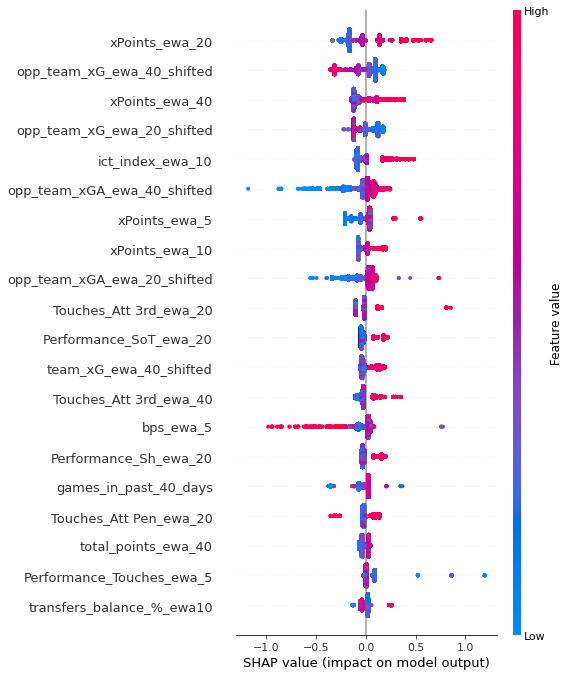

None

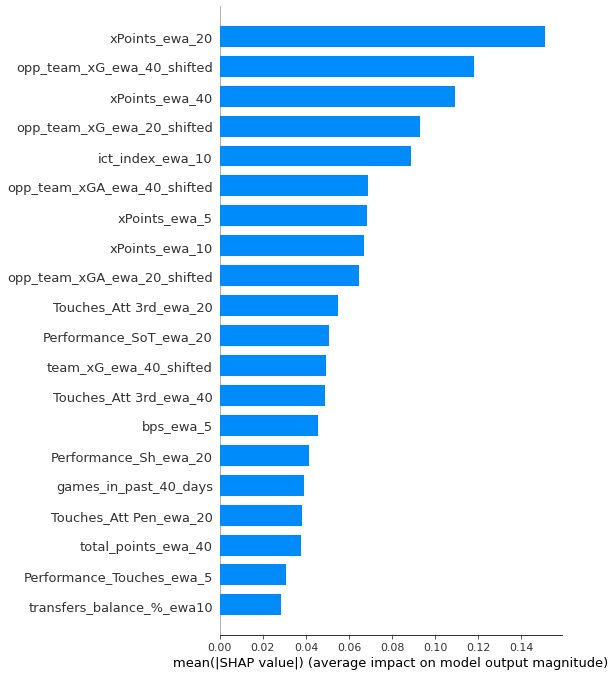

None

In [19]:
print('ALL PLAYERS')
display(shap.summary_plot(shap_values, max_display=20))
display(shap.summary_plot(shap_values, plot_type='bar'))

GOALKEEPERS


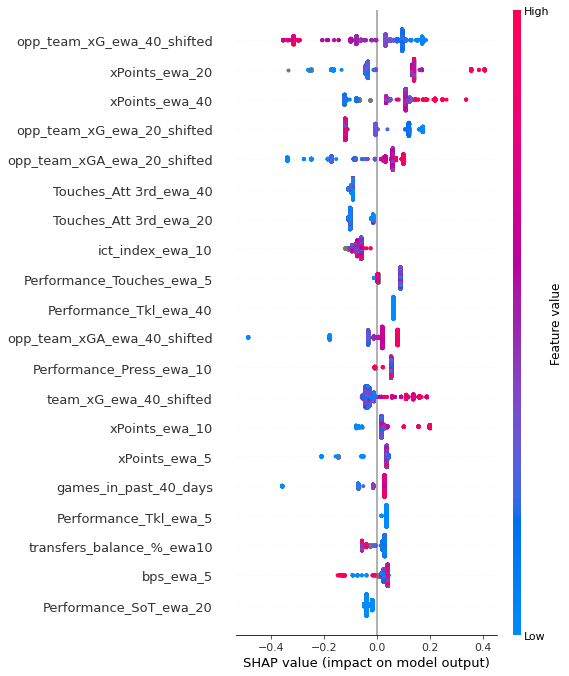

None

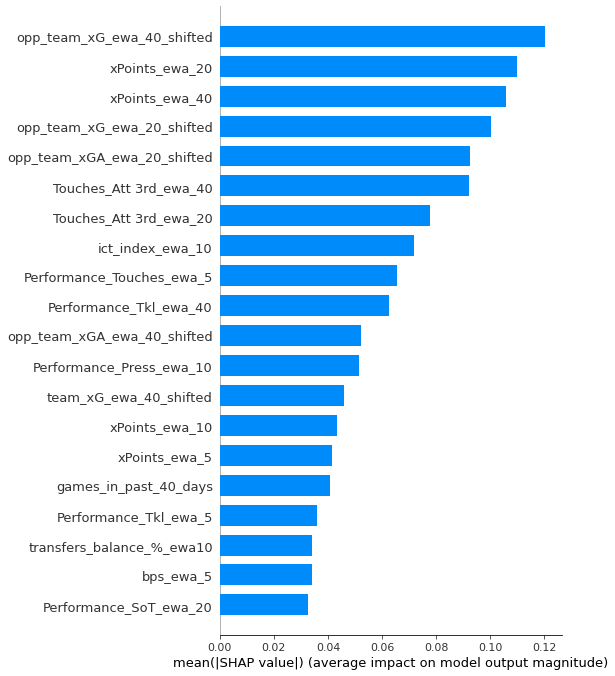

None

In [20]:
print('GOALKEEPERS')
display(shap.summary_plot(shap_values[(data['fpl_position_GK']==1).values], max_display=20))
display(shap.summary_plot(shap_values[(data['fpl_position_GK']==1).values], max_display=20, plot_type='bar'))

DEFENDERS


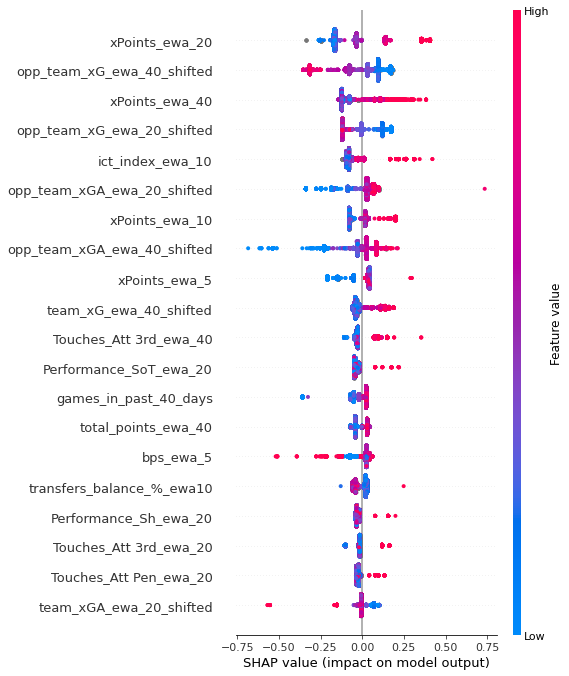

None

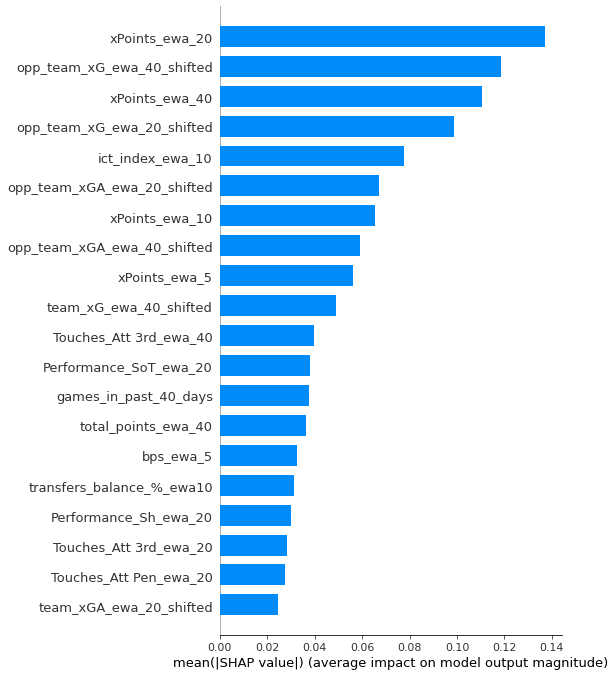

None

In [21]:
print('DEFENDERS')
display(shap.summary_plot(shap_values[(data['fpl_position_DEF']==1).values], max_display=20))
display(shap.summary_plot(shap_values[(data['fpl_position_DEF']==1).values], max_display=20, plot_type='bar'))

MIDFIELDERS


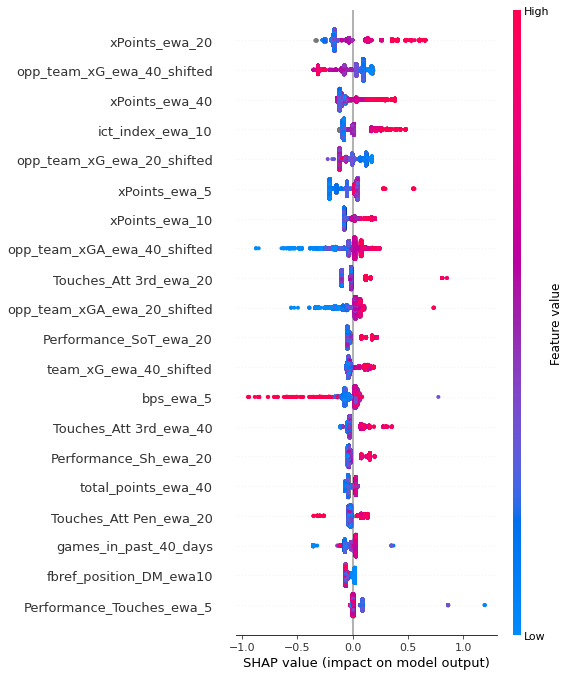

None

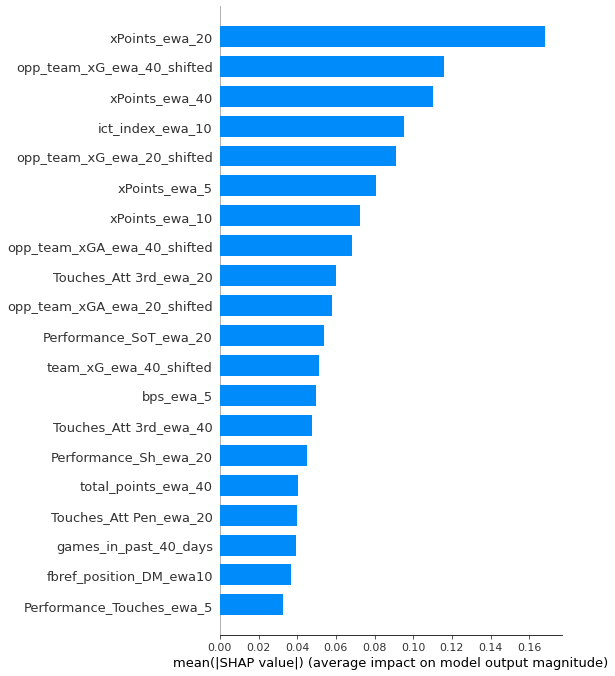

None

In [22]:
print('MIDFIELDERS')
display(shap.summary_plot(shap_values[(data['fpl_position_MID']==1).values], max_display=20))
display(shap.summary_plot(shap_values[(data['fpl_position_MID']==1).values], max_display=20, plot_type='bar'))

FORWARDS


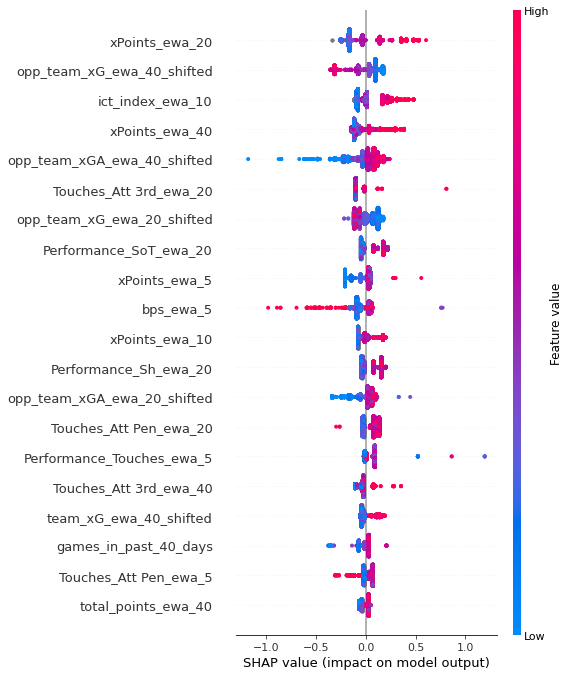

None

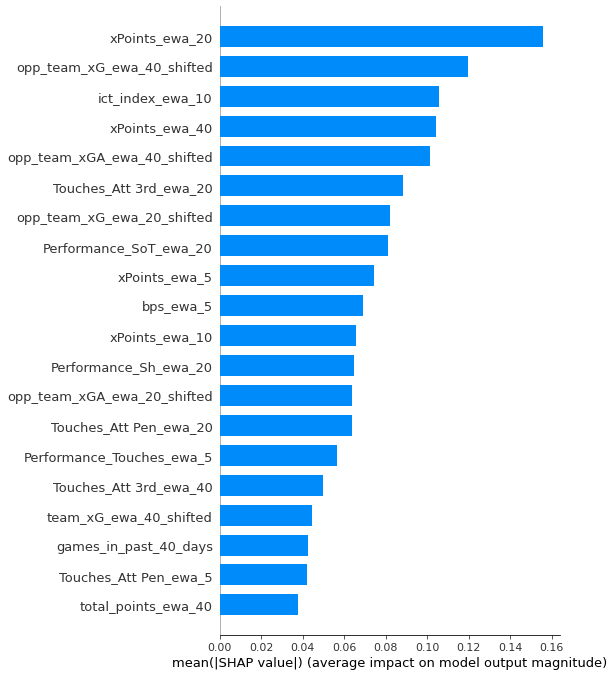

None

In [23]:
print('FORWARDS')
display(shap.summary_plot(shap_values[(data['fpl_position_FWD']==1).values], max_display=20))
display(shap.summary_plot(shap_values[(data['fpl_position_FWD']==1).values], max_display=20, plot_type='bar'))

In [24]:
# save model
model.save_model("../../models/xgb_regression_game1.json")